In [28]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.models import load_model
from scipy.ndimage import label
from skimage import morphology

### Functions for the pipeline:

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
        box1 (tuple): Bounding box 1 (x_min, y_min, x_max, y_max).
        box2 (tuple): Bounding box 2 (x_min, y_min, x_max, y_max).
    
    Returns:
        float: IoU value.
    """
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    # Calculate intersection area
    inter_width = max(0, x_max - x_min)
    inter_height = max(0, y_max - y_min)
    inter_area = inter_width * inter_height

    # Calculate area of both bounding boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = area_box1 + area_box2 - inter_area

    # Compute IoU with better precision
    return round(inter_area / union_area, 6) if union_area > 0 else 0


In [79]:
input_path = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\kaggle challenge\Kaggle Dataset"
output_path = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\Deliverables\task 8\Outputs\output5.csv"
patch_size = 256
example_file_name = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\Deliverables\task 5\michal_232079_unet_model_v3_256px.h5"
model = load_model(example_file_name, custom_objects={"f1": f1})

# Define the example image for visualizations
example_id = "10"  # The ID of the image you want visualized (e.g., "test_image_1.png" -> ID = "1")


---

### Cropping the images

### Debugging:

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Threshold for detecting the edge
threshold = 70

def crop_initial(image, initial_crop=100):
    """
    Crops 100 pixels from the left, right, and bottom of the image before applying edge detection.
    """
    return image[:, initial_crop:-initial_crop][:-initial_crop, :]

# Function to find edges by looping through the line
def find_edges(line, threshold):
    left_edge, right_edge = None, None
    n = len(line)

    # Loop from the left to find the first transition
    for i in range(1, n):
        if line[i - 1] < threshold <= line[i] or line[i - 1] >= threshold > line[i]:
            left_edge = i
            break

    # Loop from the right to find the last transition
    for i in range(n - 1, 0, -1):
        if line[i] < threshold <= line[i - 1] or line[i] >= threshold > line[i - 1]:
            right_edge = i
            break

    return left_edge, right_edge

# Function to crop an image based on detected edges
def format(image):
    # Extract horizontal and vertical lines for analysis
    horizontal_line = image[1503, :]  # Pixel values along the middle horizontal line
    vertical_line = image[:, 2056]   # Pixel values along the middle vertical line

    # Find edges along the horizontal and vertical lines
    left_x, right_x = find_edges(horizontal_line, threshold)
    top_y, bottom_y = find_edges(vertical_line, threshold)

    # Ensure the cropped region is square
    side_length = max(right_x - left_x, bottom_y - top_y)
    right_x = left_x + side_length
    bottom_y = top_y + side_length

    return slice(top_y, bottom_y), slice(left_x, right_x)

# Function to process all images in a folder
def process_images(input_path):
    cropped_images = {}

    for file_name in os.listdir(input_path):
        file_path = os.path.join(input_path, file_name)

        # Ensure the file is an image
        if not (file_name.endswith(".png") or file_name.endswith(".jpg") or file_name.endswith(".jpeg")):
            continue

        # Load the image
        original_image = cv2.imread(file_path, 0)  # Load as grayscale

        # Initial crop to remove 100 pixels from left, right, and bottom
        cropped_initial = crop_initial(original_image)

        # Crop the image further using the format function
        crop_slices = format(cropped_initial)
        cropped_image = cropped_initial[crop_slices]

        # Save the cropped image and slices in the dictionary
        cropped_images[file_name] = {
            "cropped_image": cropped_image,
            "crop_slices": crop_slices
        }

        print(f"Processed: {file_name} | Cropped Shape: {cropped_image.shape}")

    return cropped_images

# Example visualization for a specific image
def visualize_cropped_image(cropped_images, example_file_name):
    if example_file_name in cropped_images:
        plt.figure(figsize=(5, 5))
        plt.imshow(cropped_images[example_file_name]["cropped_image"], cmap="gray")
        plt.title(f"Cropped Image: {example_file_name}")
        plt.axis("off")
        plt.show()
    else:
        print(f"Image {example_file_name} not found in processed results.")

# Usage example
cropped_images = process_images(input_path)


Processed: test_image_1.png | Cropped Shape: (2707, 2707)
Processed: test_image_10.png | Cropped Shape: (2778, 2778)
Processed: test_image_11.png | Cropped Shape: (2776, 2776)
Processed: test_image_12.png | Cropped Shape: (2788, 2788)
Processed: test_image_13.png | Cropped Shape: (2789, 2789)
Processed: test_image_14.png | Cropped Shape: (2785, 2785)
Processed: test_image_15.png | Cropped Shape: (2787, 2787)
Processed: test_image_16.png | Cropped Shape: (2789, 2789)
Processed: test_image_17.png | Cropped Shape: (2788, 2788)
Processed: test_image_18.png | Cropped Shape: (2788, 2788)
Processed: test_image_2.png | Cropped Shape: (2707, 2707)
Processed: test_image_3.png | Cropped Shape: (2707, 2707)
Processed: test_image_4.png | Cropped Shape: (2707, 2707)
Processed: test_image_5.png | Cropped Shape: (2707, 2707)
Processed: test_image_6.png | Cropped Shape: (2707, 2707)
Processed: test_image_7.png | Cropped Shape: (2707, 2707)
Processed: test_image_8.png | Cropped Shape: (2707, 2707)
Proce

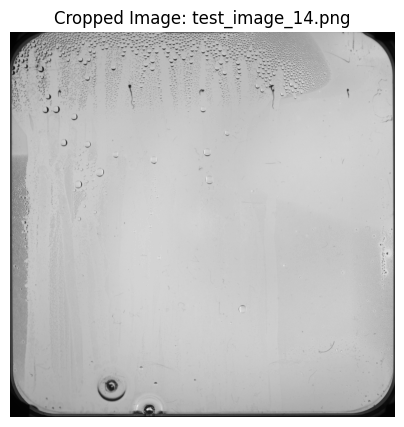

In [12]:

# Visualize a specific image
example_file_name = "test_image_14.png"  
visualize_cropped_image(cropped_images, example_file_name)


### Padding the images

Processed test_image_1.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_10.png: Original Shape = (2778, 2778), Padded Shape = (2816, 2816), Padding = (Top: 19, Bottom: 19, Left: 19, Right: 19)
Processed test_image_11.png: Original Shape = (2776, 2776), Padded Shape = (2816, 2816), Padding = (Top: 20, Bottom: 20, Left: 20, Right: 20)
Processed test_image_12.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Processed test_image_13.png: Original Shape = (2789, 2789), Padded Shape = (2816, 2816), Padding = (Top: 13, Bottom: 14, Left: 13, Right: 14)
Processed test_image_14.png: Original Shape = (2785, 2785), Padded Shape = (2816, 2816), Padding = (Top: 15, Bottom: 16, Left: 15, Right: 16)
Processed test_image_15.png: Original Shape = (2787, 2787), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 15, Left: 14, Right: 15)
Visuali

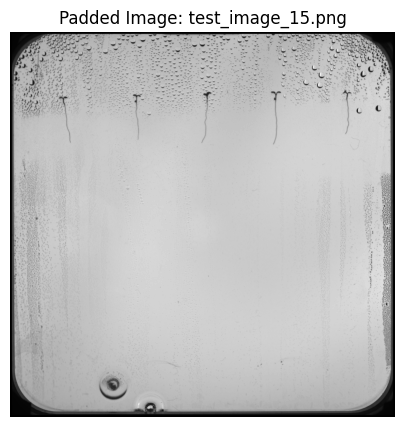

Processed test_image_16.png: Original Shape = (2789, 2789), Padded Shape = (2816, 2816), Padding = (Top: 13, Bottom: 14, Left: 13, Right: 14)
Processed test_image_17.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Processed test_image_18.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Processed test_image_2.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_3.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_4.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_5.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed 

In [13]:
def padder_from_cropped_images(cropped_images, patch_size, example_id=None):
    """
    Adds padding to all cropped images to make their dimensions divisible by a specified patch size.
    Visualizes results for a specified example image ID.

    Parameters:
        cropped_images (dict): A dictionary with image names as keys and values containing:
            - "cropped_image": The cropped image as a NumPy array.
            - "crop_slices": The crop slices used to crop the original image.
        patch_size (int): The size of the patches the image should be divisible by.
        example_id (str): The ID of the image to visualize results for.

    Returns:
        dict: Updated dictionary with padded images and padding values added.
    """
    padded_images = {}

    for file_name, data in cropped_images.items():
        cropped_image = data["cropped_image"]  # Extract the cropped image

        # Get dimensions of the cropped image
        h, w = cropped_image.shape[:2]
        height_padding = ((h // patch_size) + 1) * patch_size - h
        width_padding = ((w // patch_size) + 1) * patch_size - w

        top_padding = height_padding // 2
        bottom_padding = height_padding - top_padding

        left_padding = width_padding // 2
        right_padding = width_padding - left_padding

        # Add padding using cv2.copyMakeBorder
        padded_image = cv2.copyMakeBorder(
            cropped_image,
            top_padding,
            bottom_padding,
            left_padding,
            right_padding,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0]  # Padding with black pixels
        )

        # Update the dictionary with the padded image and padding values
        padded_images[file_name] = {
            "padded_image": padded_image,
            "padding": (top_padding, bottom_padding, left_padding, right_padding),
            "crop_slices": data["crop_slices"]  # Retain the original crop slices
        }

        print(f"Processed {file_name}: Original Shape = {cropped_image.shape}, "
              f"Padded Shape = {padded_image.shape}, "
              f"Padding = (Top: {top_padding}, Bottom: {bottom_padding}, "
              f"Left: {left_padding}, Right: {right_padding})")

        # Visualize only if the current file matches the exact example_id
        example_file_name = f"test_image_{example_id}.png"  # Adjust to match your naming convention
        if example_id and file_name == example_file_name:
            print(f"Visualizing example image: {file_name}")
            plt.figure(figsize=(5, 5))
            plt.imshow(padded_image, cmap="gray")
            plt.title(f"Padded Image: {file_name}")
            plt.axis("off")
            plt.show()

    return padded_images

# Run the padding function
padded_images = padder_from_cropped_images(cropped_images, patch_size, 15)


### Inference:

Processing test_image_1.png...
Completed test_image_1.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_10.png...
Completed test_image_10.png: Predicted Mask Shape = (2778, 2778)
Processing test_image_11.png...
Completed test_image_11.png: Predicted Mask Shape = (2776, 2776)
Processing test_image_12.png...
Completed test_image_12.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_13.png...
Completed test_image_13.png: Predicted Mask Shape = (2789, 2789)
Processing test_image_14.png...
Completed test_image_14.png: Predicted Mask Shape = (2785, 2785)
Processing test_image_15.png...
Completed test_image_15.png: Predicted Mask Shape = (2787, 2787)
Processing test_image_16.png...
Completed test_image_16.png: Predicted Mask Shape = (2789, 2789)
Processing test_image_17.png...
Completed test_image_17.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_18.png...
Completed test_image_18.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_2.png...
C

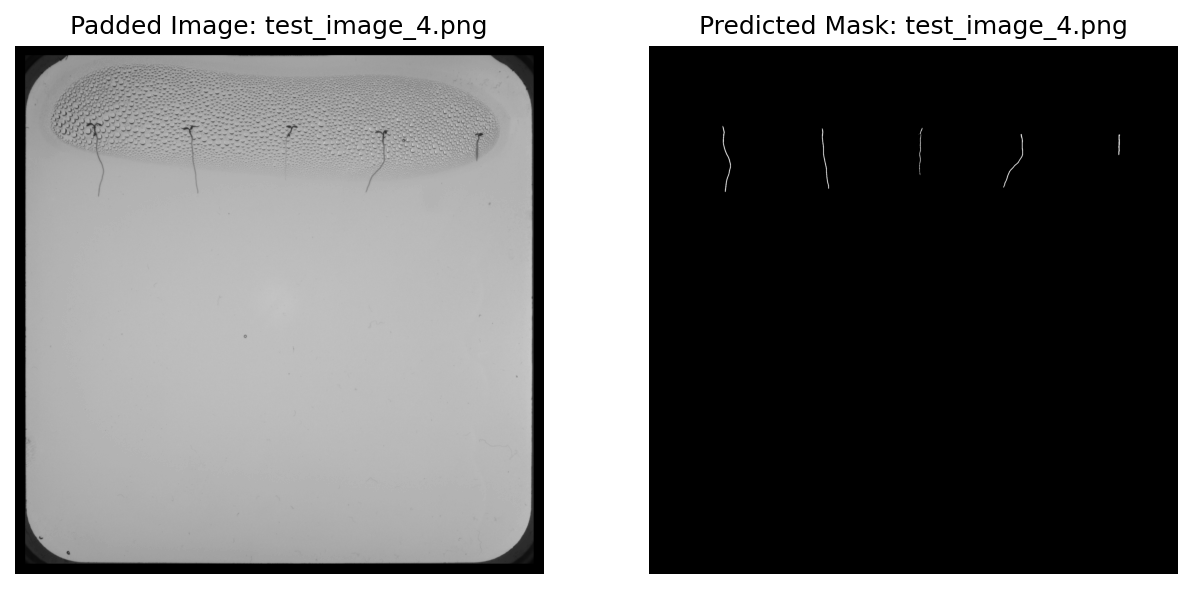

Processing test_image_5.png...
Completed test_image_5.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_6.png...
Completed test_image_6.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_7.png...
Completed test_image_7.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_8.png...
Completed test_image_8.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_9.png...
Completed test_image_9.png: Predicted Mask Shape = (2789, 2789)


In [15]:
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt
import os

def run_inference_on_padded_images(padded_images, model, patch_size, example_id=None):
    """
    Runs inference on multiple padded images, predicts masks, and crops them back to original dimensions.
    Visualizes results for a specified example image ID.

    Parameters:
        padded_images (dict): Dictionary containing padded images and their padding details.
        model (keras.Model): Pre-trained model for inference.
        patch_size (int): Size of patches for prediction.
        example_id (str): The exact ID of the image to visualize results for.

    Returns:
        dict: Dictionary with predicted masks and their original dimensions.
    """
    results = {}

    for file_name, data in padded_images.items():
        print(f"Processing {file_name}...")

        padded_image = data["padded_image"]
        padding = data["padding"]
        top_padding, bottom_padding, left_padding, right_padding = padding

        # Convert to 3 channels for patching
        padded_image_3channel = np.repeat(padded_image[..., np.newaxis], 3, axis=-1)

        # Create patches for prediction
        patches = patchify(padded_image_3channel, (patch_size, patch_size, 3), step=patch_size)
        patches_flat = patches.reshape(-1, patch_size, patch_size, 3) / 255.0  # Normalize

        # Predict patches
        predictions = model.predict(patches_flat, verbose=0)  # Run prediction silently
        predicted_patches = (predictions > 0.5).astype(np.uint8)
        predicted_patches_reshaped = predicted_patches.reshape(
            patches.shape[0], patches.shape[1], patch_size, patch_size
        )

        # Reconstruct the predicted mask
        predicted_mask = unpatchify(predicted_patches_reshaped, padded_image.shape[:2])

        # Remove padding
        predicted_mask_cropped = predicted_mask[
            top_padding:predicted_mask.shape[0] - bottom_padding,
            left_padding:predicted_mask.shape[1] - right_padding
        ]

        # Save the result
        results[file_name] = {
            "predicted_mask": predicted_mask_cropped,
            "original_shape": predicted_mask_cropped.shape
        }

        print(f"Completed {file_name}: Predicted Mask Shape = {predicted_mask_cropped.shape}")

        # Visualize only if the current file matches the exact example_id
        example_file_name = f"test_image_{example_id}.png"  # Adjust to match your naming convention
        if example_id and file_name == example_file_name:
            print(f"Visualizing example image: {file_name}")
            f, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
            ax[0].imshow(padded_image, cmap='gray')
            ax[0].axis('off')
            ax[0].set_title(f'Padded Image: {file_name}')
            ax[1].imshow(predicted_mask_cropped, cmap='gray')
            ax[1].axis('off')
            ax[1].set_title(f'Predicted Mask: {file_name}')
            plt.show()


    return results

# Run inference and visualize the specific example image
predicted_results = run_inference_on_padded_images(padded_images, model, patch_size, 4)



### Morphological operations:

In [16]:
import cv2
import numpy as np

def apply_closing_to_all(predicted_results, kernel_size):
    """
    Apply morphological closing to all predicted masks and store the results in a compatible format.

    Parameters:
        predicted_results (dict): Dictionary with predicted masks and metadata.
        kernel_size (tuple): Size of the structuring element.

    Returns:
        dict: Dictionary with IDs as keys and processed masks in the required structure.
    """
    closed_masks = {}
    kernel = np.ones(kernel_size, np.uint8)  # Structuring element

    for file_name, data in predicted_results.items():
        print(f"Processing mask for {file_name}...")

        # Extract the predicted mask
        mask = data.get("predicted_mask")
        if mask is None:
            raise ValueError(f"No predicted mask found for {file_name}.")

        # Apply morphological closing
        closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Store the closed mask in the compatible structure
        closed_masks[file_name] = {"predicted_mask": closed_mask}

    return closed_masks


# Define the kernel size for morphological closing
kernel_size = (31, 31)

# Apply closing to `predicted_results`
closed_masks = apply_closing_to_all(predicted_results, kernel_size)


Processing mask for test_image_1.png...
Processing mask for test_image_10.png...
Processing mask for test_image_11.png...
Processing mask for test_image_12.png...
Processing mask for test_image_13.png...
Processing mask for test_image_14.png...
Processing mask for test_image_15.png...
Processing mask for test_image_16.png...
Processing mask for test_image_17.png...
Processing mask for test_image_18.png...
Processing mask for test_image_2.png...
Processing mask for test_image_3.png...
Processing mask for test_image_4.png...
Processing mask for test_image_5.png...
Processing mask for test_image_6.png...
Processing mask for test_image_7.png...
Processing mask for test_image_8.png...
Processing mask for test_image_9.png...


### Dynamic section creation:

Processing mask for test_image_1.png...
Visualizing dynamic sections for test_image_1.png


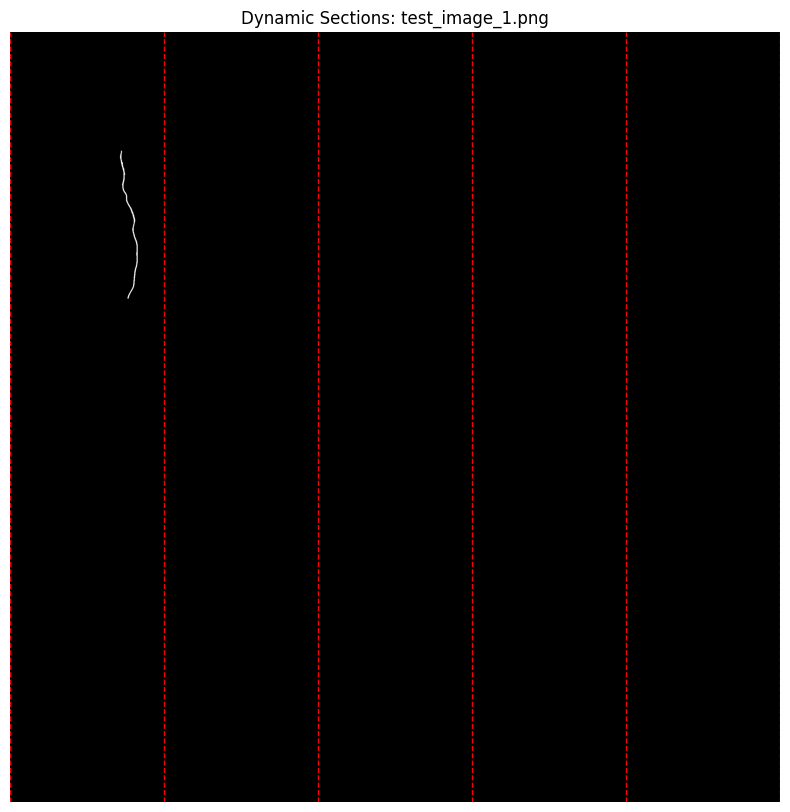

Processing mask for test_image_10.png...
Visualizing dynamic sections for test_image_10.png


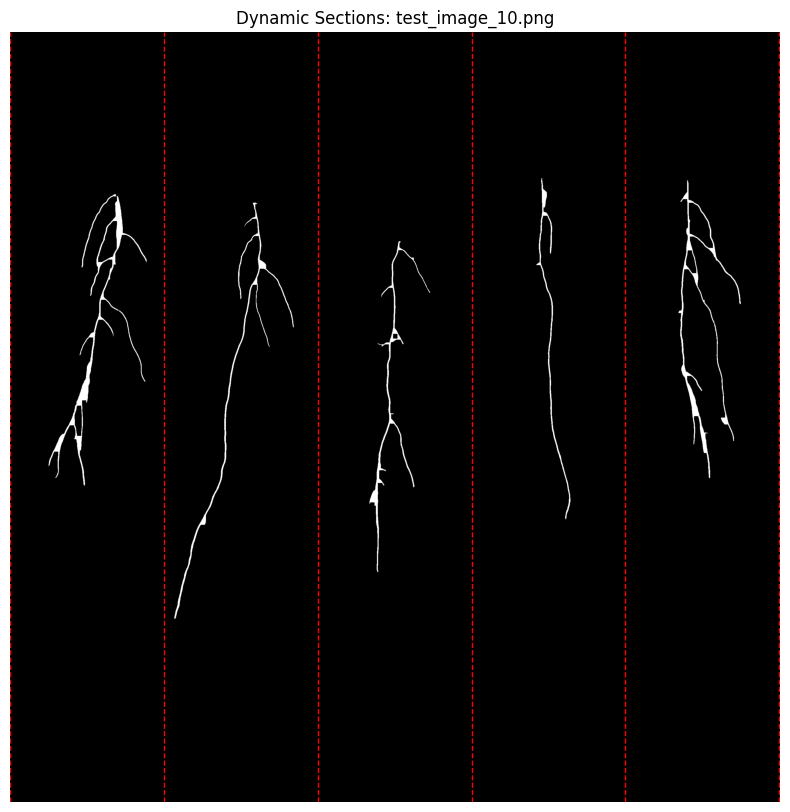

Processing mask for test_image_11.png...
Visualizing dynamic sections for test_image_11.png


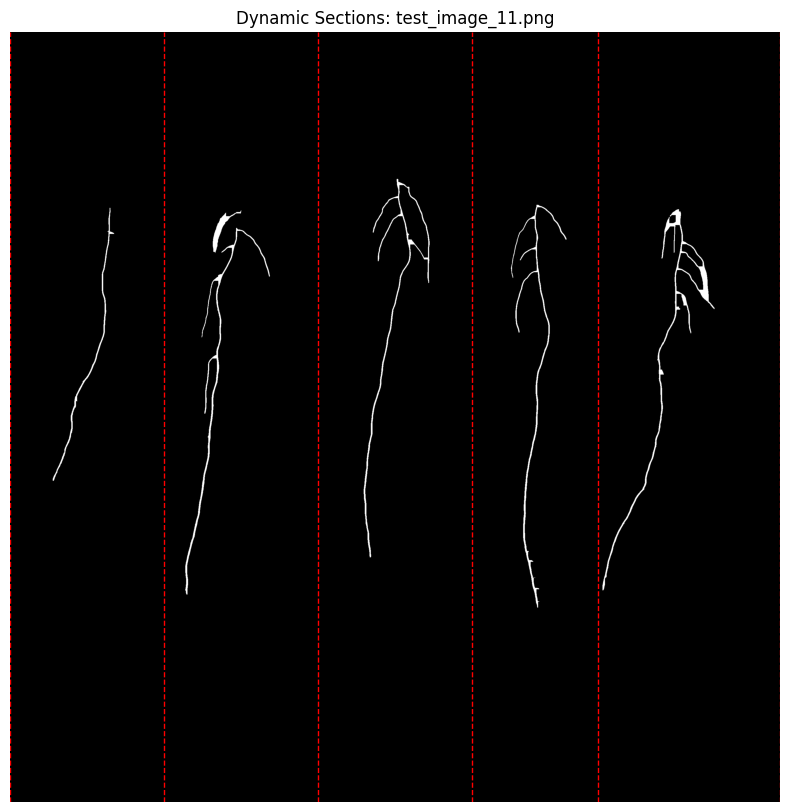

Processing mask for test_image_12.png...
Visualizing dynamic sections for test_image_12.png


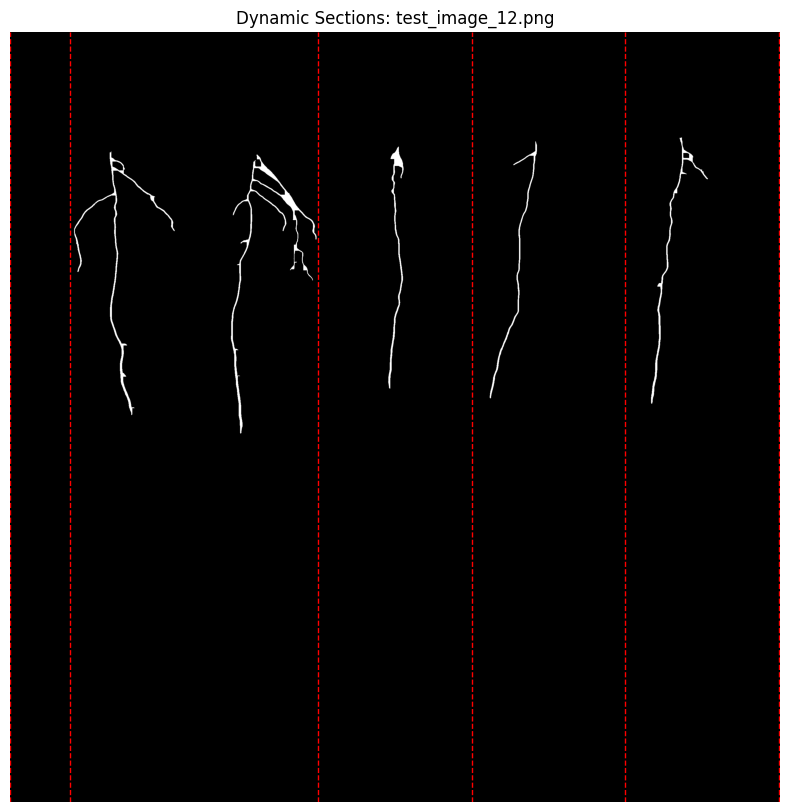

Processing mask for test_image_13.png...
Visualizing dynamic sections for test_image_13.png


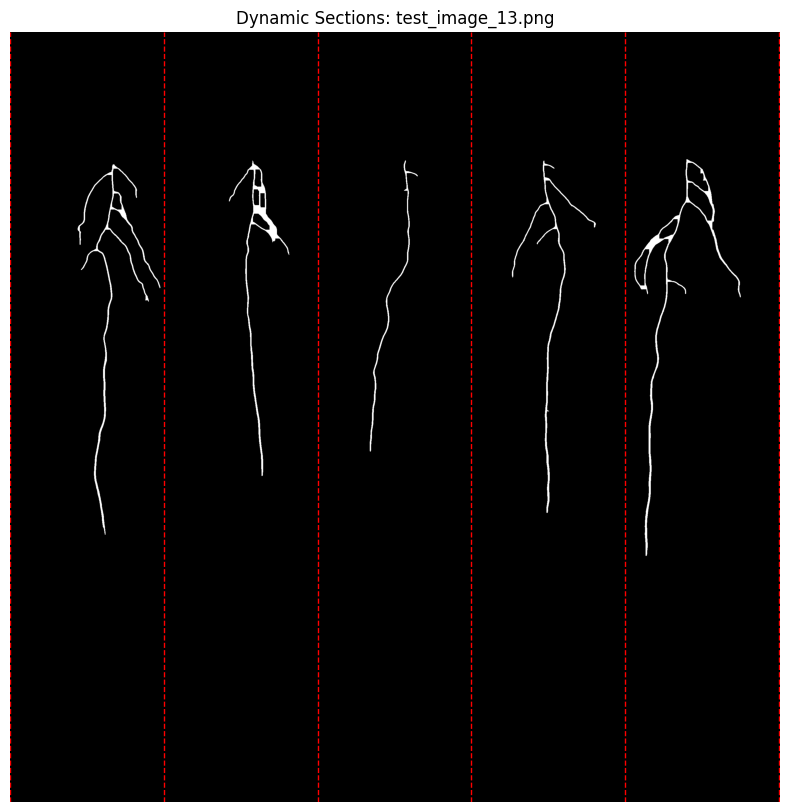

Processing mask for test_image_14.png...
No roots detected for test_image_14.png. Using default sections.
Visualizing dynamic sections for test_image_14.png


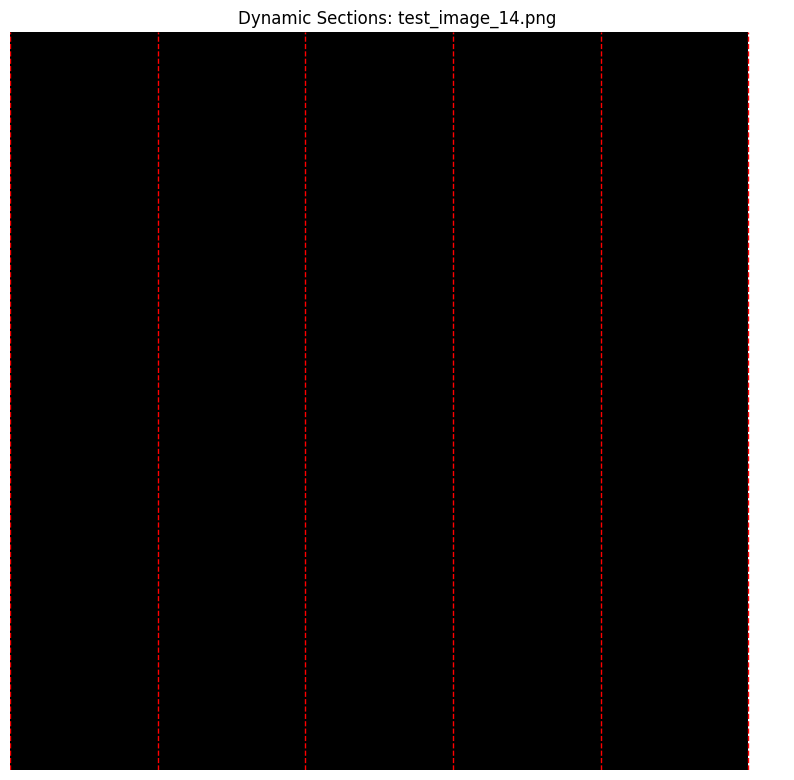

Processing mask for test_image_15.png...
No roots detected for test_image_15.png. Using default sections.
Visualizing dynamic sections for test_image_15.png


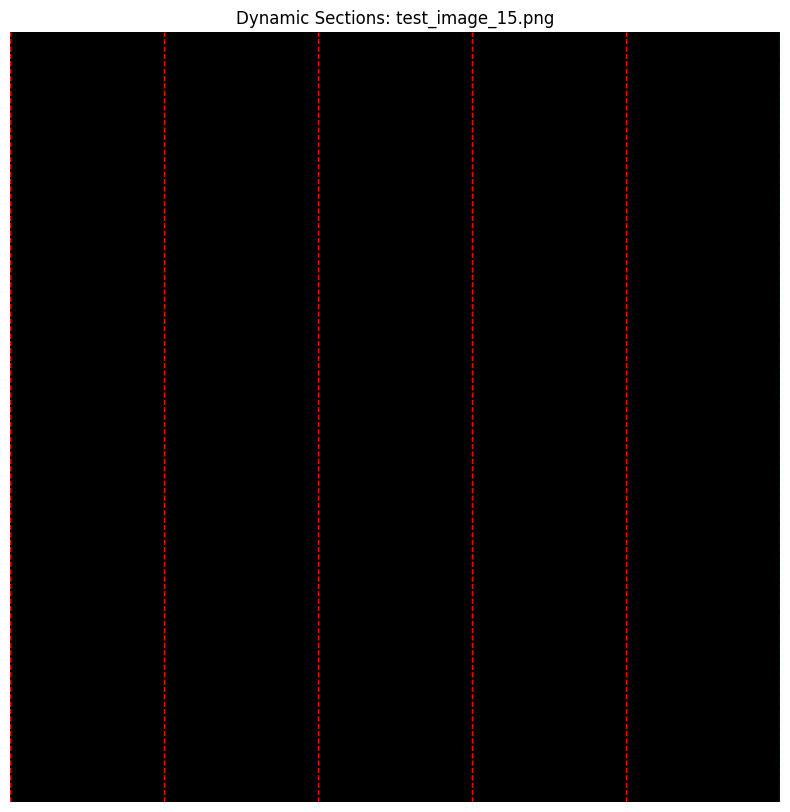

Processing mask for test_image_16.png...
Visualizing dynamic sections for test_image_16.png


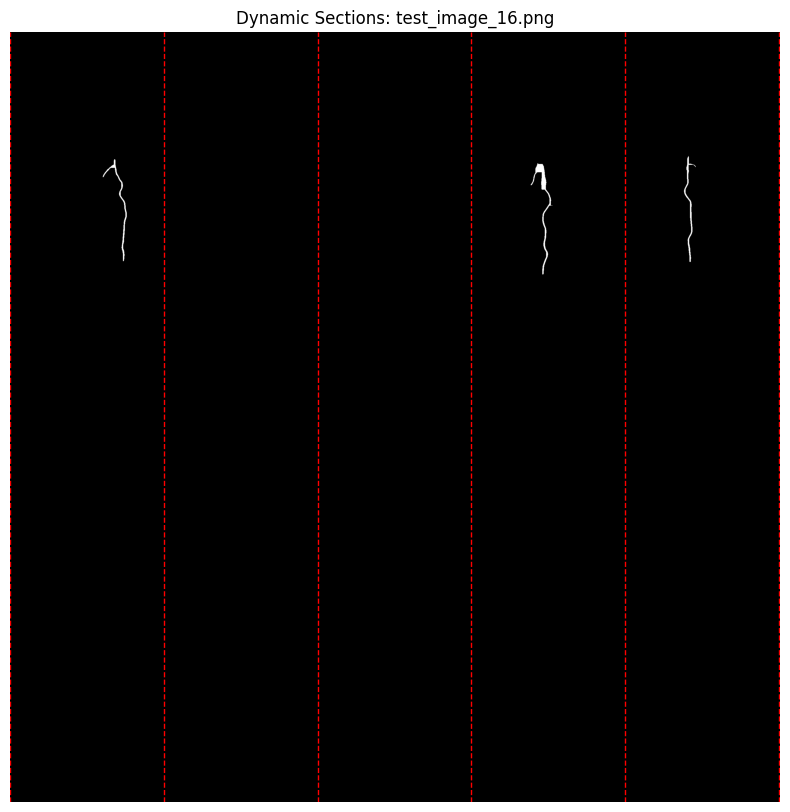

Processing mask for test_image_17.png...
Visualizing dynamic sections for test_image_17.png


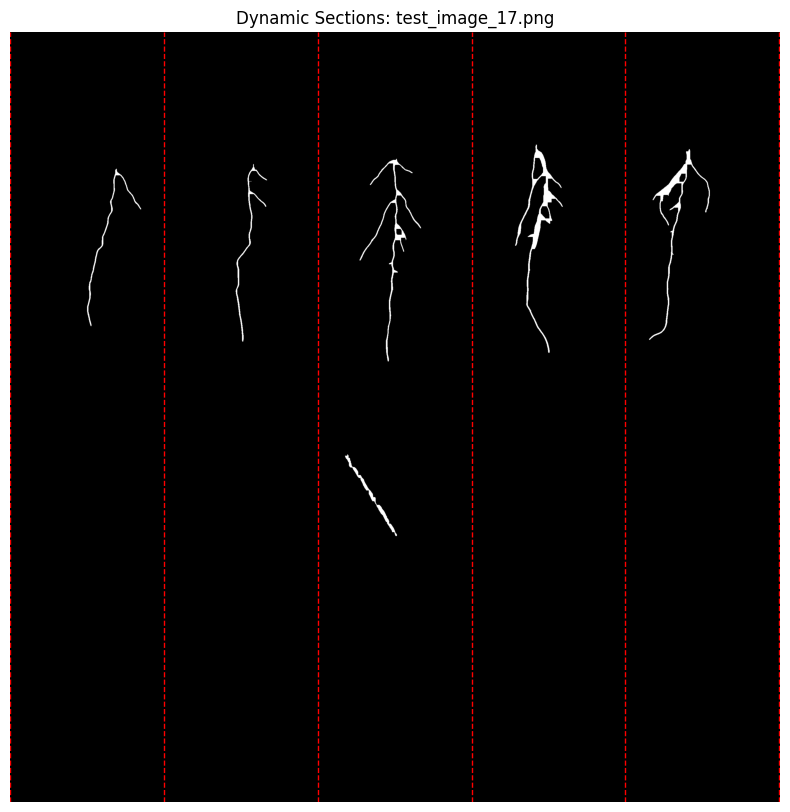

Processing mask for test_image_18.png...
Visualizing dynamic sections for test_image_18.png


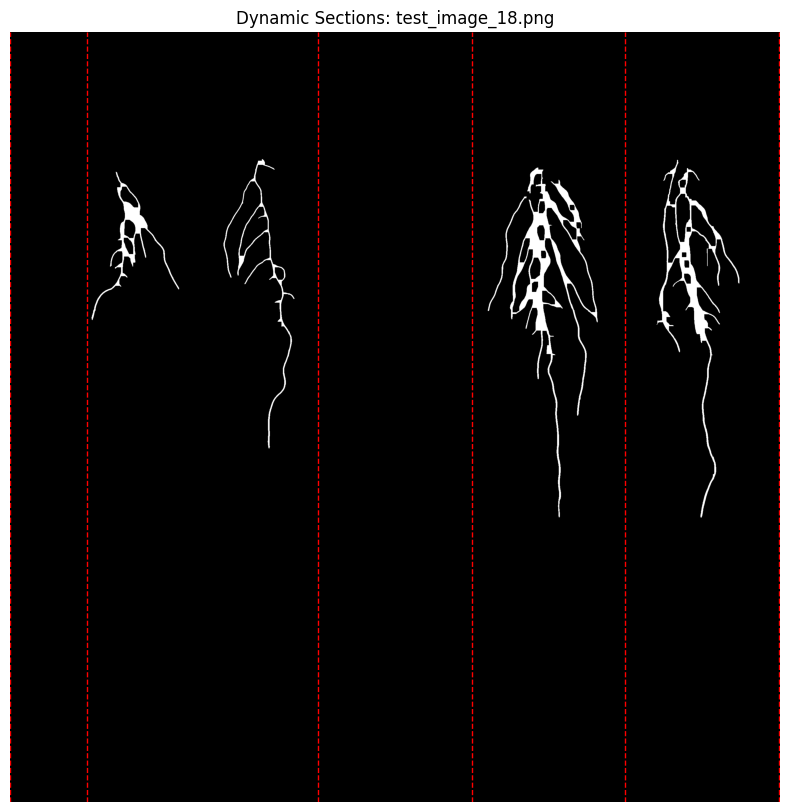

Processing mask for test_image_2.png...
Visualizing dynamic sections for test_image_2.png


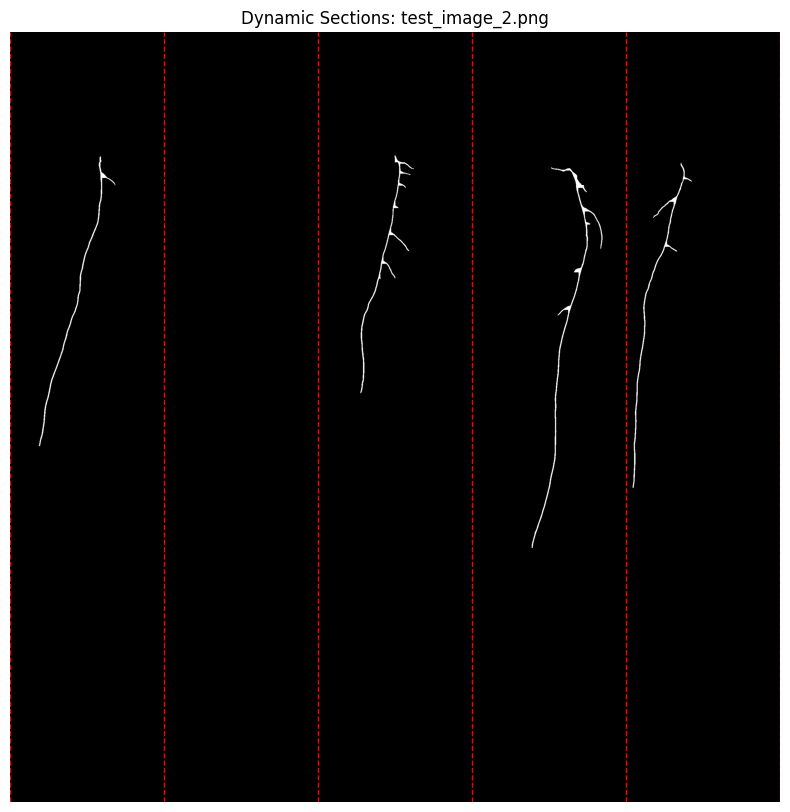

Processing mask for test_image_3.png...
No roots detected for test_image_3.png. Using default sections.
Visualizing dynamic sections for test_image_3.png


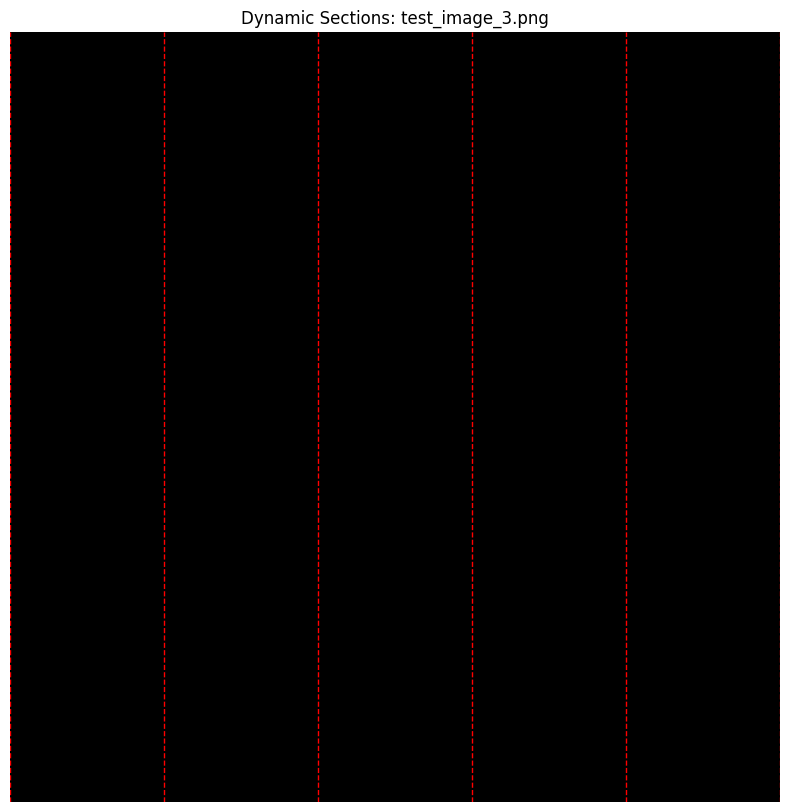

Processing mask for test_image_4.png...
No roots detected for test_image_4.png. Using default sections.
Visualizing dynamic sections for test_image_4.png


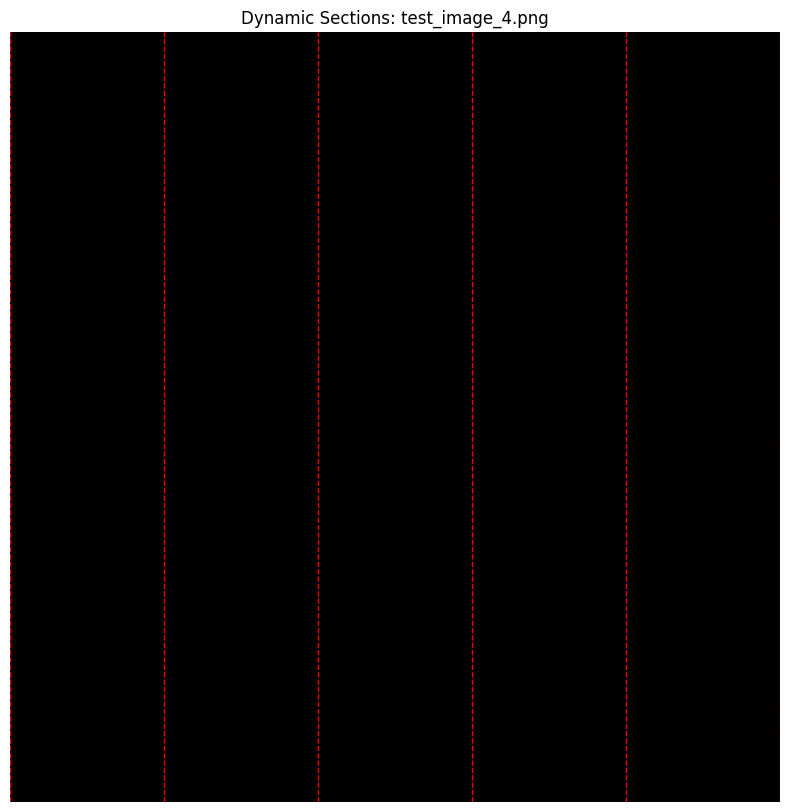

Processing mask for test_image_5.png...
No roots detected for test_image_5.png. Using default sections.
Visualizing dynamic sections for test_image_5.png


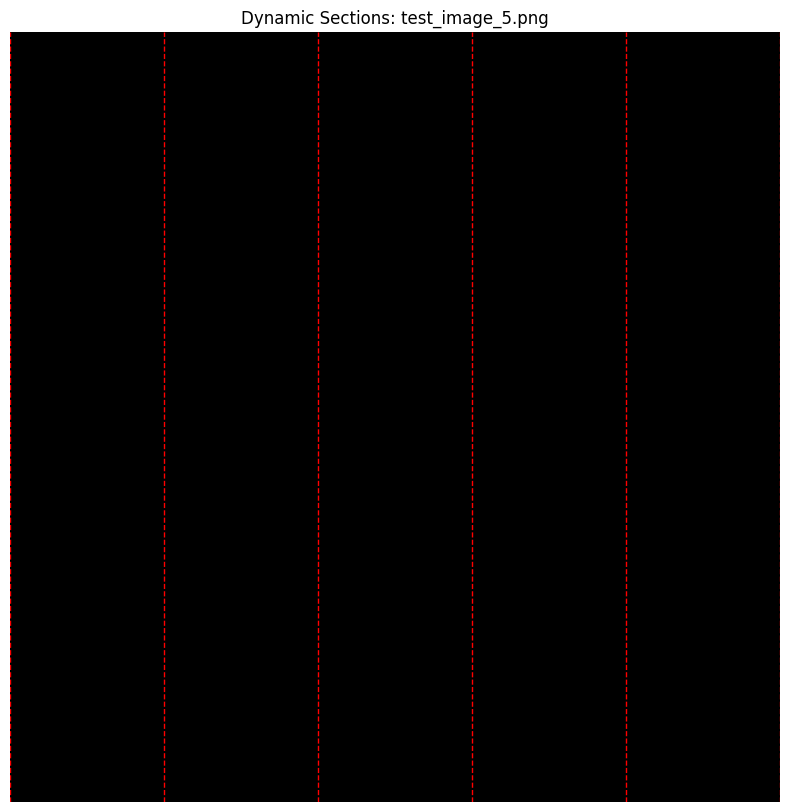

Processing mask for test_image_6.png...
Visualizing dynamic sections for test_image_6.png


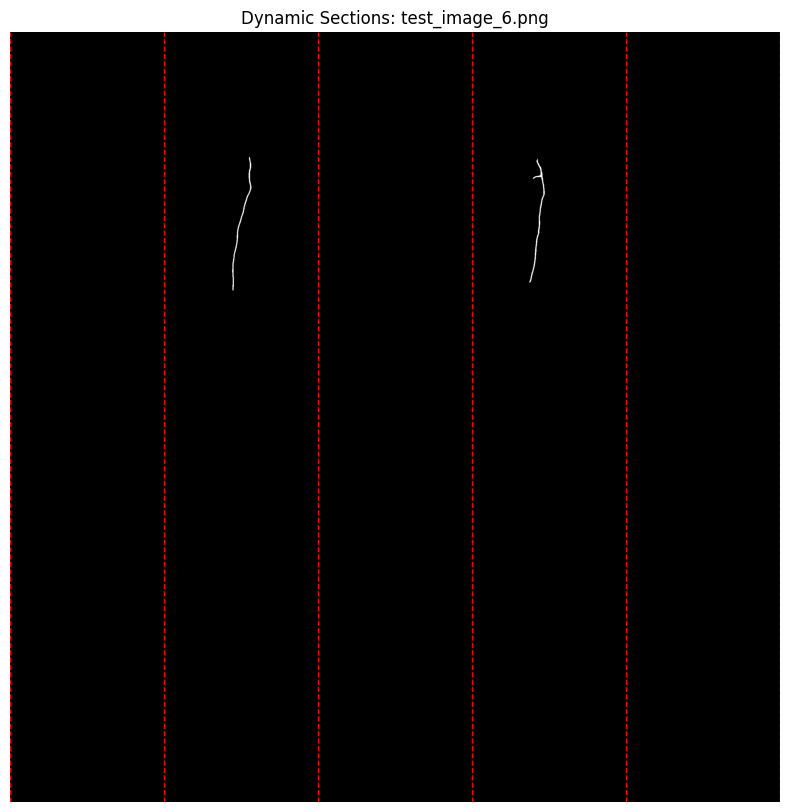

Processing mask for test_image_7.png...
Visualizing dynamic sections for test_image_7.png


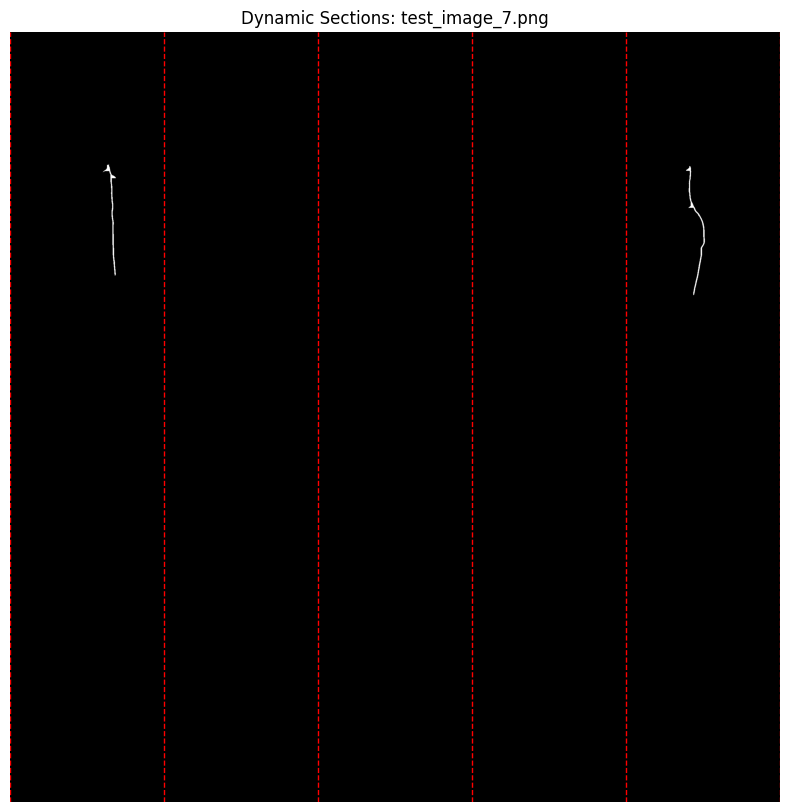

Processing mask for test_image_8.png...
Visualizing dynamic sections for test_image_8.png


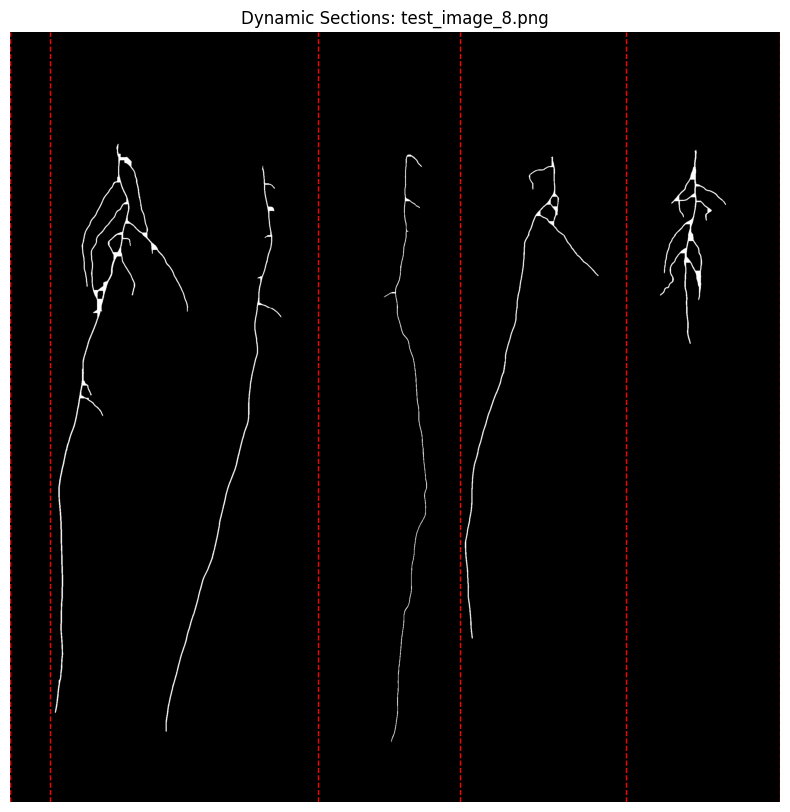

Processing mask for test_image_9.png...
Visualizing dynamic sections for test_image_9.png


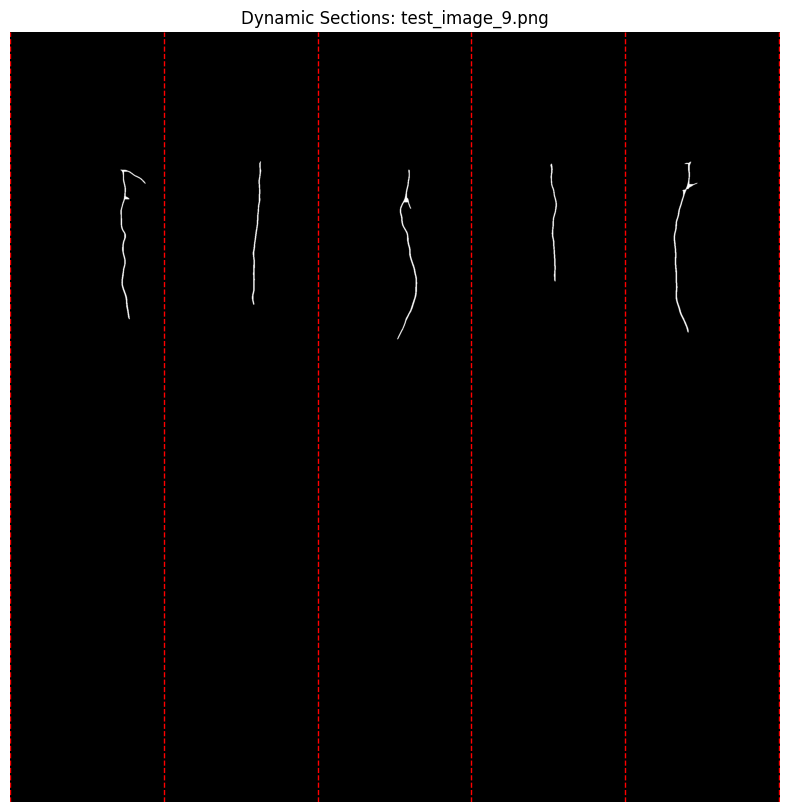

In [38]:
from skimage import morphology
import cv2
import numpy as np

def create_dynamic_sections(predicted_results, size_threshold, num_sections=5, closing_kernel_size=15, step_size=20):
    """
    Create dynamic sections for masks by applying morphological closing and removing small objects.
    Each section boundary moves individually in 20-pixel increments to avoid crossing roots. If no 
    objects remain in the mask, default sections are used.

    Parameters:
        predicted_results (dict): Dictionary with predicted masks and metadata.
        size_threshold (int): Minimum size of components to keep.
        num_sections (int): Number of vertical sections to divide the mask into.
        closing_kernel_size (int): Size of the kernel for morphological closing.
        step_size (int): Step size in pixels for adjusting section boundaries.

    Returns:
        dict: Dictionary with:
            - "sections": List of (start_x, end_x) tuples for each mask.
            - "cleaned_masks": Cleaned masks after noise removal.
    """
    results = {}

    for file_name, data in predicted_results.items():
        print(f"Processing mask for {file_name}...")

        # Extract the predicted mask
        mask = data.get("predicted_mask")
        if mask is None:
            raise ValueError(f"No predicted mask found for {file_name}.")

        h, w = mask.shape

        # Apply morphological closing to fill gaps and clean the mask
        kernel = np.ones((closing_kernel_size, closing_kernel_size), np.uint8)
        closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Remove small objects from the closed mask
        labeled_mask, num_labels = morphology.label(closed_mask > 0, connectivity=2, return_num=True)
        refined_mask = np.zeros_like(mask, dtype=np.uint8)
        for label in range(1, num_labels + 1):
            component = (labeled_mask == label)
            if component.sum() >= size_threshold:
                refined_mask[component] = 255

        # Check if the refined mask is empty
        if refined_mask.sum() == 0:
            print(f"No roots detected for {file_name}. Using default sections.")
            boundaries = [i * (w // num_sections) for i in range(num_sections + 1)]
        else:
            # Dynamically adjust section boundaries
            boundaries = [i * (w // num_sections) for i in range(num_sections + 1)]  # Default boundaries
            for i in range(1, len(boundaries) - 1):  # Exclude the first and last boundaries
                while True:
                    # Check if the current boundary cuts through roots
                    boundary = boundaries[i]
                    left_mask = refined_mask[:, boundary - 1 : boundary] if boundary > 0 else np.zeros((h, 1))
                    right_mask = refined_mask[:, boundary : boundary + 1] if boundary < w else np.zeros((h, 1))
                    if not (left_mask.sum() > 0 and right_mask.sum() > 0):  # No crossing
                        break
                    if boundary - step_size <= boundaries[i - 1]:  # Avoid overlapping with the previous boundary
                        break
                    boundaries[i] -= step_size  # Move boundary left by step_size

        # Store results
        results[file_name] = {
            "sections": [(boundaries[i], boundaries[i + 1]) for i in range(len(boundaries) - 1)],
            "cleaned_mask": refined_mask,
        }

        # Visualize the cleaned mask and dynamic sections
        print(f"Visualizing dynamic sections for {file_name}")
        plt.figure(figsize=(10, 10))
        plt.imshow(refined_mask, cmap="gray")
        plt.title(f"Dynamic Sections: {file_name}")
        plt.axis("off")
        for boundary in boundaries:
            plt.axvline(x=boundary, color="red", linestyle="--", linewidth=1)
        plt.show()

    return results


section_data = create_dynamic_sections(predicted_results, size_threshold=2000, num_sections=5, closing_kernel_size=15)

Processing mask for test_image_1.png...
Visualizing processed mask for test_image_1.png


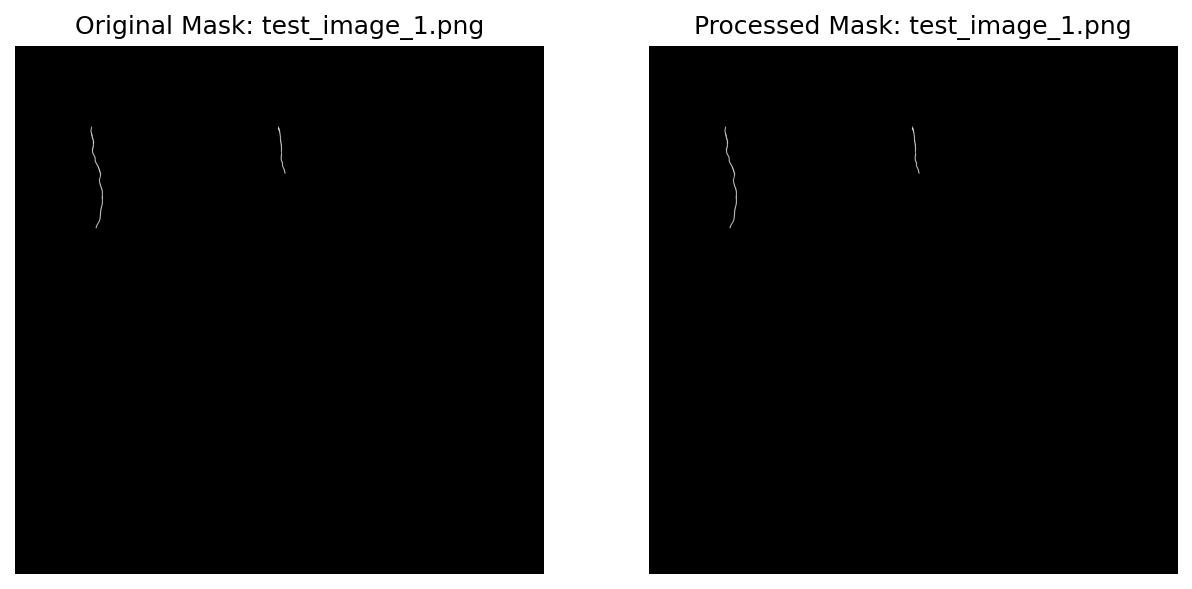

Processing mask for test_image_10.png...
Visualizing processed mask for test_image_10.png


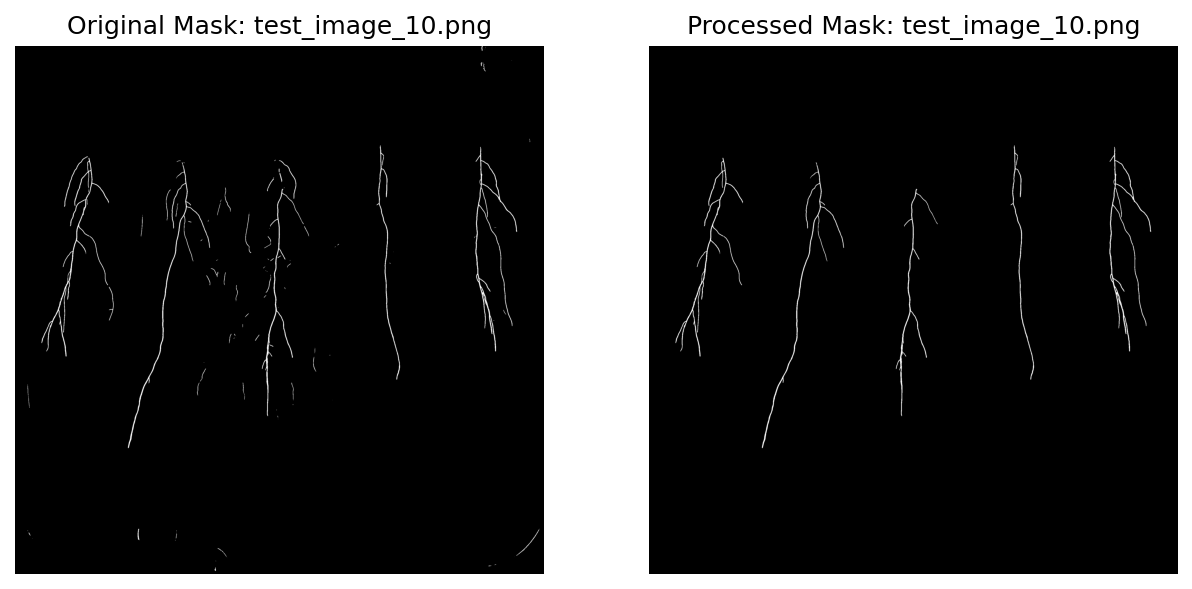

Processing mask for test_image_11.png...
Visualizing processed mask for test_image_11.png


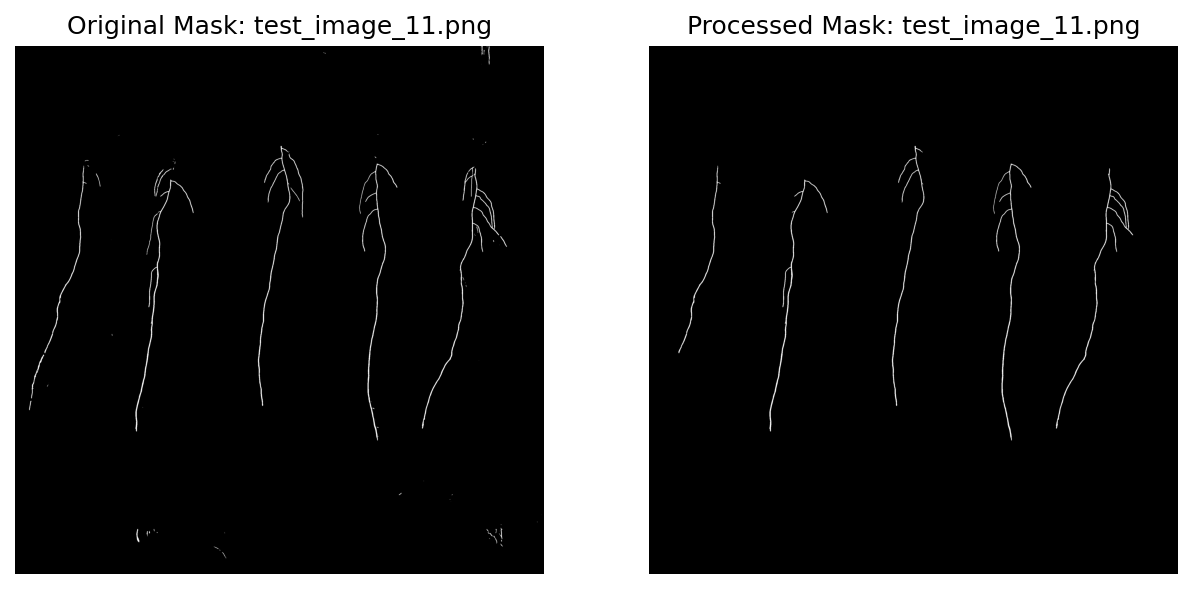

Processing mask for test_image_12.png...
Visualizing processed mask for test_image_12.png


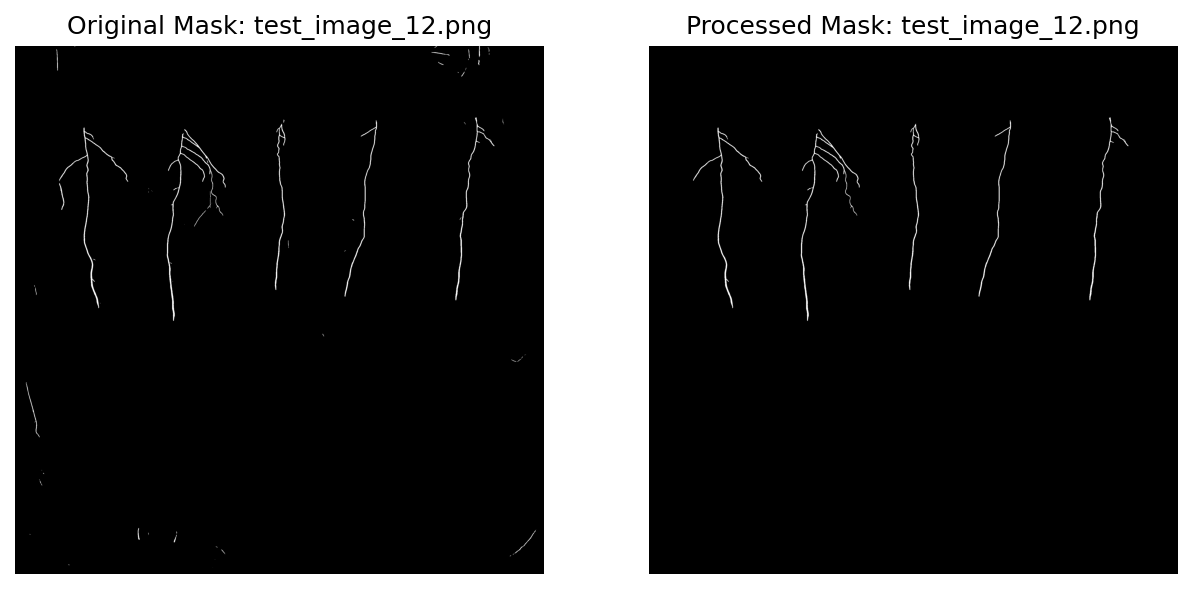

Processing mask for test_image_13.png...
Visualizing processed mask for test_image_13.png


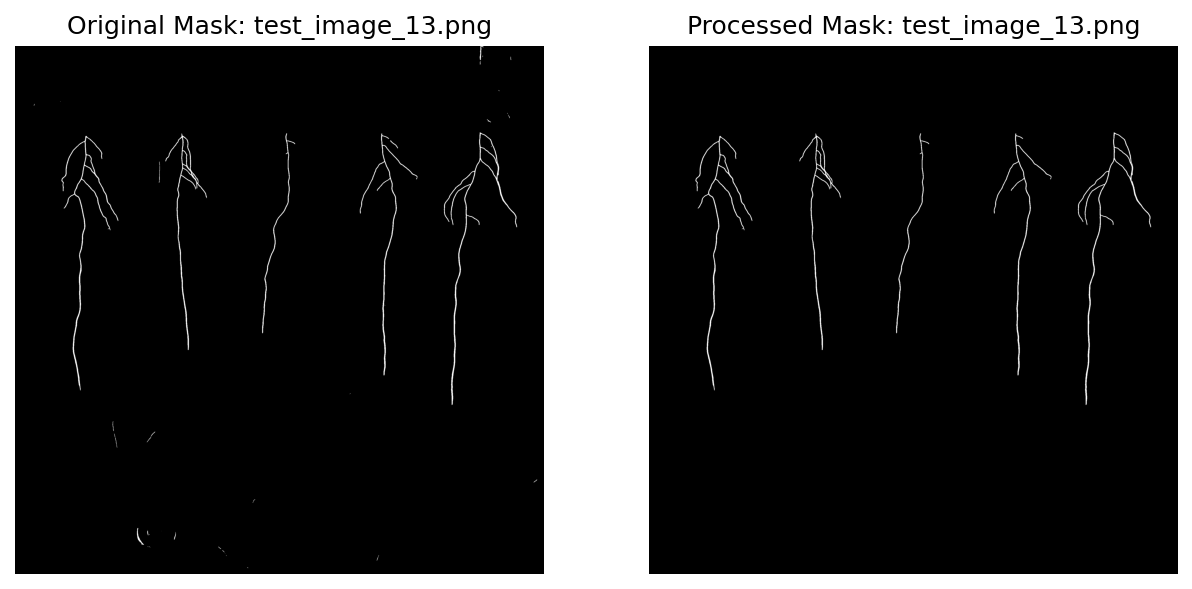

Processing mask for test_image_14.png...
Visualizing processed mask for test_image_14.png


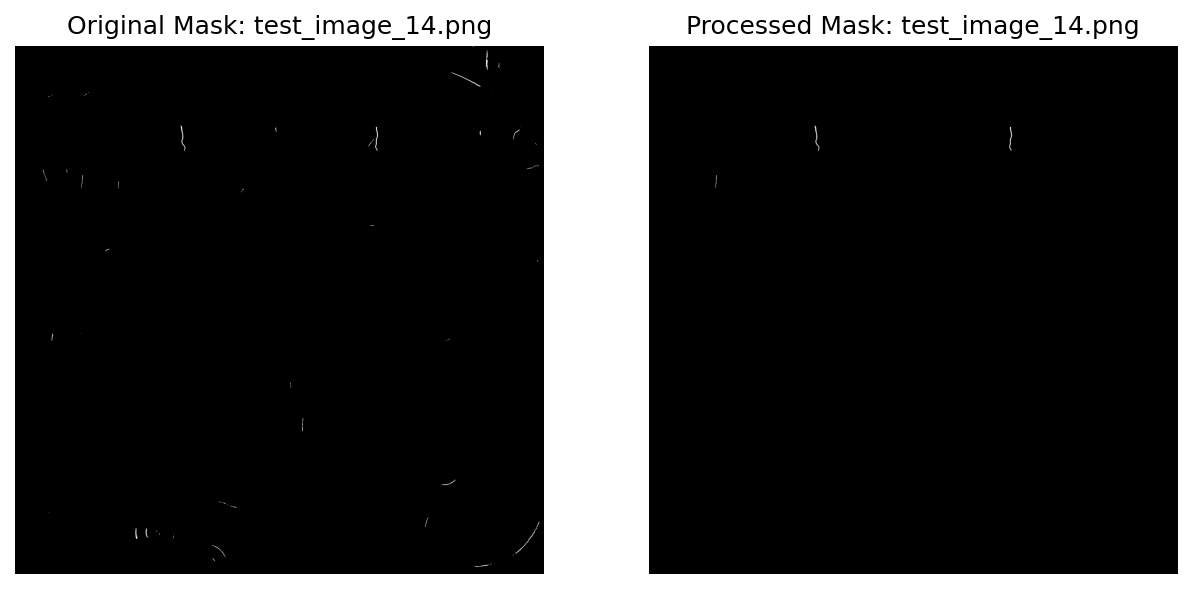

Processing mask for test_image_15.png...
Visualizing processed mask for test_image_15.png


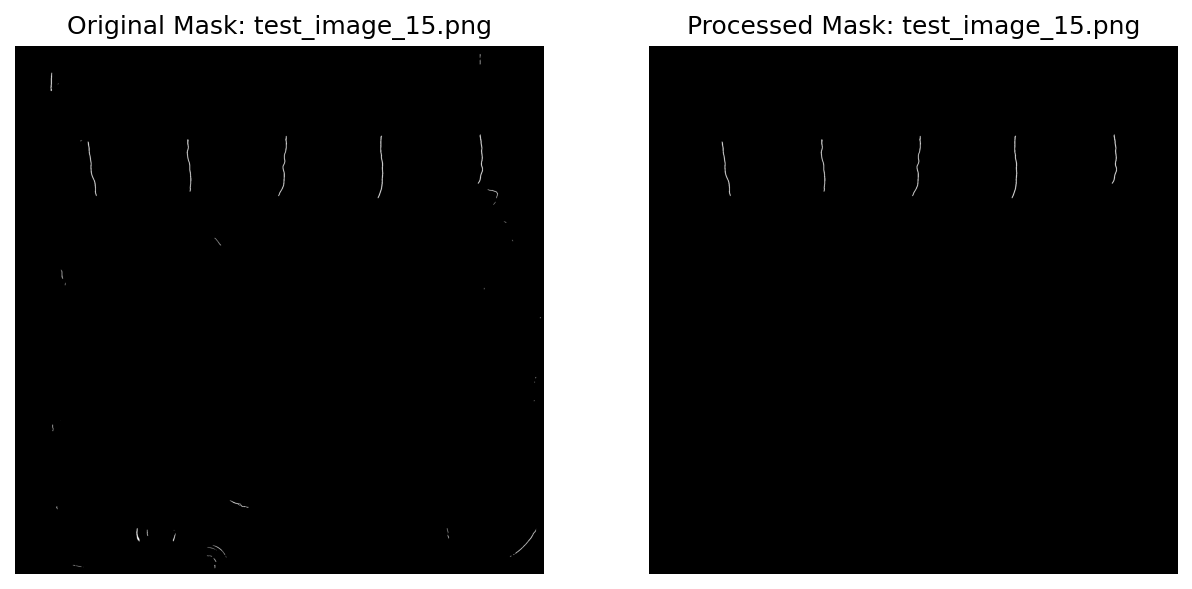

Processing mask for test_image_16.png...
Visualizing processed mask for test_image_16.png


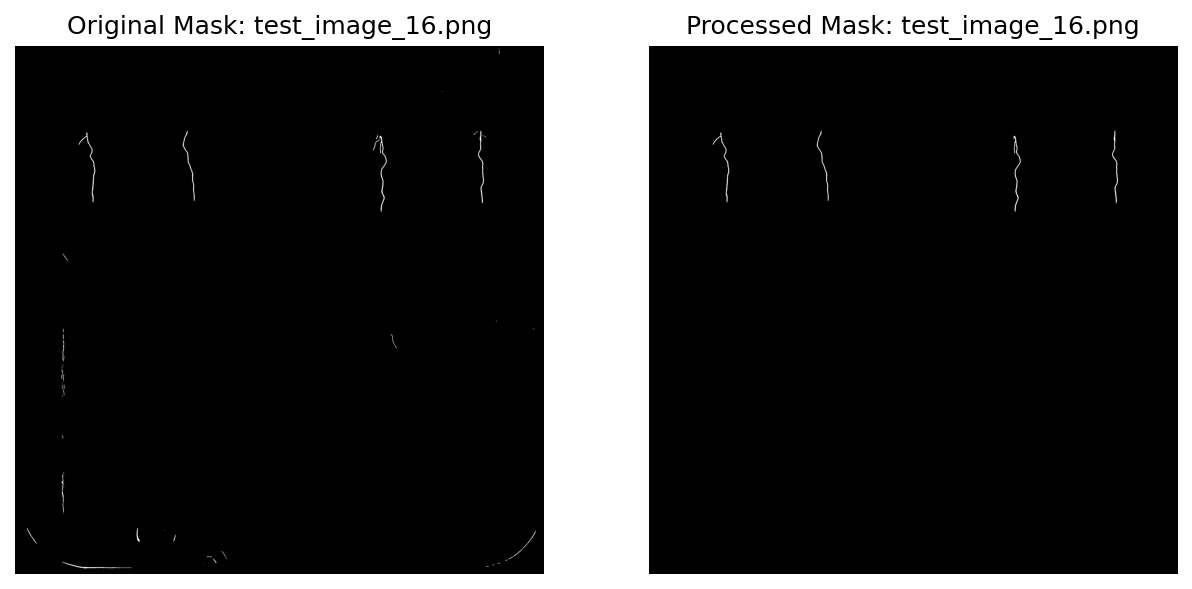

Processing mask for test_image_17.png...
Visualizing processed mask for test_image_17.png


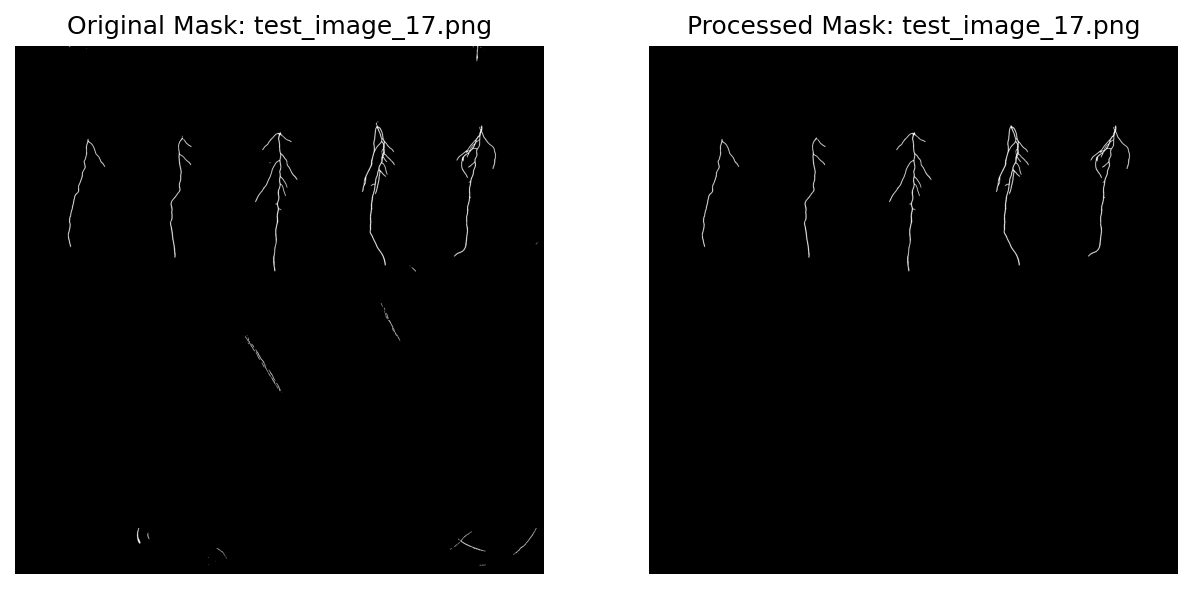

Processing mask for test_image_18.png...
Visualizing processed mask for test_image_18.png


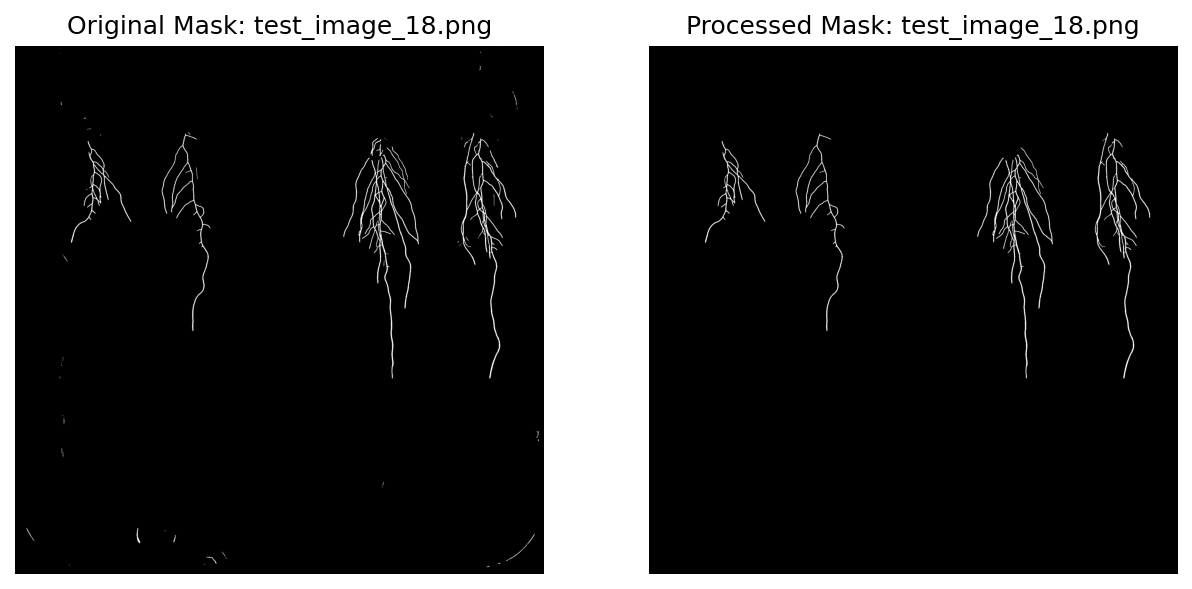

Processing mask for test_image_2.png...
Visualizing processed mask for test_image_2.png


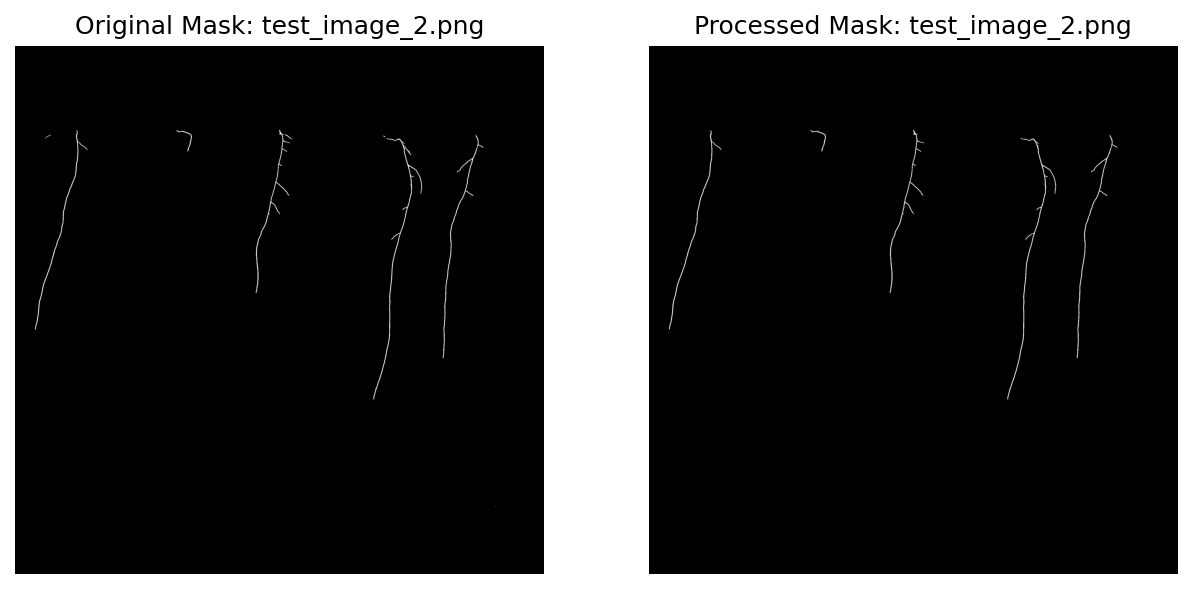

Processing mask for test_image_3.png...
Visualizing processed mask for test_image_3.png


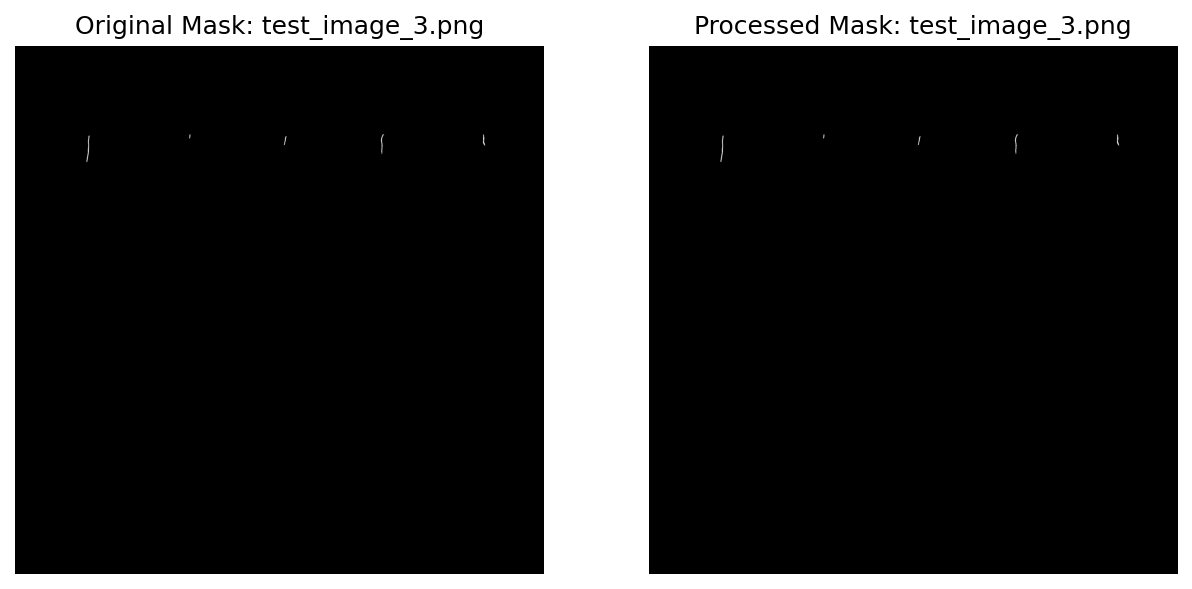

Processing mask for test_image_4.png...
Visualizing processed mask for test_image_4.png


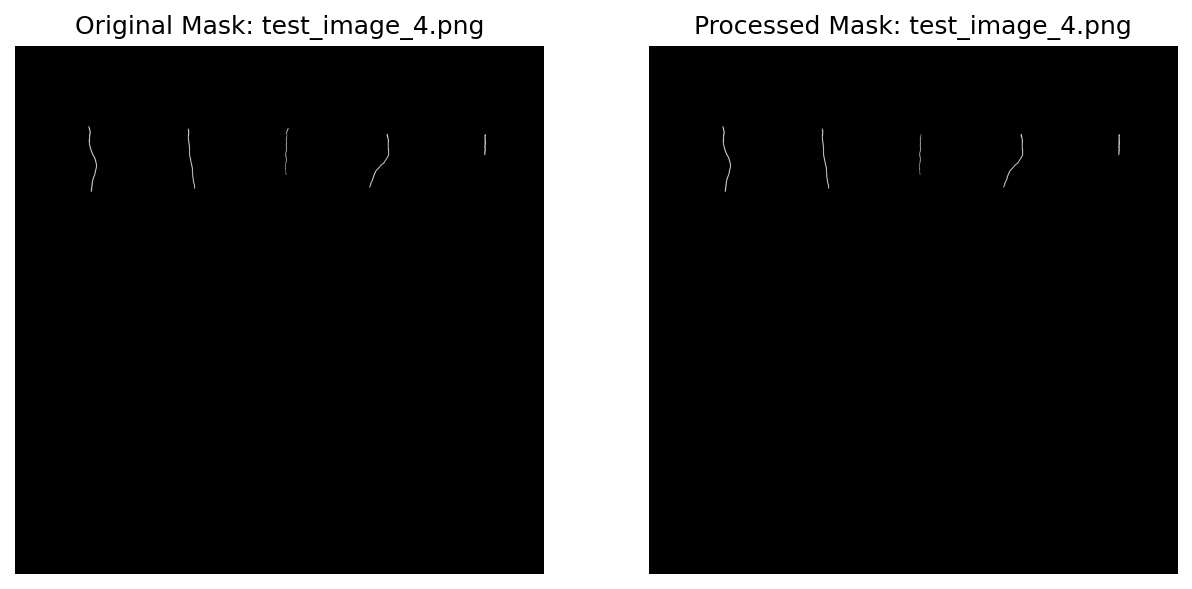

Processing mask for test_image_5.png...
Visualizing processed mask for test_image_5.png


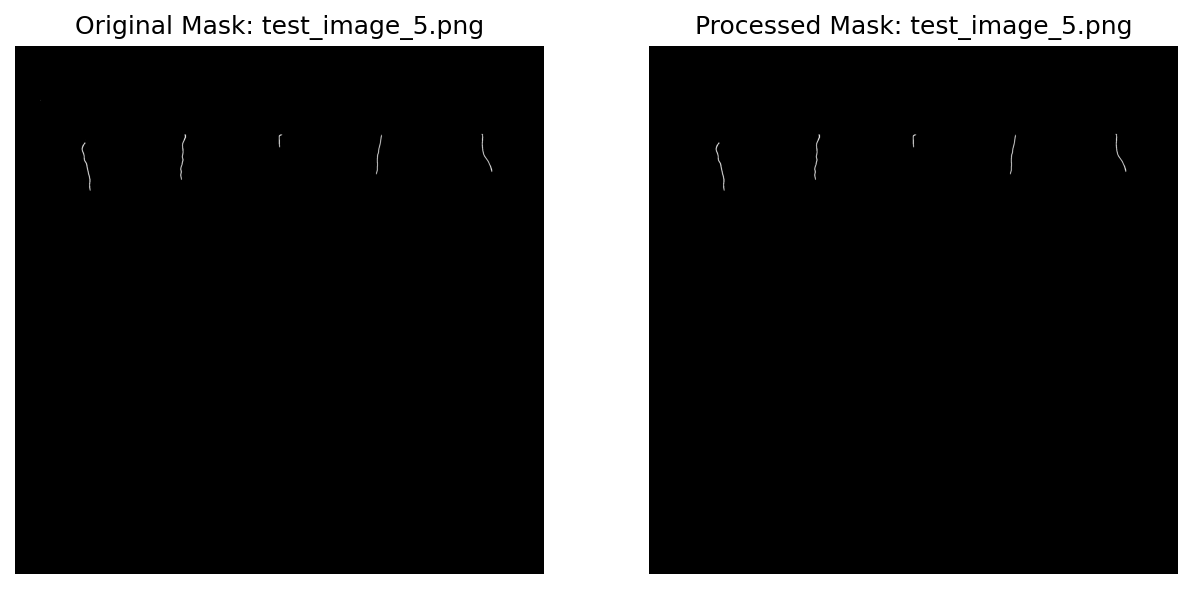

Processing mask for test_image_6.png...
Visualizing processed mask for test_image_6.png


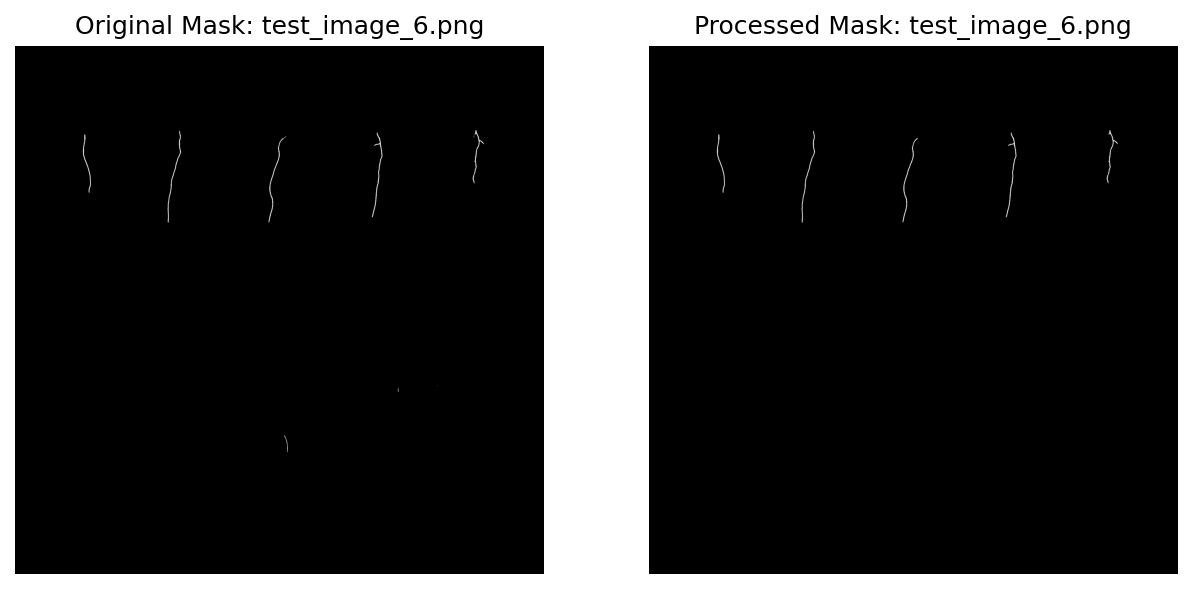

Processing mask for test_image_7.png...
Visualizing processed mask for test_image_7.png


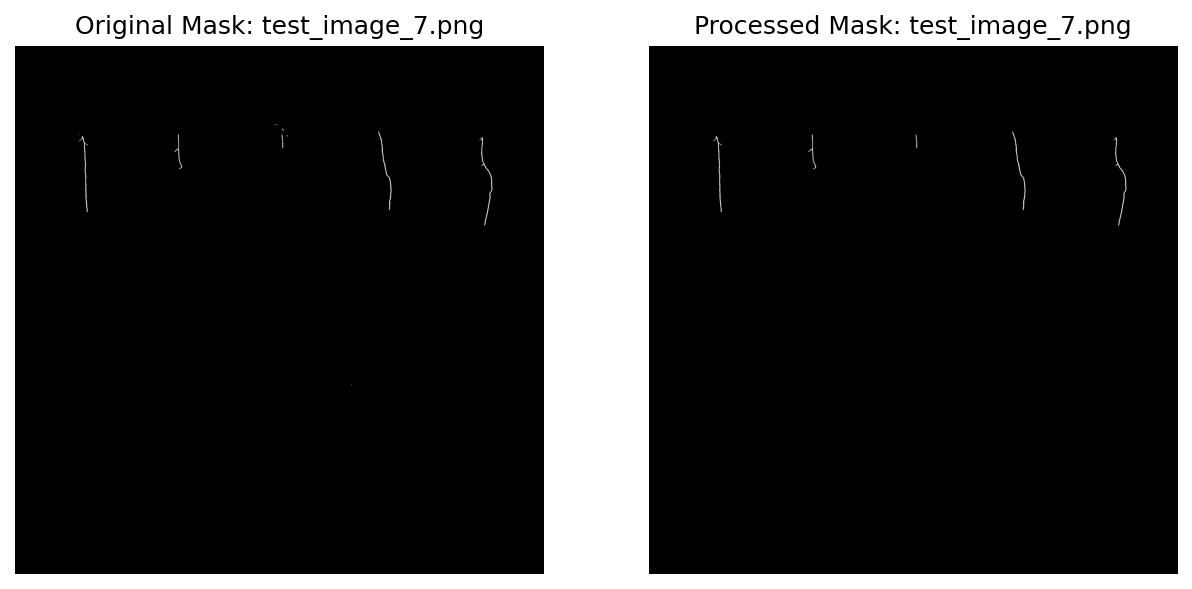

Processing mask for test_image_8.png...
Visualizing processed mask for test_image_8.png


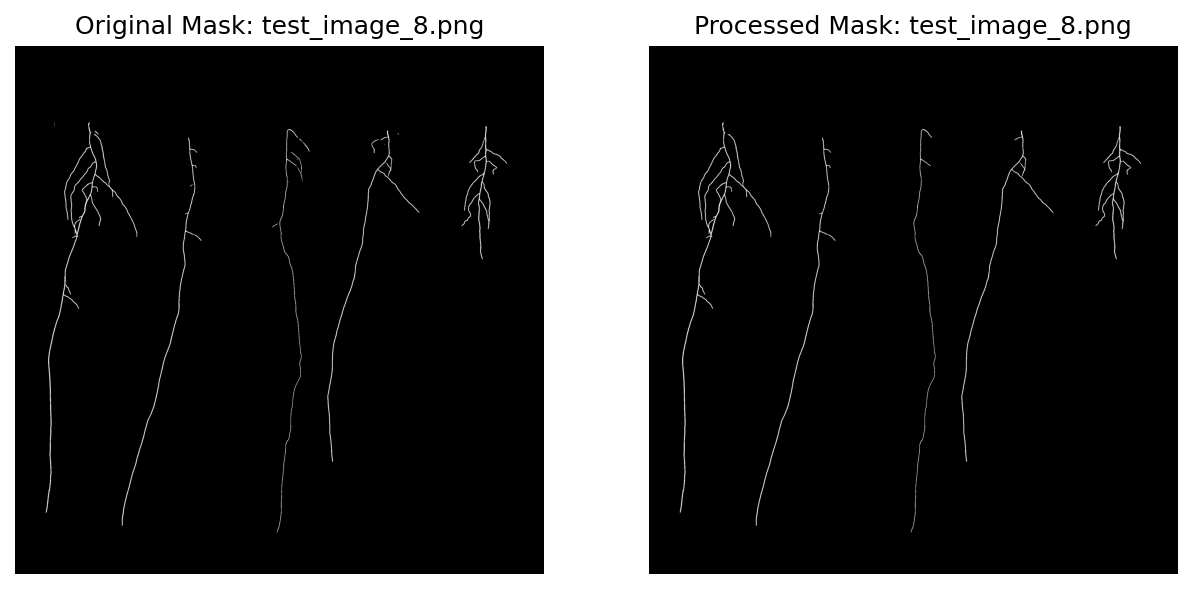

Processing mask for test_image_9.png...
Visualizing processed mask for test_image_9.png


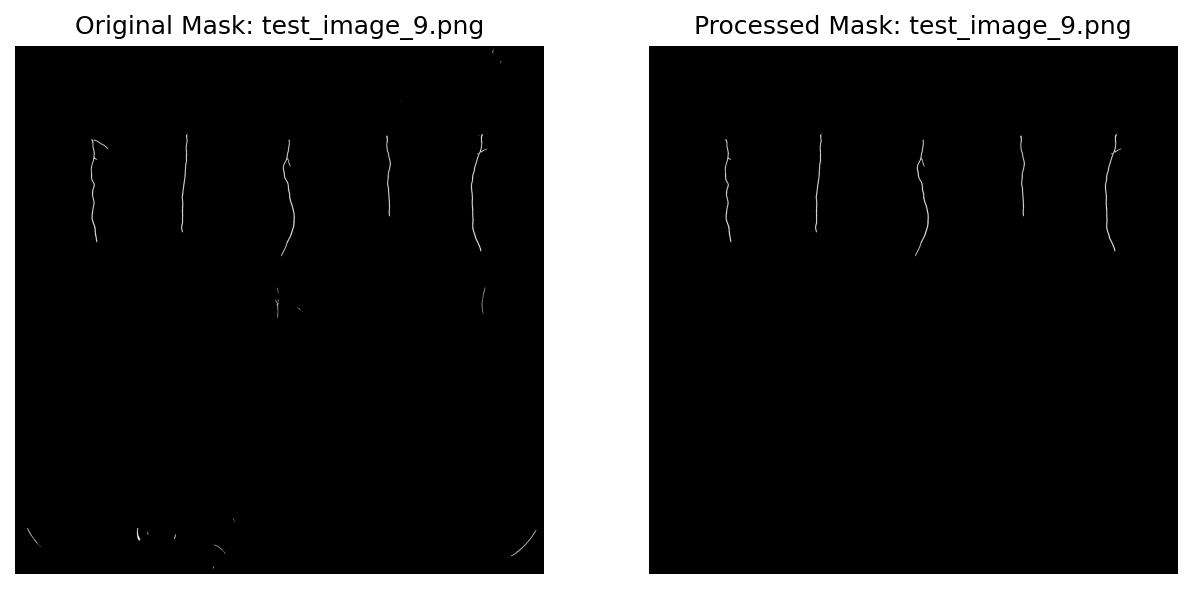

In [39]:
from skimage import morphology
import matplotlib.pyplot as plt
import numpy as np

def apply_remove_small_objects_per_section_with_top_constraint(predicted_results, section_data, size_threshold, top_y_threshold):
    """
    Apply dynamic sections (generated from create_dynamic_sections) to process masks, 
    removing small connected components in each section and retaining the largest component 
    in each section unless it fails both conditions: being below the size threshold and having its 
    top above the y-threshold.

    Parameters:
        predicted_results (dict): Dictionary with predicted masks and metadata.
        section_data (dict): Dictionary containing dynamic sections and cleaned masks.
        size_threshold (int): Minimum size of components to keep.
        top_y_threshold (int): Maximum y-coordinate for the top of a component to be kept.

    Returns:
        dict: Dictionary with IDs as keys and processed masks as values.
    """
    processed_masks = {}

    for file_name, data in predicted_results.items():
        print(f"Processing mask for {file_name}...")

        # Extract the predicted mask
        mask = data.get("predicted_mask")
        if mask is None:
            raise ValueError(f"No predicted mask found for {file_name}.")

        # Get dynamic sections for this file
        sections = section_data[file_name]["sections"]

        # Initialize a blank mask to store results
        processed_mask = np.zeros_like(mask, dtype=np.uint8)

        # Process each section
        for start_x, end_x in sections:
            # Extract the section of the mask
            section_mask = mask[:, start_x:end_x]

            # Label connected components in the section
            labeled_section, num_labels = morphology.label(section_mask > 0, connectivity=2, return_num=True)

            # Calculate sizes and topmost y-coordinates of connected components
            component_info = []
            for label in range(1, num_labels + 1):
                component = (labeled_section == label)
                size = component.sum()
                top_y = np.min(np.where(component)[0]) if size > 0 else None
                component_info.append((label, size, top_y))

            # Find the largest component
            largest_component_label = max(component_info, key=lambda x: x[1])[0] if component_info else None

            # Retain components based on size, top_y, or if it is the largest
            for label, size, top_y in component_info:
                if (
                    (size >= size_threshold or label == largest_component_label)  # Pass size or largest check
                    and (top_y is not None and top_y < top_y_threshold)  # Pass top y constraint
                ):
                    processed_mask[:, start_x:end_x][labeled_section == label] = 255

        processed_masks[file_name] = processed_mask

        # Visualize the original and processed mask
        print(f"Visualizing processed mask for {file_name}")
        f, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
        ax[0].imshow(mask, cmap='gray')
        ax[0].axis('off')
        ax[0].set_title(f'Original Mask: {file_name}')
        ax[1].imshow(processed_mask, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title(f'Processed Mask: {file_name}')
        plt.show()

    return processed_masks



# Define the size threshold, top_y_threshold, and number of sections
size_threshold = 2000
top_y_threshold = 1000  # Adjust this threshold manually
num_sections = 5

# Apply removal per section with top constraint and retain the largest component
processed_masks = apply_remove_small_objects_per_section_with_top_constraint(
    predicted_results, section_data, size_threshold=2000, top_y_threshold=1000
)


Processing mask for test_image_1.png...
Visualizing mask filtering for test_image_1.png


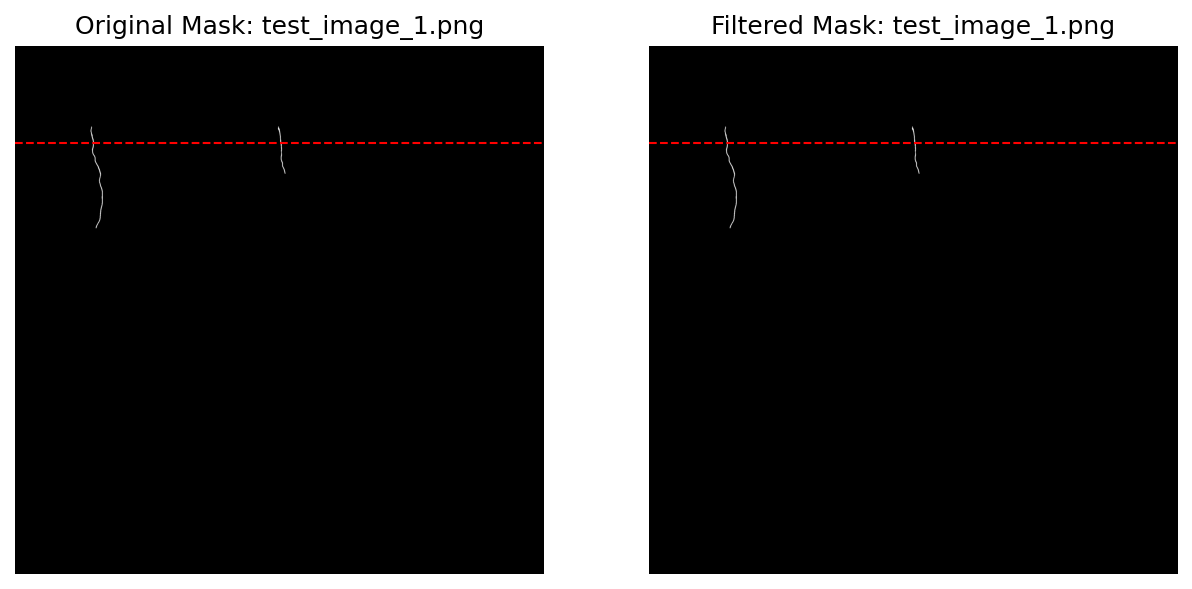

Processing mask for test_image_10.png...
Visualizing mask filtering for test_image_10.png


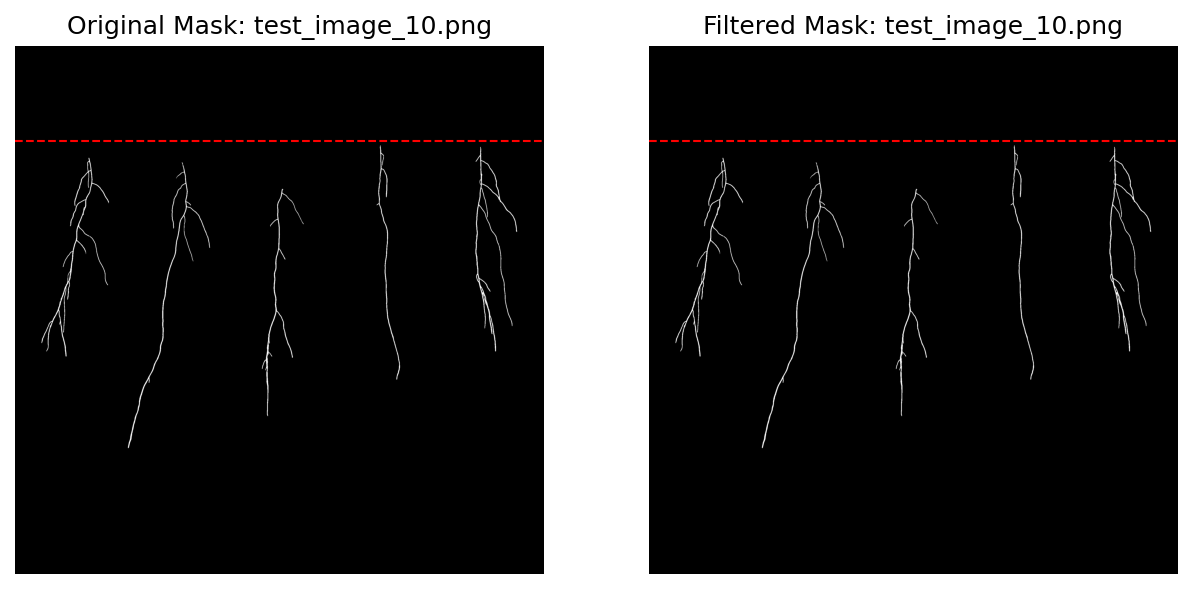

Processing mask for test_image_11.png...
Visualizing mask filtering for test_image_11.png


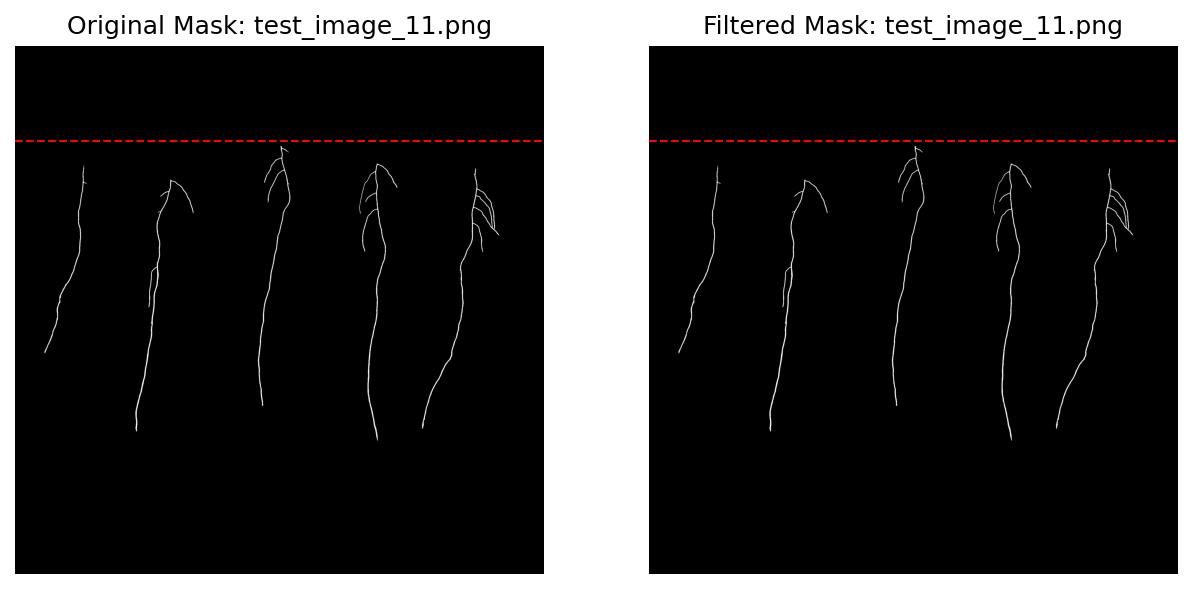

Processing mask for test_image_12.png...
Visualizing mask filtering for test_image_12.png


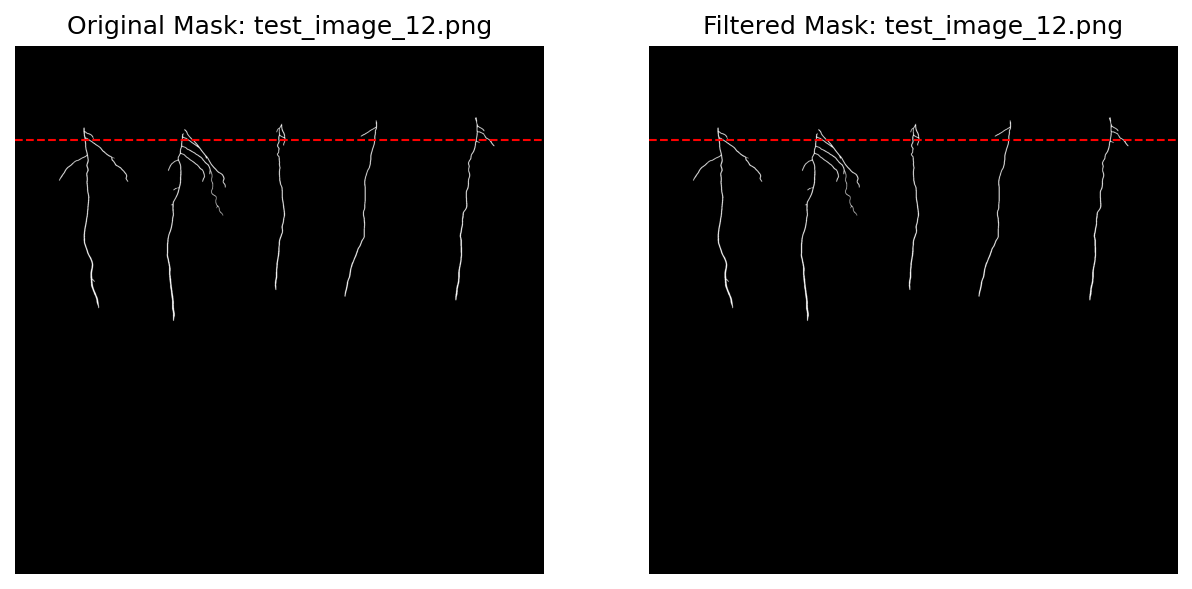

Processing mask for test_image_13.png...
Visualizing mask filtering for test_image_13.png


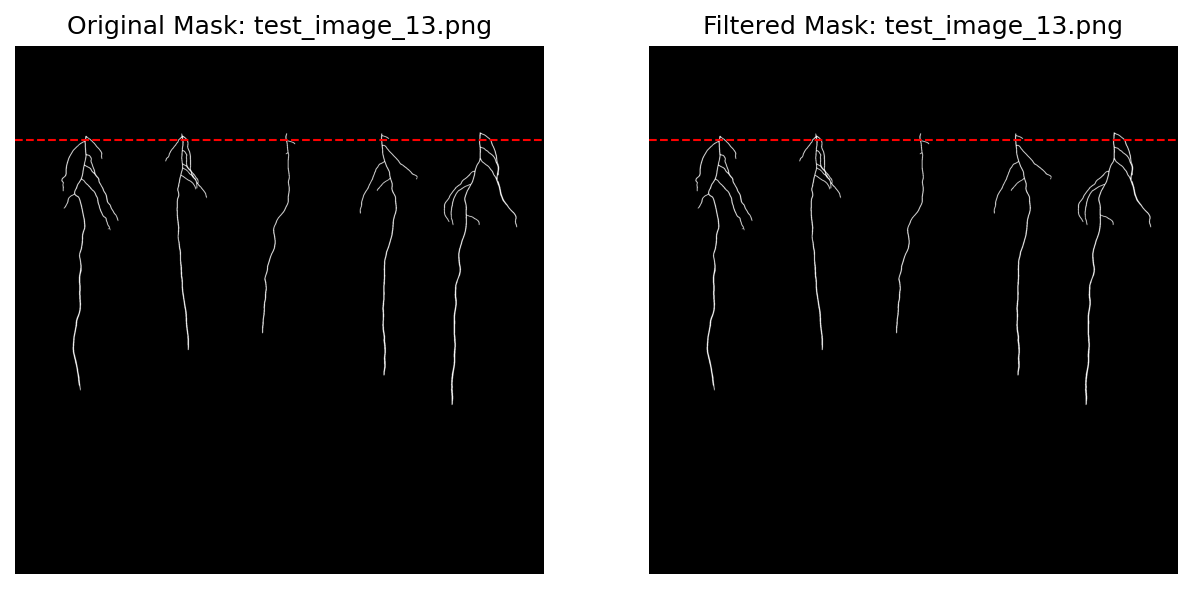

Processing mask for test_image_14.png...
Visualizing mask filtering for test_image_14.png


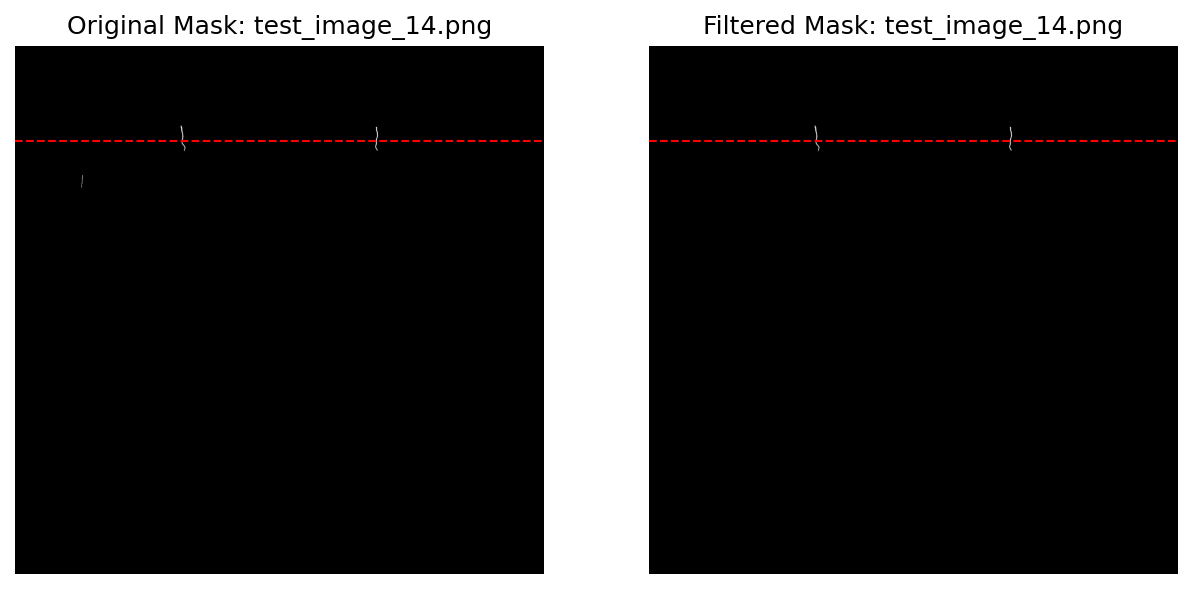

Processing mask for test_image_15.png...
Visualizing mask filtering for test_image_15.png


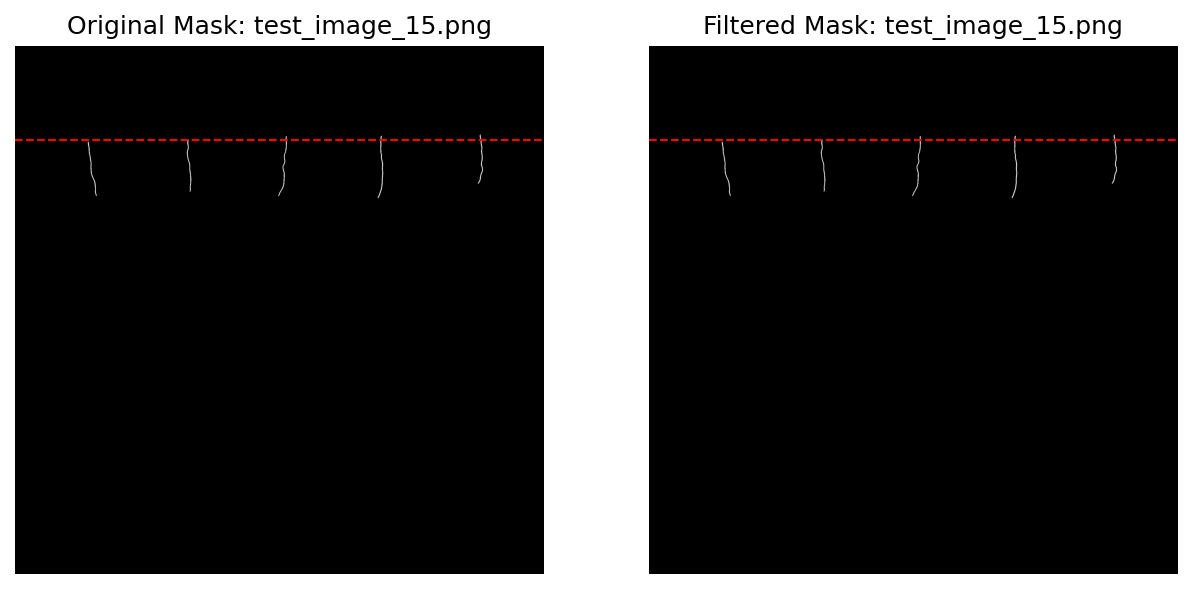

Processing mask for test_image_16.png...
Visualizing mask filtering for test_image_16.png


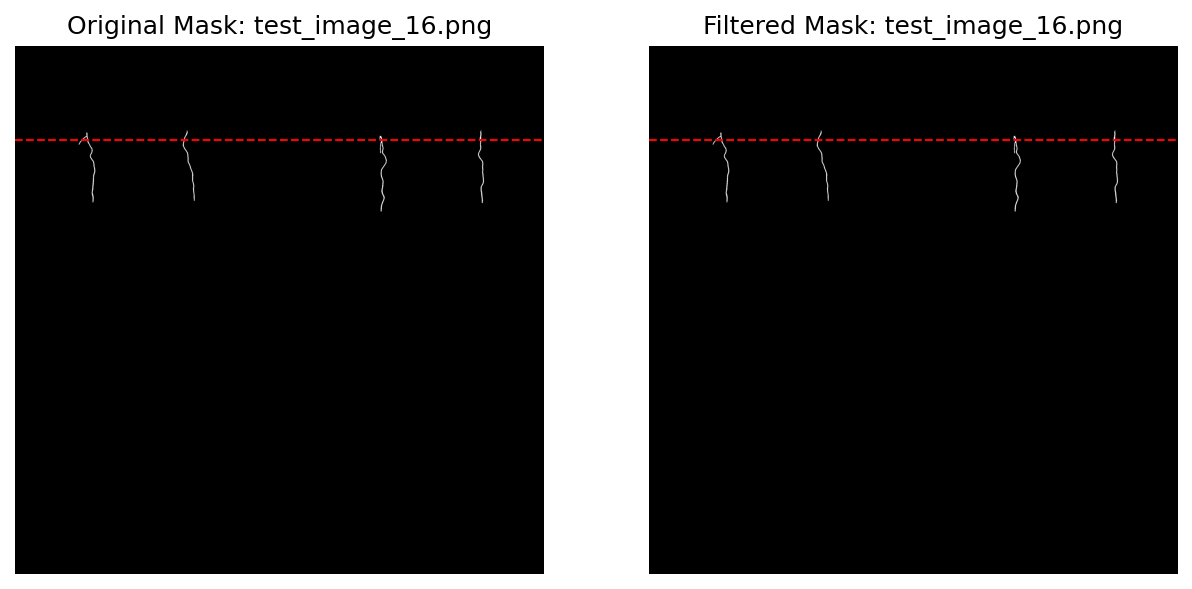

Processing mask for test_image_17.png...
Visualizing mask filtering for test_image_17.png


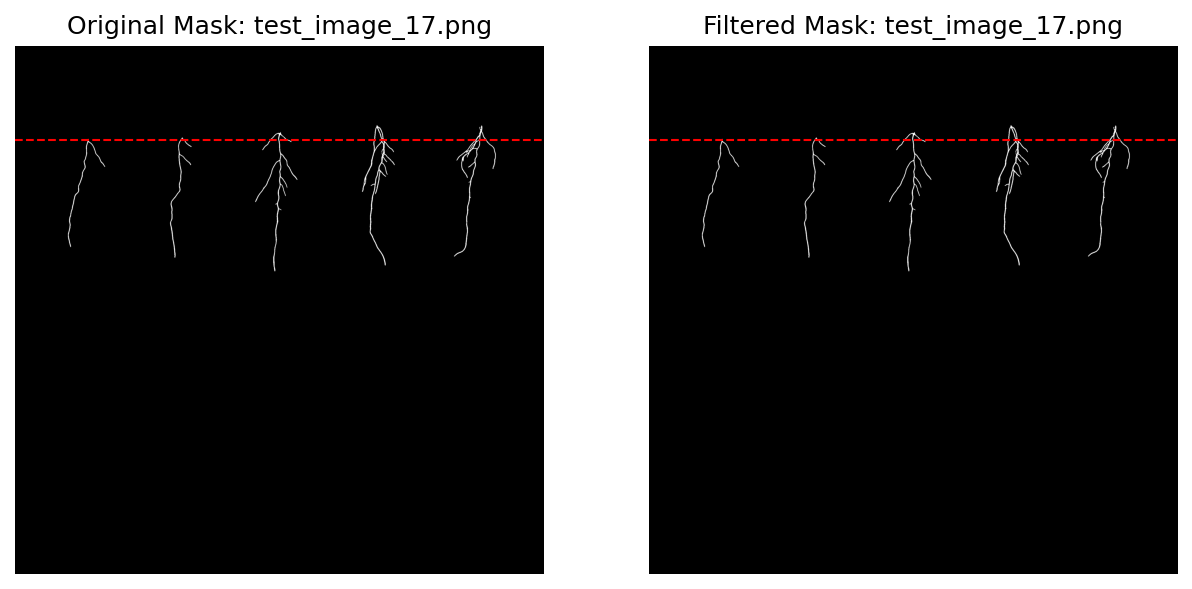

Processing mask for test_image_18.png...
Visualizing mask filtering for test_image_18.png


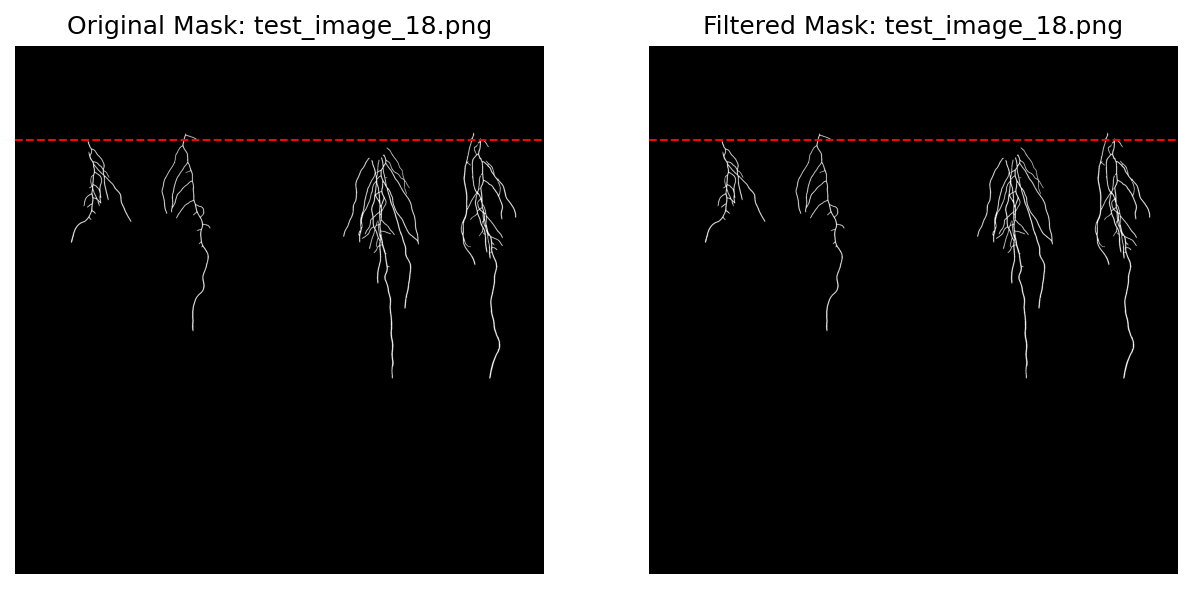

Processing mask for test_image_2.png...
Visualizing mask filtering for test_image_2.png


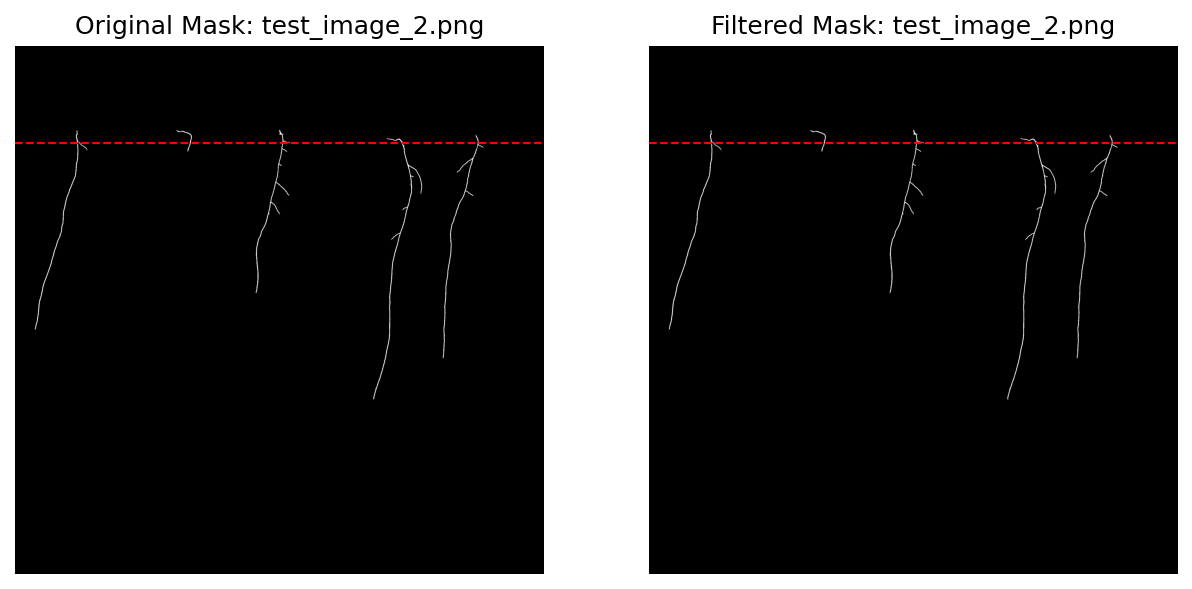

Processing mask for test_image_3.png...
Visualizing mask filtering for test_image_3.png


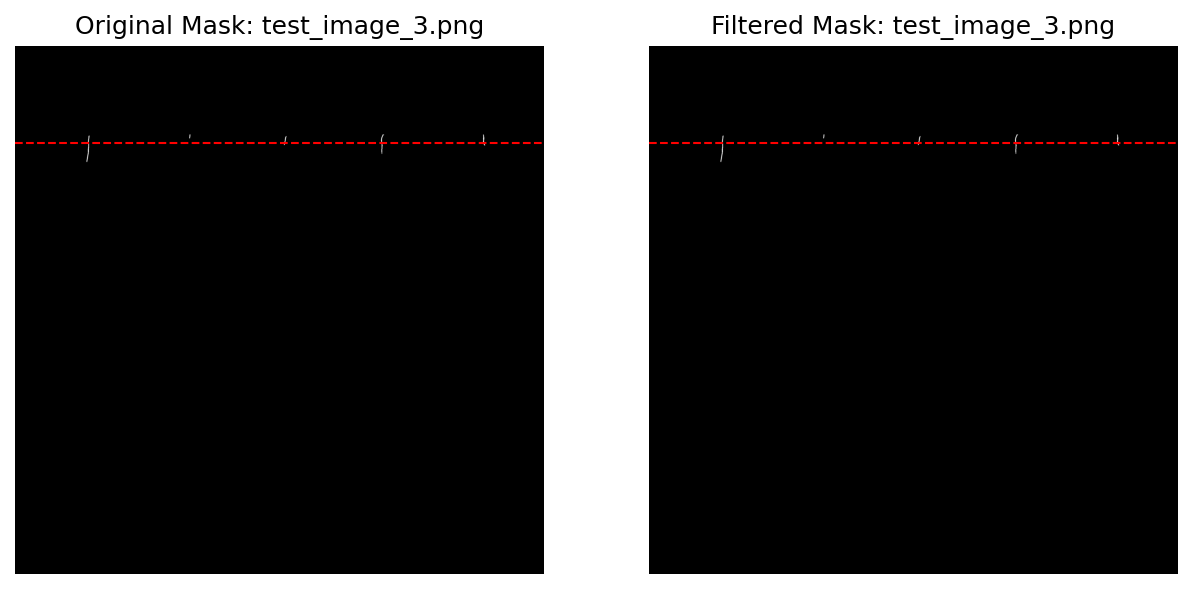

Processing mask for test_image_4.png...
Visualizing mask filtering for test_image_4.png


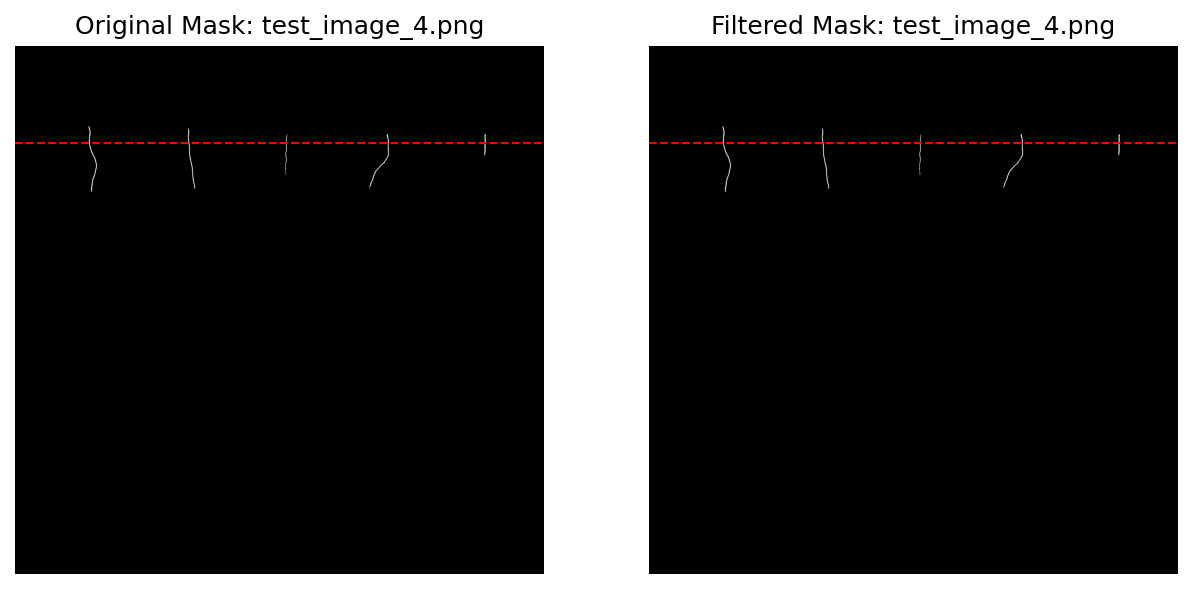

Processing mask for test_image_5.png...
Visualizing mask filtering for test_image_5.png


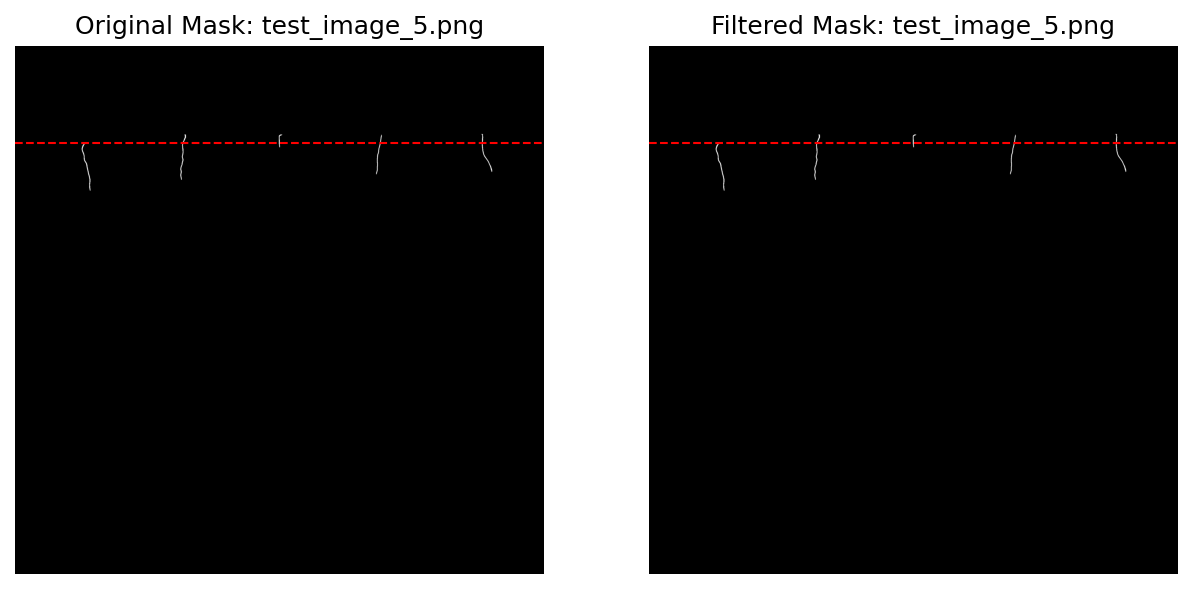

Processing mask for test_image_6.png...
Visualizing mask filtering for test_image_6.png


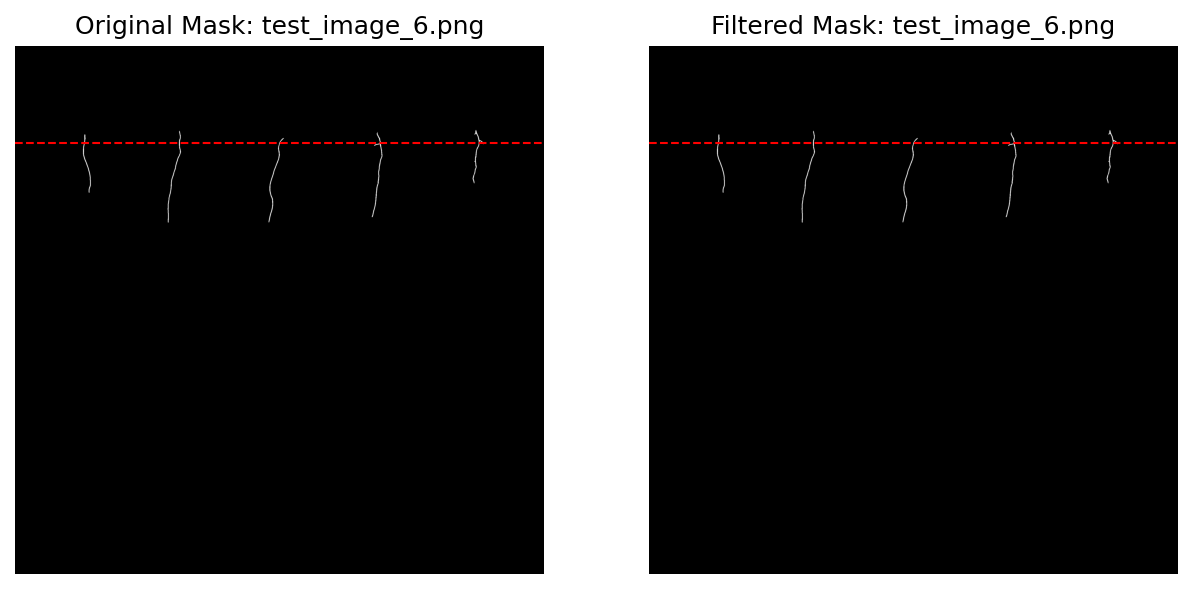

Processing mask for test_image_7.png...
Visualizing mask filtering for test_image_7.png


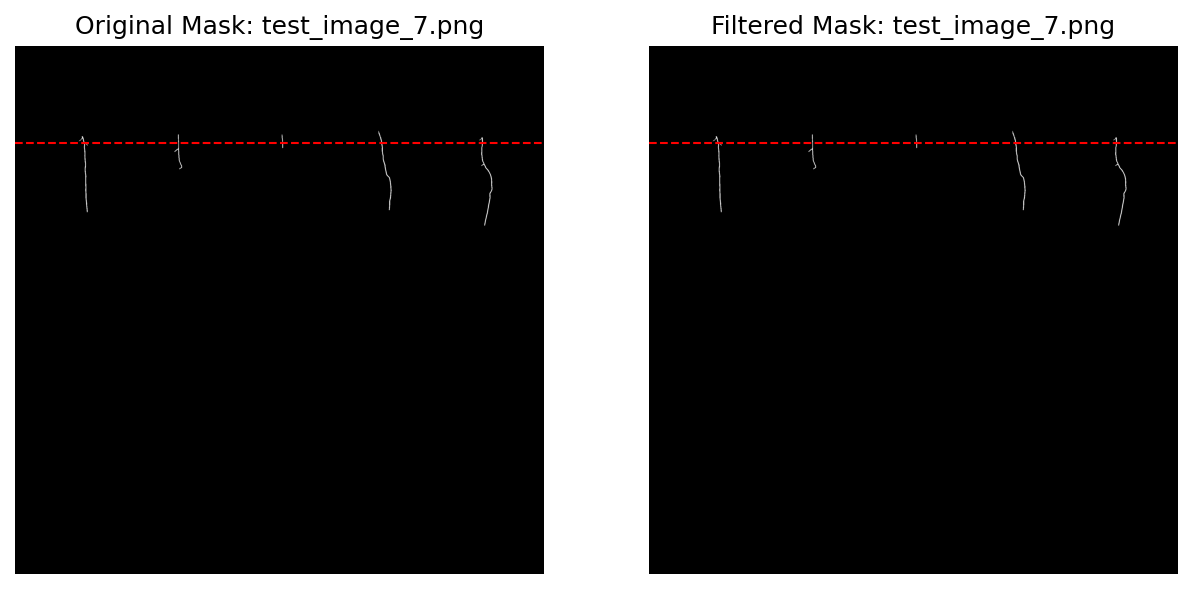

Processing mask for test_image_8.png...
Visualizing mask filtering for test_image_8.png


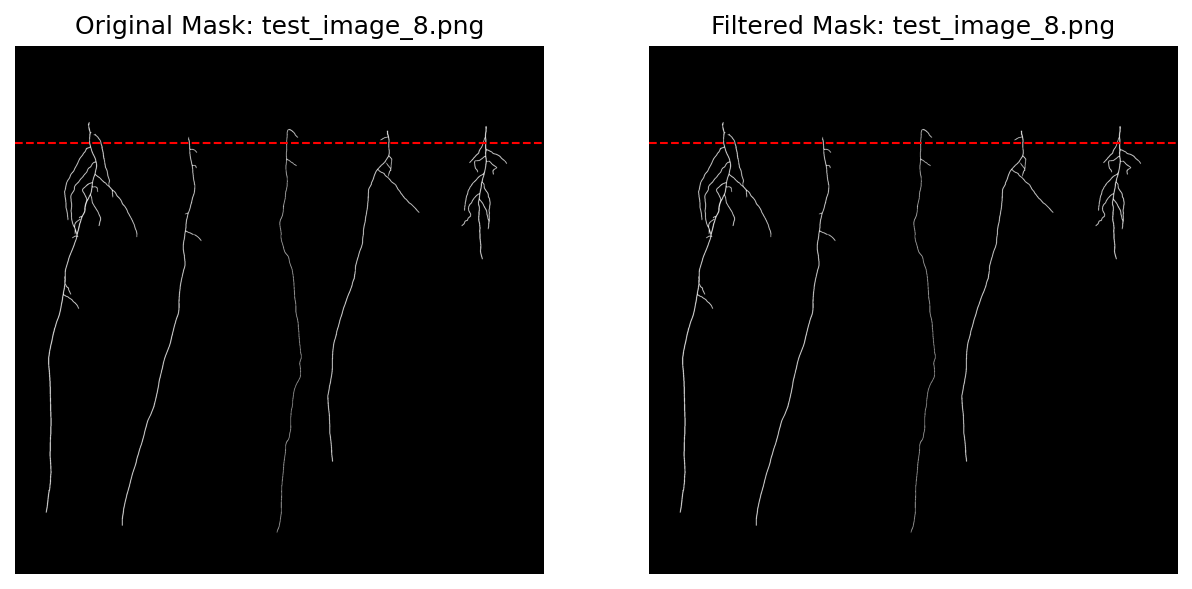

Processing mask for test_image_9.png...
Visualizing mask filtering for test_image_9.png


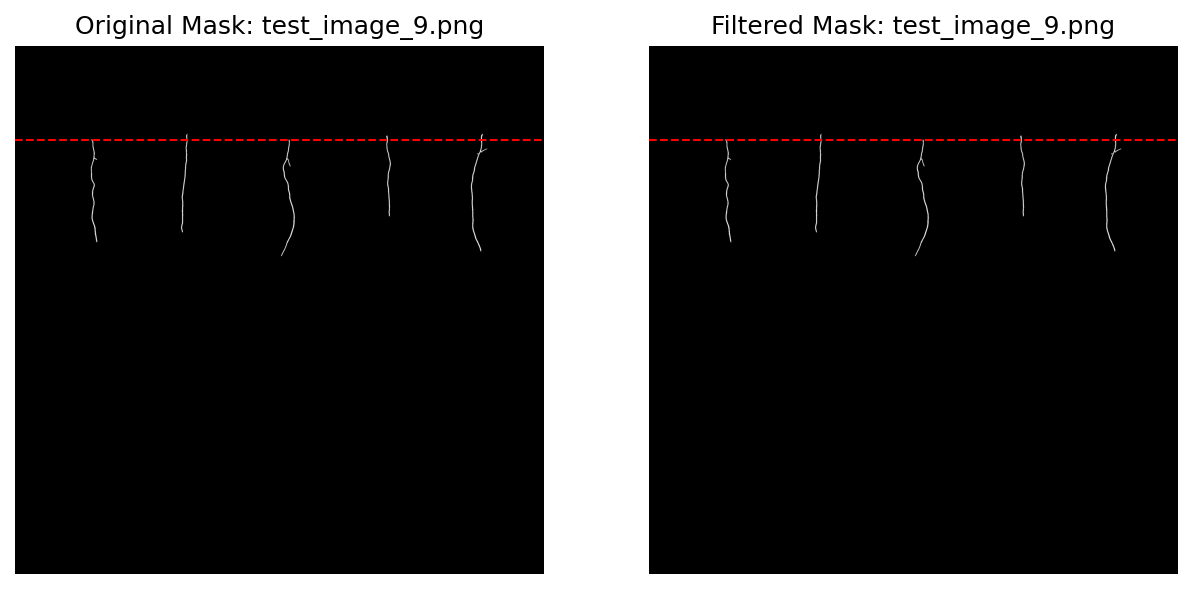

In [40]:
from skimage import morphology
import matplotlib.pyplot as plt
import numpy as np

def remove_small_and_low_objects(processed_masks, size_threshold=20, y_threshold=500):
    """
    Remove elements that are below a specified y-threshold and smaller than a size threshold.
    Visualizes the original and filtered masks with the y-threshold line.

    Parameters:
        processed_masks (dict): Dictionary of processed masks with IDs as keys.
        size_threshold (int): Minimum size of components to keep.
        y_threshold (int): Maximum y-coordinate for the top of a component to be kept.

    Returns:
        dict: Dictionary with IDs as keys and filtered masks as values.
    """
    filtered_masks = {}

    for file_name, mask in processed_masks.items():
        print(f"Processing mask for {file_name}...")

        # Initialize a blank mask to store results
        h, w = mask.shape
        filtered_mask = np.zeros_like(mask, dtype=np.uint8)

        # Label connected components in the mask
        labeled_mask, num_labels = morphology.label(mask > 0, connectivity=2, return_num=True)

        # Process each labeled component
        for label in range(1, num_labels + 1):
            component = (labeled_mask == label)
            size = component.sum()
            top_y = np.min(np.where(component)[0]) if size > 0 else None

            # Retain components that either:
            # - Have size >= size_threshold
            # - Have top_y < y_threshold
            if size >= size_threshold or (top_y is not None and top_y < y_threshold):
                filtered_mask[component] = 255

        filtered_masks[file_name] = filtered_mask

        # Visualize the original and filtered masks with y-threshold line
        print(f"Visualizing mask filtering for {file_name}")
        f, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
        ax[0].imshow(mask, cmap='gray')
        ax[0].axhline(y=y_threshold, color='red', linestyle='--', linewidth=1)  # Plot y-threshold
        ax[0].axis('off')
        ax[0].set_title(f'Original Mask: {file_name}')
        ax[1].imshow(filtered_mask, cmap='gray')
        ax[1].axhline(y=y_threshold, color='red', linestyle='--', linewidth=1)  # Plot y-threshold
        ax[1].axis('off')
        ax[1].set_title(f'Filtered Mask: {file_name}')
        plt.show()

    return filtered_masks


# Define thresholds
size_threshold = 200
y_threshold = 500

# Apply the function
filtered_masks = remove_small_and_low_objects(processed_masks, size_threshold, y_threshold)


### Final closing:

Preprocessing mask for test_image_1.png with morphological closing...


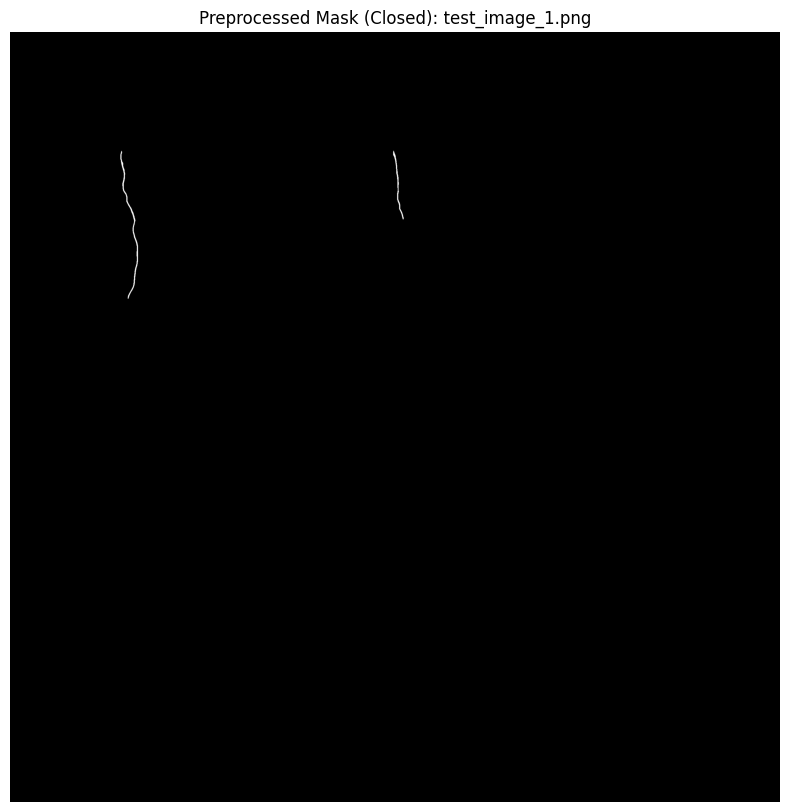

Preprocessing mask for test_image_10.png with morphological closing...


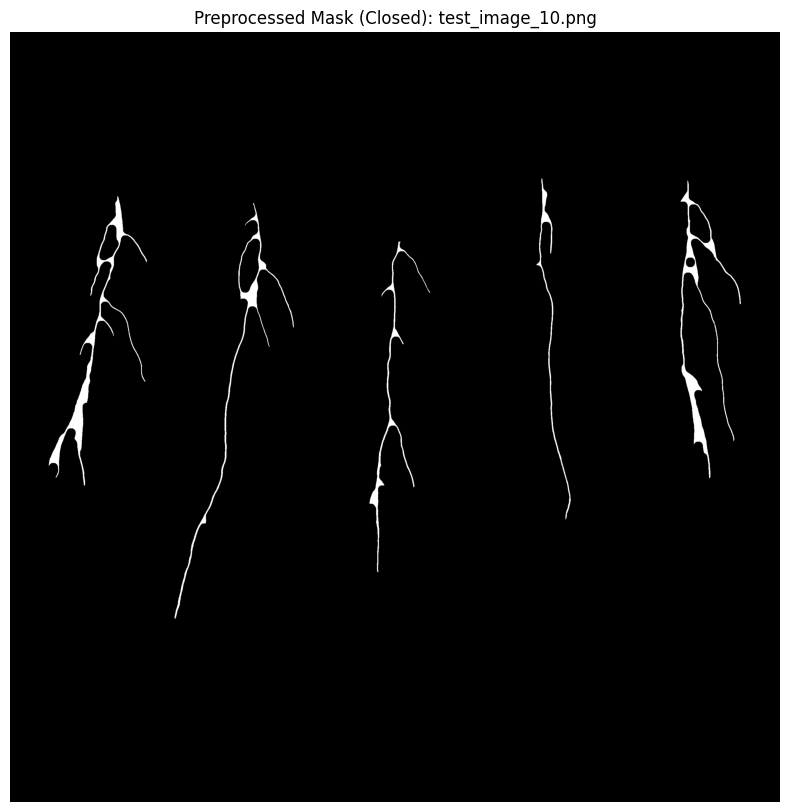

Preprocessing mask for test_image_11.png with morphological closing...


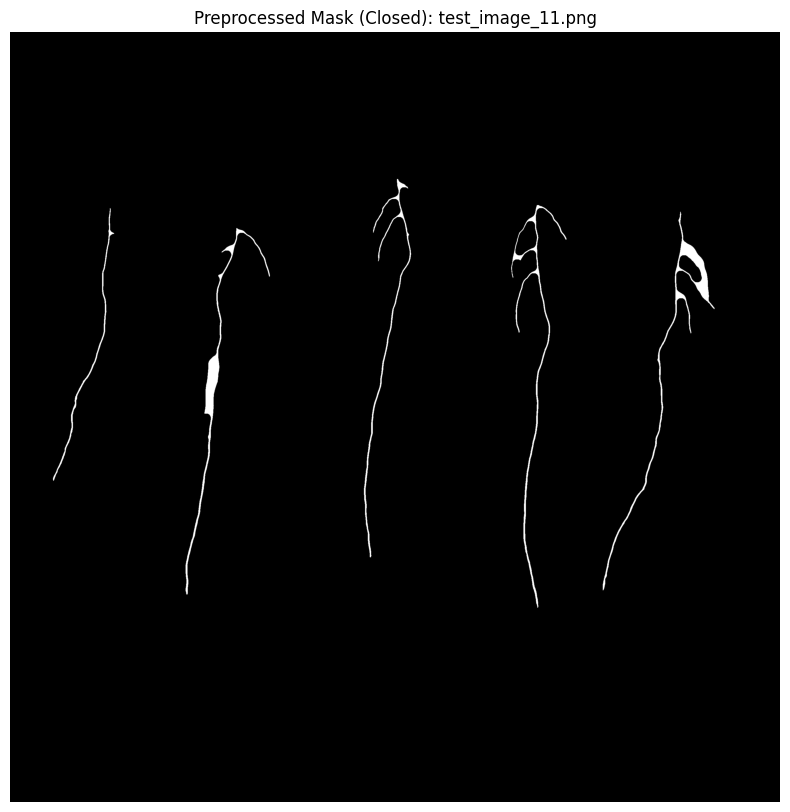

Preprocessing mask for test_image_12.png with morphological closing...


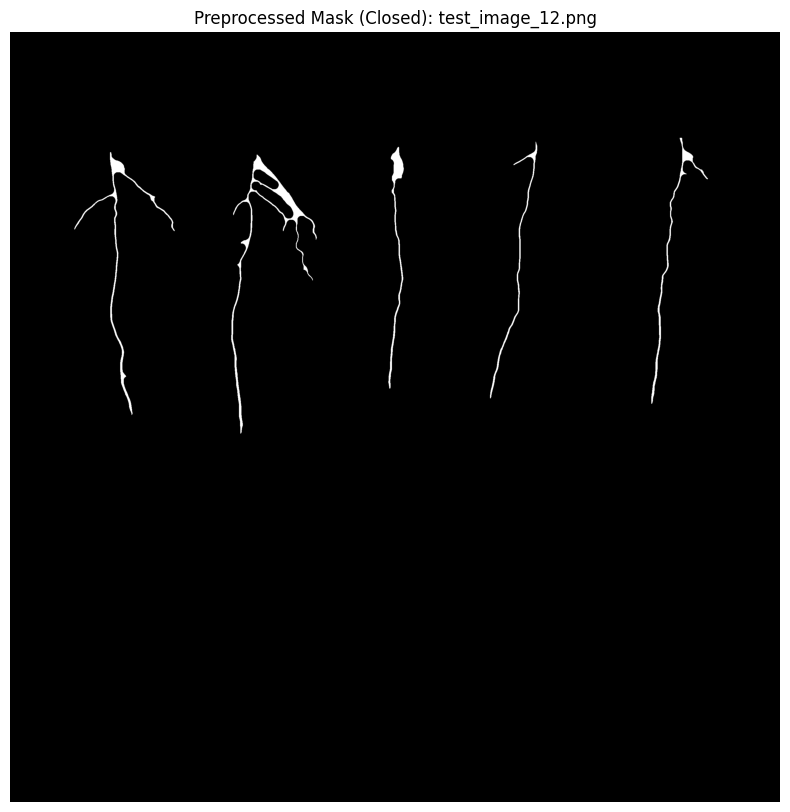

Preprocessing mask for test_image_13.png with morphological closing...


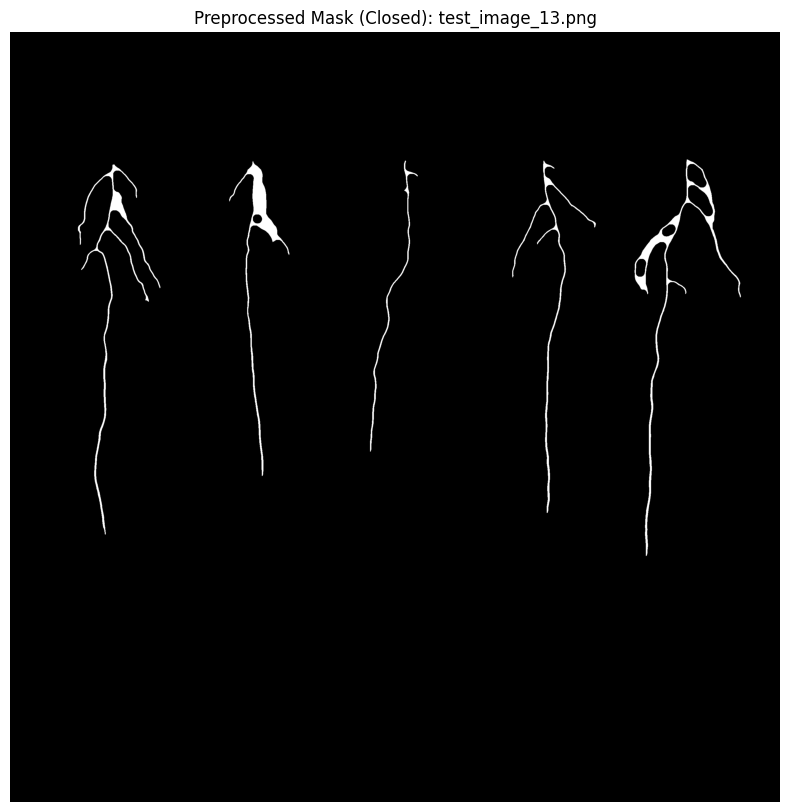

Preprocessing mask for test_image_14.png with morphological closing...


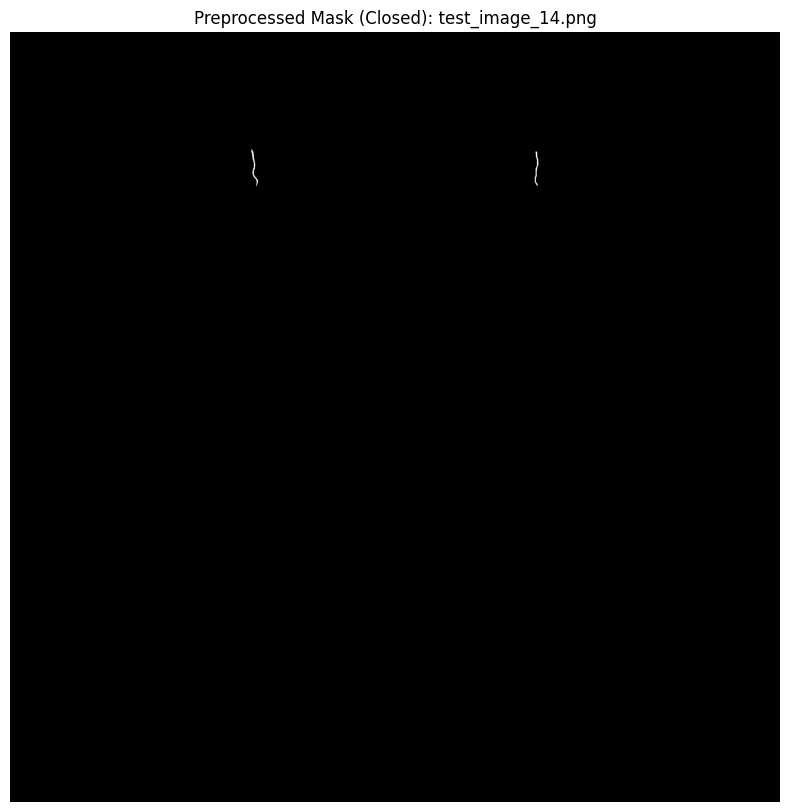

Preprocessing mask for test_image_15.png with morphological closing...


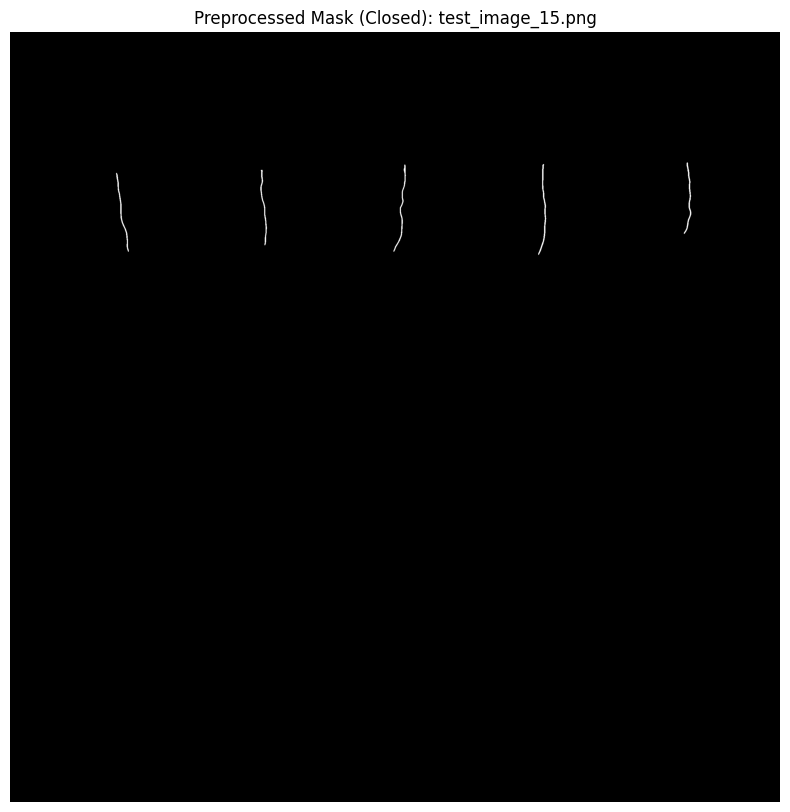

Preprocessing mask for test_image_16.png with morphological closing...


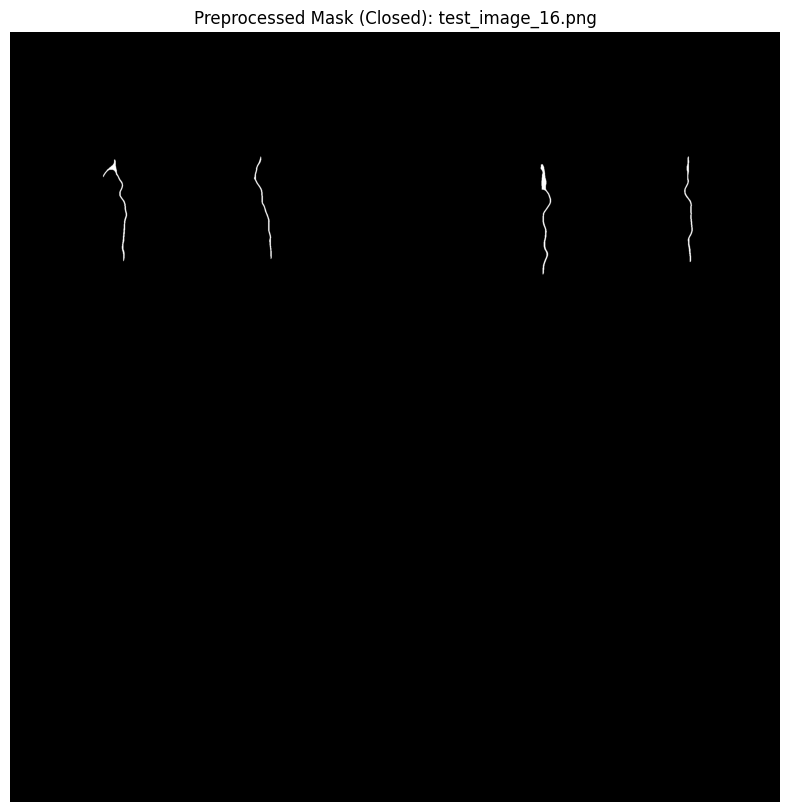

Preprocessing mask for test_image_17.png with morphological closing...


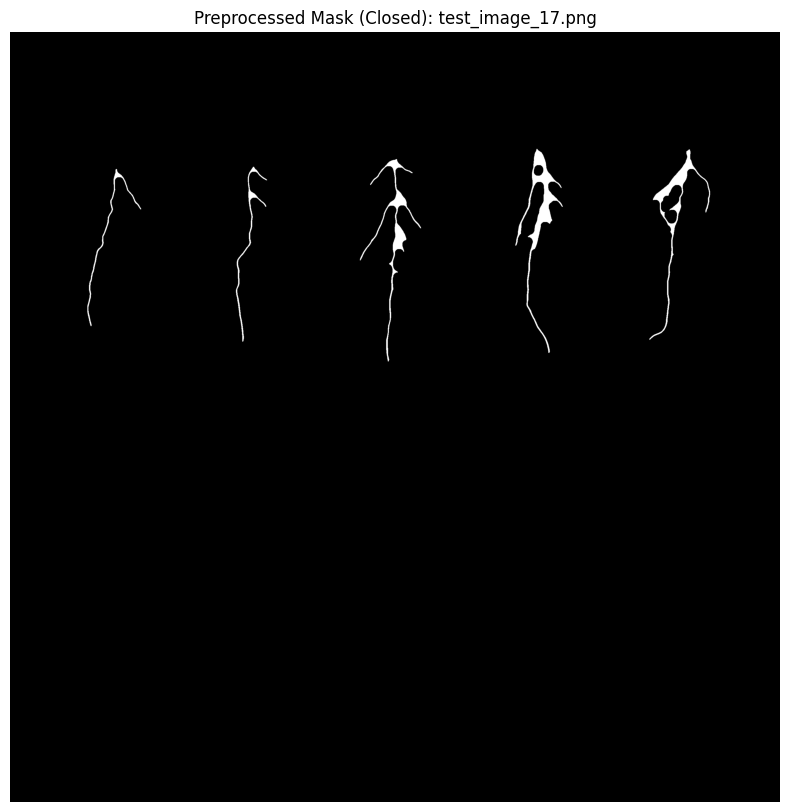

Preprocessing mask for test_image_18.png with morphological closing...


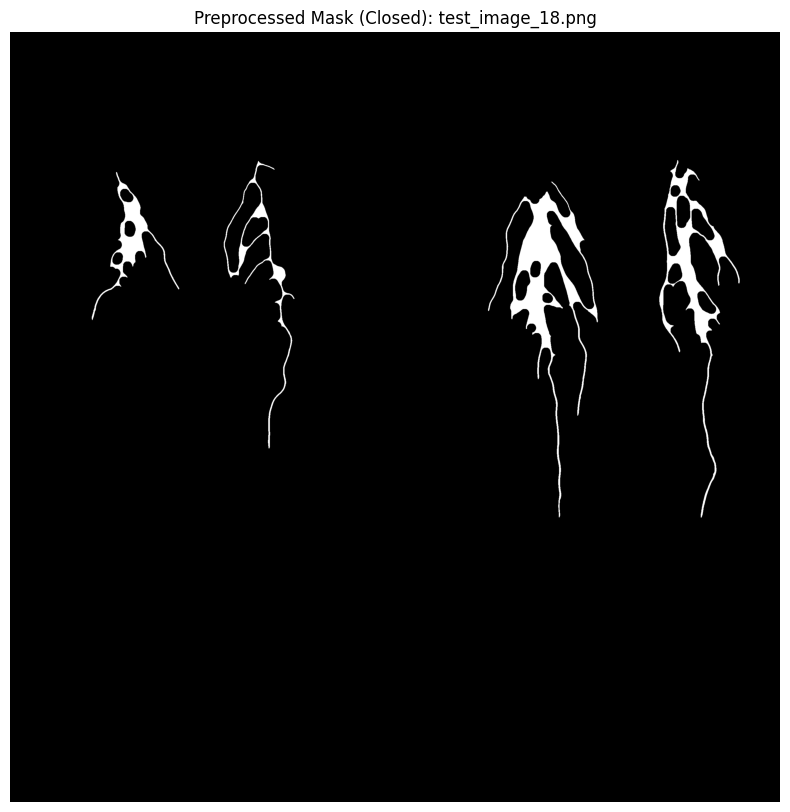

Preprocessing mask for test_image_2.png with morphological closing...


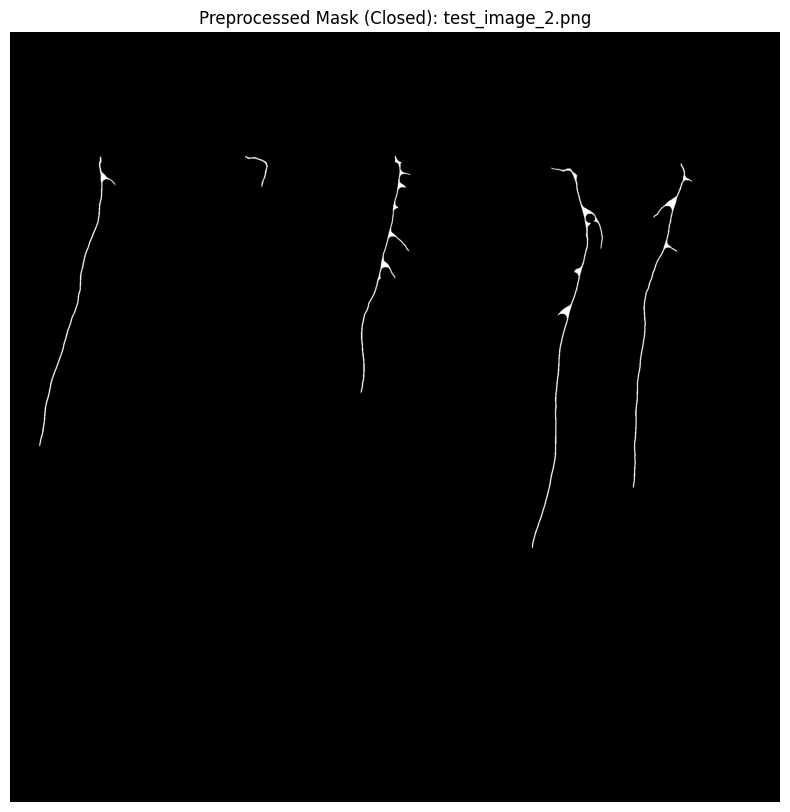

Preprocessing mask for test_image_3.png with morphological closing...


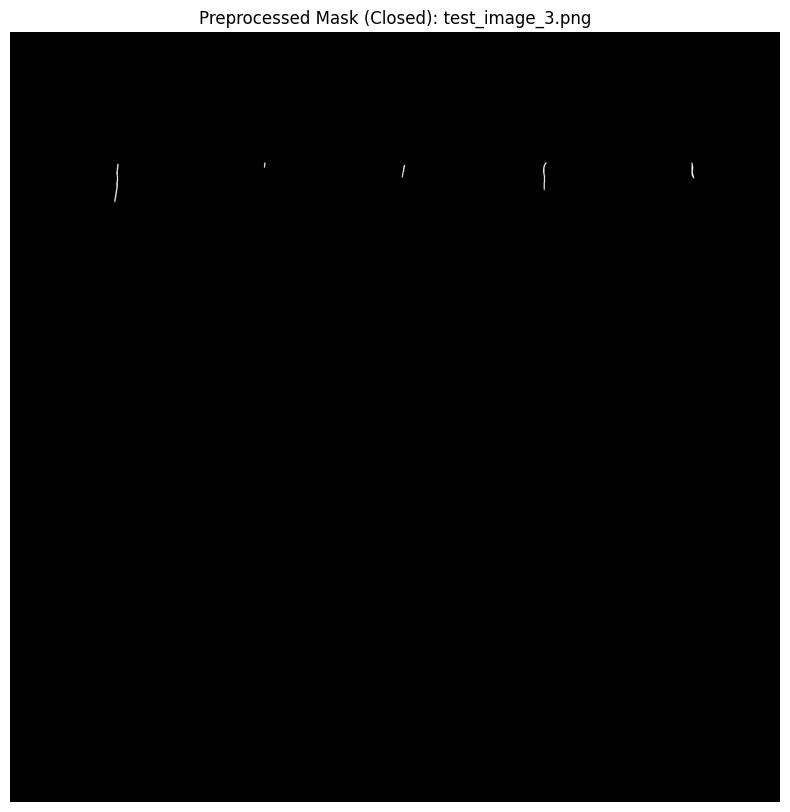

Preprocessing mask for test_image_4.png with morphological closing...


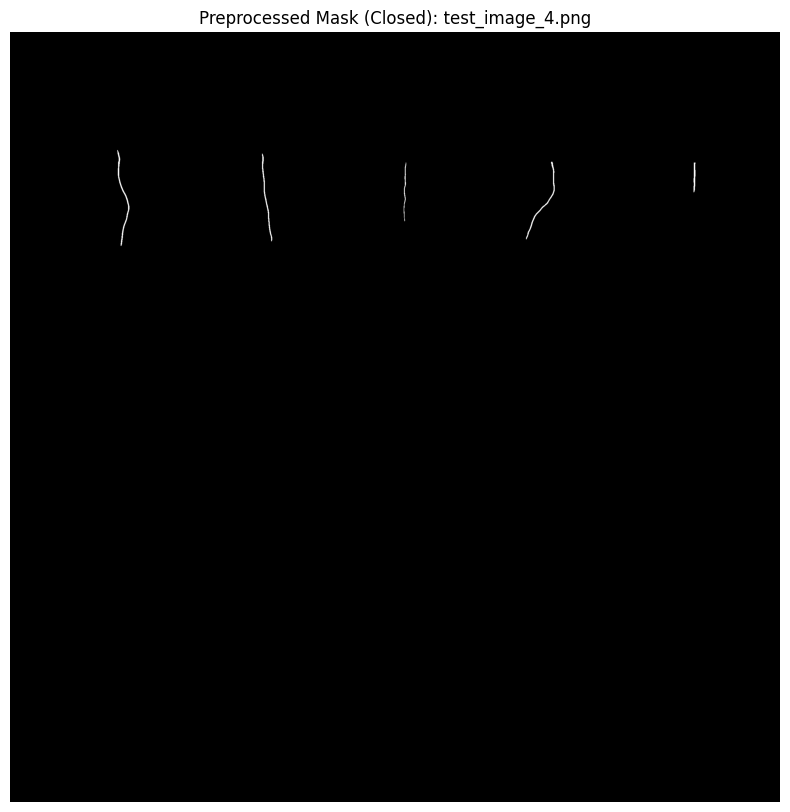

Preprocessing mask for test_image_5.png with morphological closing...


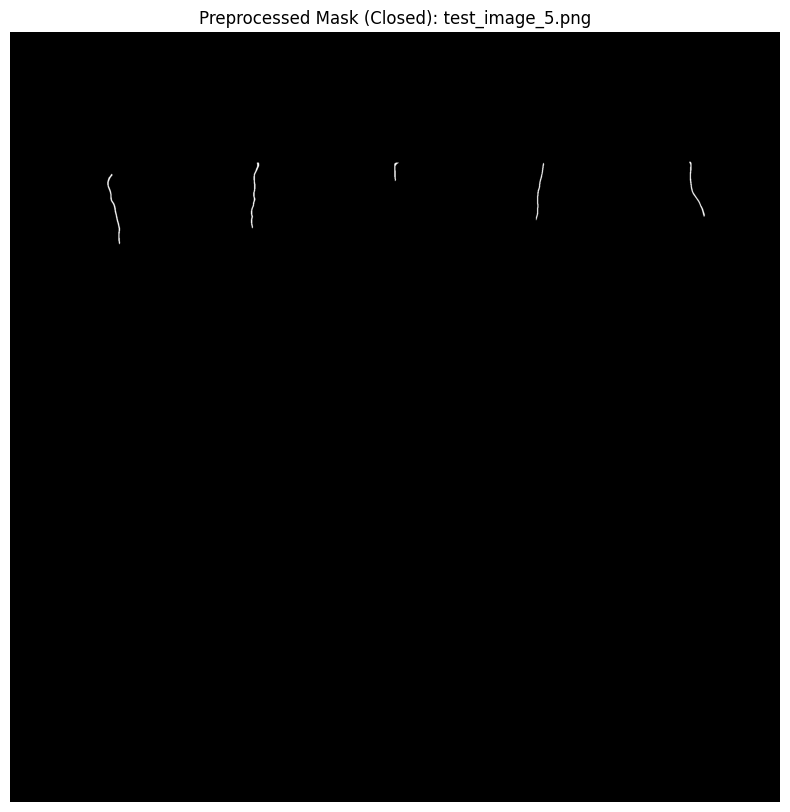

Preprocessing mask for test_image_6.png with morphological closing...


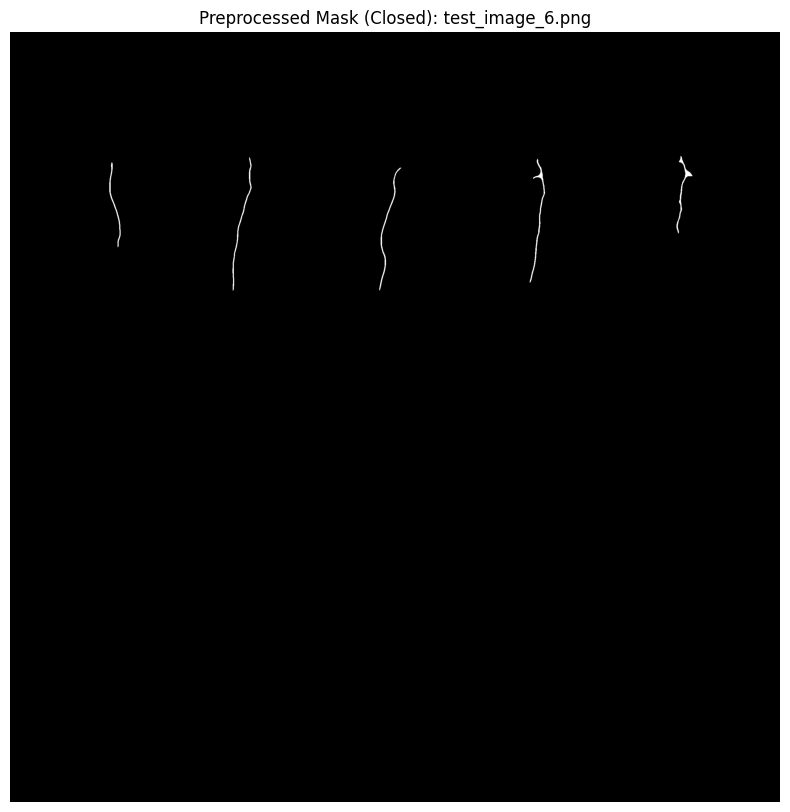

Preprocessing mask for test_image_7.png with morphological closing...


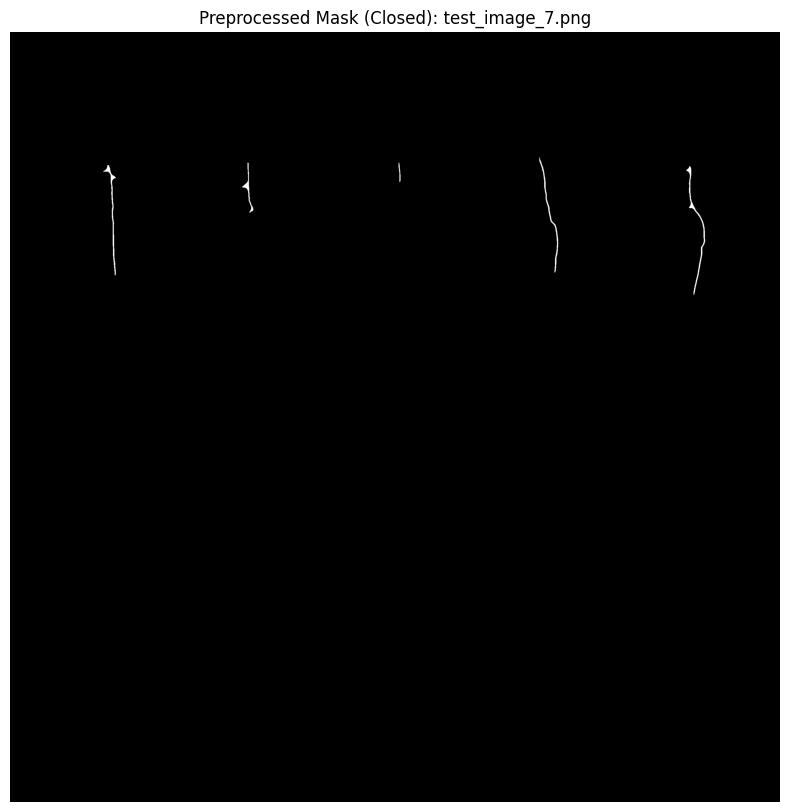

Preprocessing mask for test_image_8.png with morphological closing...


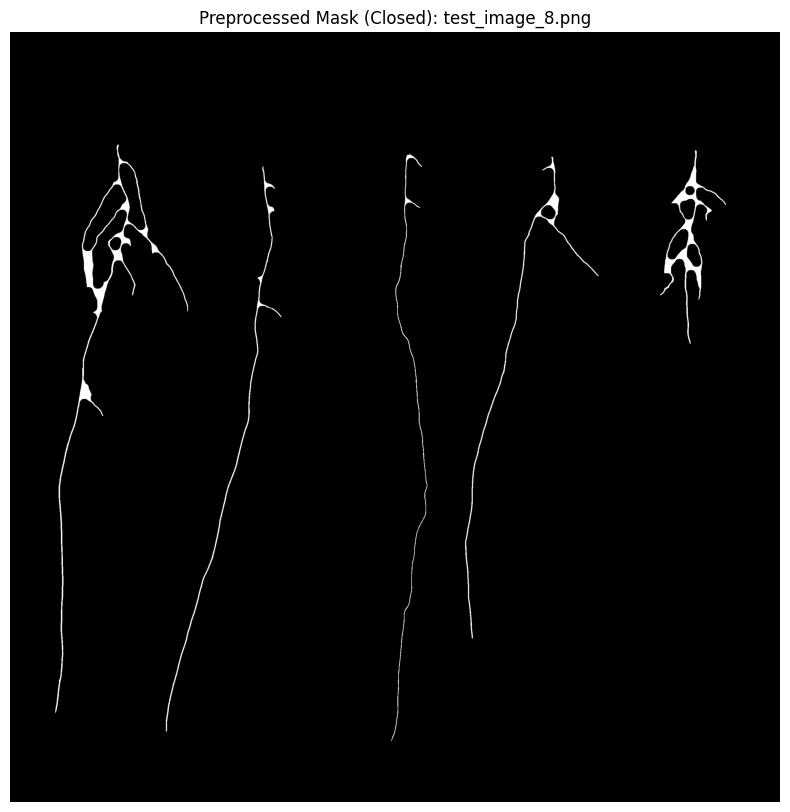

Preprocessing mask for test_image_9.png with morphological closing...


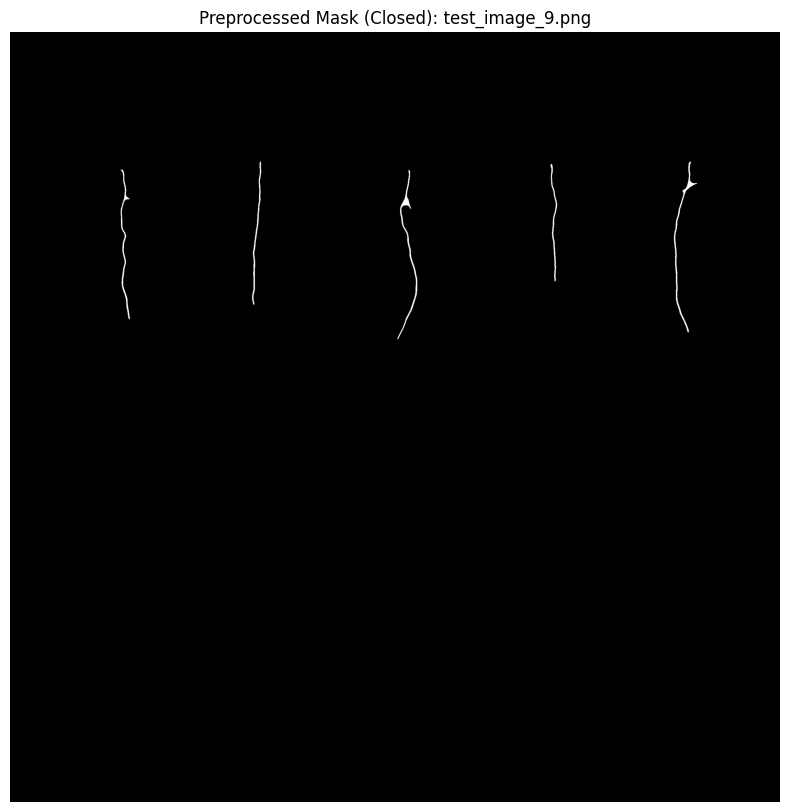

In [73]:
import cv2
import numpy as np

def preprocess_with_closing(filtered_masks, kernel_size=(15, 15)):
    """
    Apply morphological closing to merge small gaps in the mask,
    ensuring smaller roots or fragments aren't detected as separate components.

    Parameters:
        filtered_masks (dict): Dictionary of binary masks.
        kernel_size (tuple): Size of the structuring element for morphological closing.

    Returns:
        dict: Dictionary of preprocessed binary masks.
    """
    preprocessed_masks = {}
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)

    for file_name, mask in filtered_masks.items():
        print(f"Preprocessing mask for {file_name} with morphological closing...")

        # Apply morphological closing
        closed_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

        # Save the preprocessed mask
        preprocessed_masks[file_name] = closed_mask

        # Optional: Visualize the preprocessed mask
        plt.figure(figsize=(10, 10))
        plt.imshow(closed_mask, cmap="gray")
        plt.title(f"Preprocessed Mask (Closed): {file_name}")
        plt.axis("off")
        plt.show()

    return preprocessed_masks

# Preprocess the masks with morphological closing
preprocessed_masks = preprocess_with_closing(filtered_masks, kernel_size=(32, 32))



### Creating bounding boxes and Label Components:

Processing mask for test_image_1.png...
Visualizing bounding boxes applied to original mask for test_image_1.png...


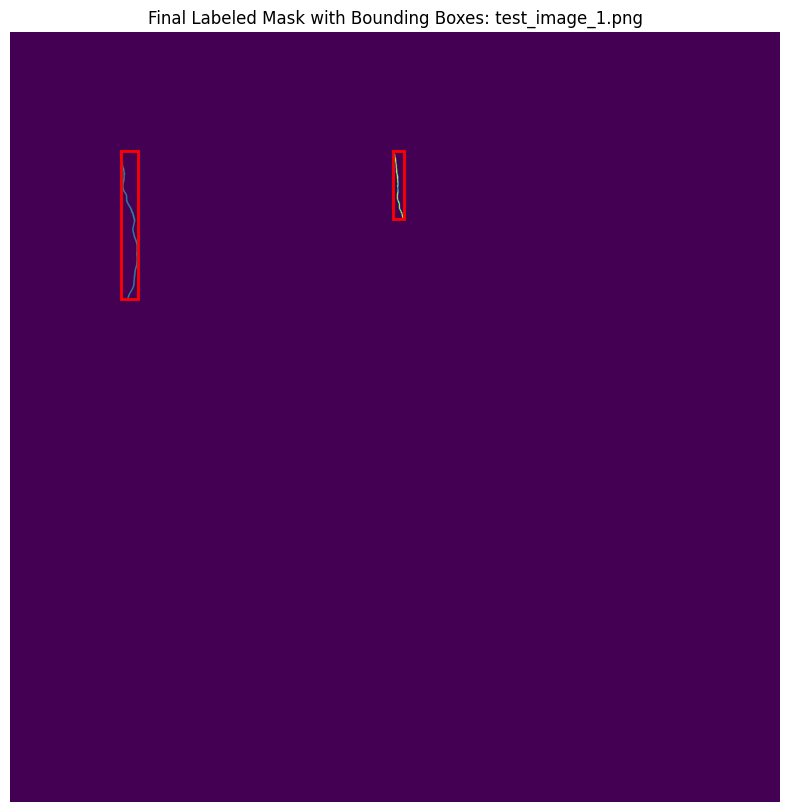

Processing mask for test_image_10.png...
Visualizing bounding boxes applied to original mask for test_image_10.png...


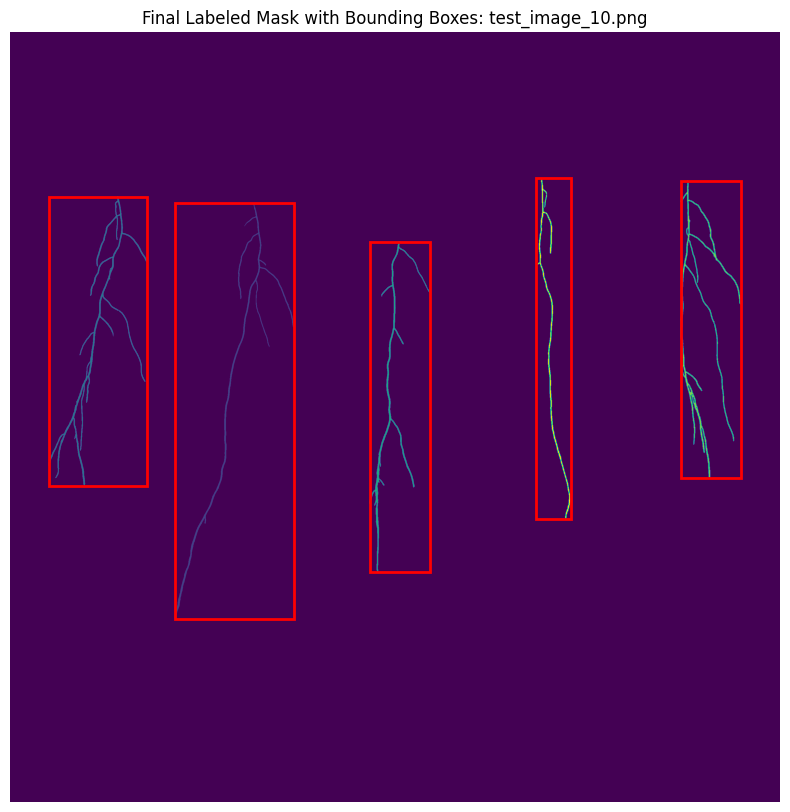

Processing mask for test_image_11.png...
Visualizing bounding boxes applied to original mask for test_image_11.png...


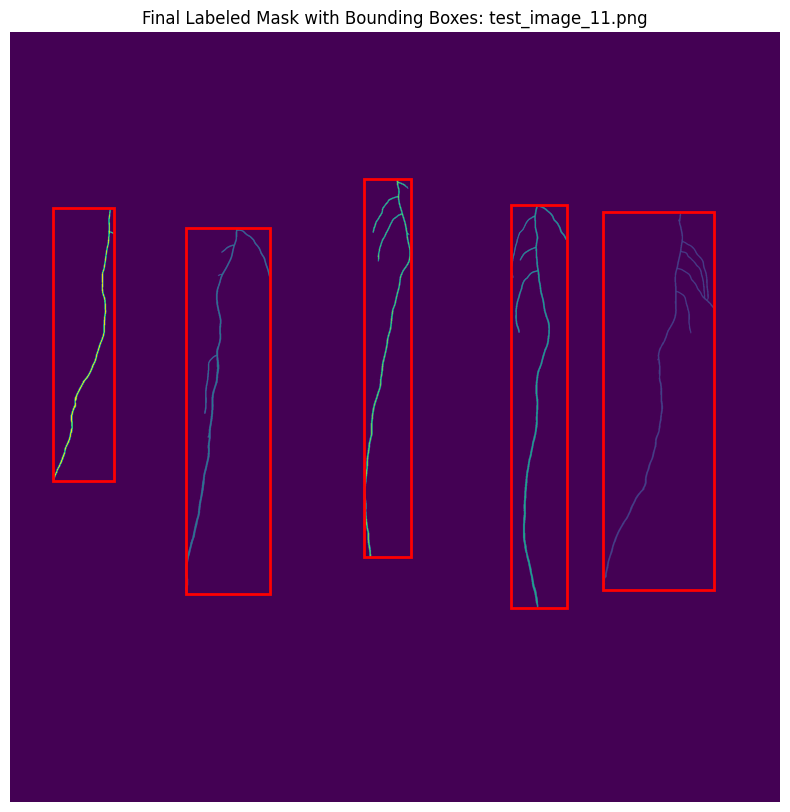

Processing mask for test_image_12.png...
Visualizing bounding boxes applied to original mask for test_image_12.png...


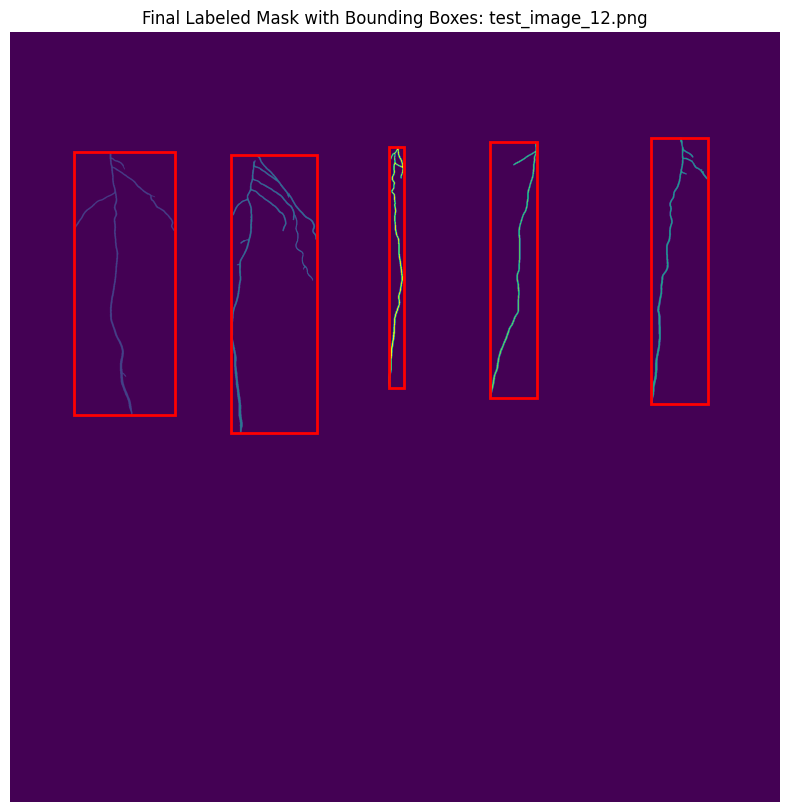

Processing mask for test_image_13.png...
Visualizing bounding boxes applied to original mask for test_image_13.png...


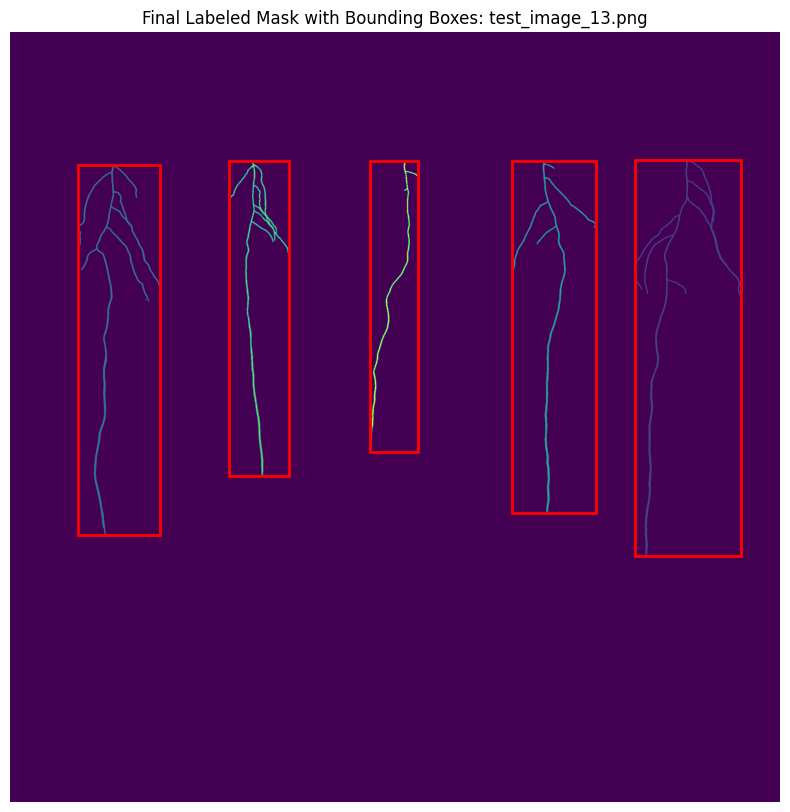

Processing mask for test_image_14.png...
Visualizing bounding boxes applied to original mask for test_image_14.png...


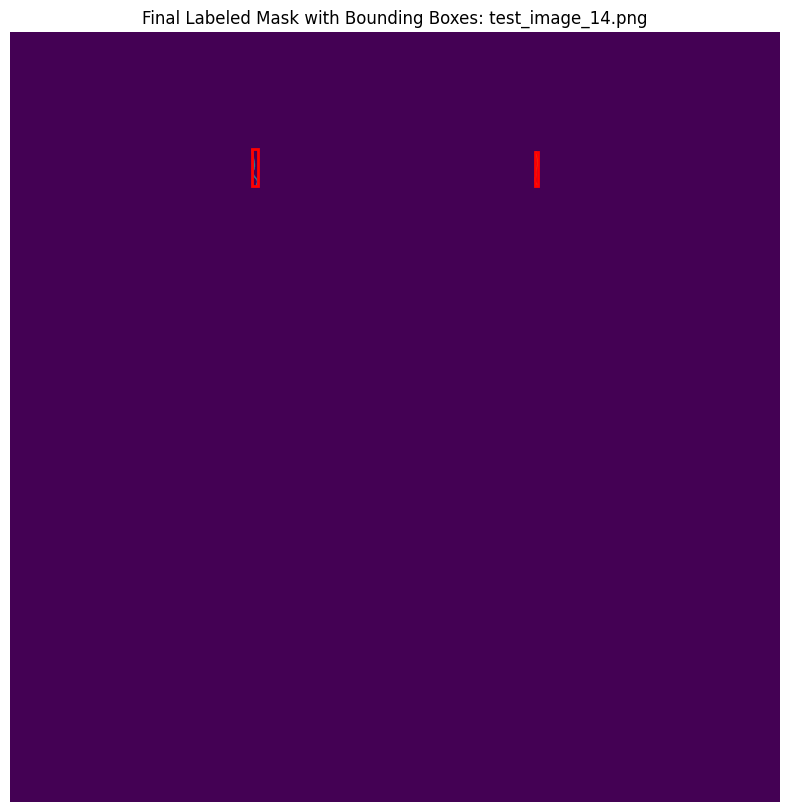

Processing mask for test_image_15.png...
Visualizing bounding boxes applied to original mask for test_image_15.png...


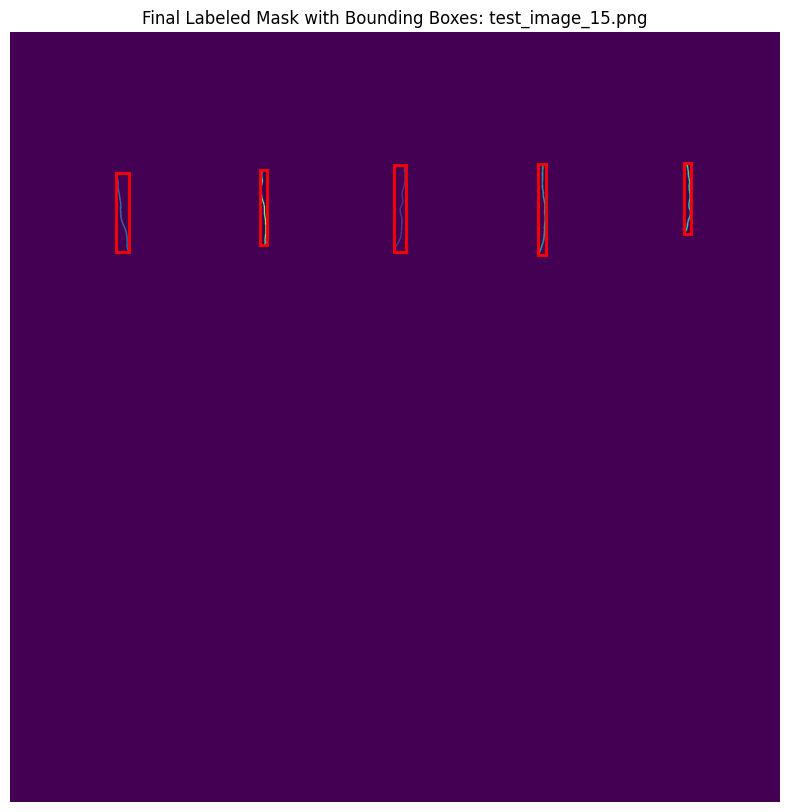

Processing mask for test_image_16.png...
Visualizing bounding boxes applied to original mask for test_image_16.png...


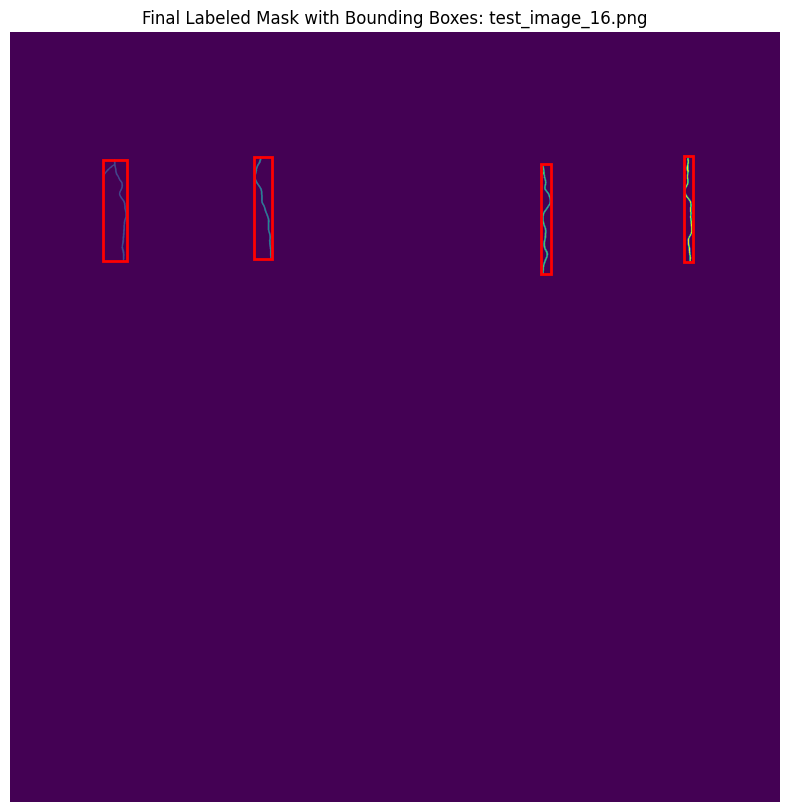

Processing mask for test_image_17.png...
Visualizing bounding boxes applied to original mask for test_image_17.png...


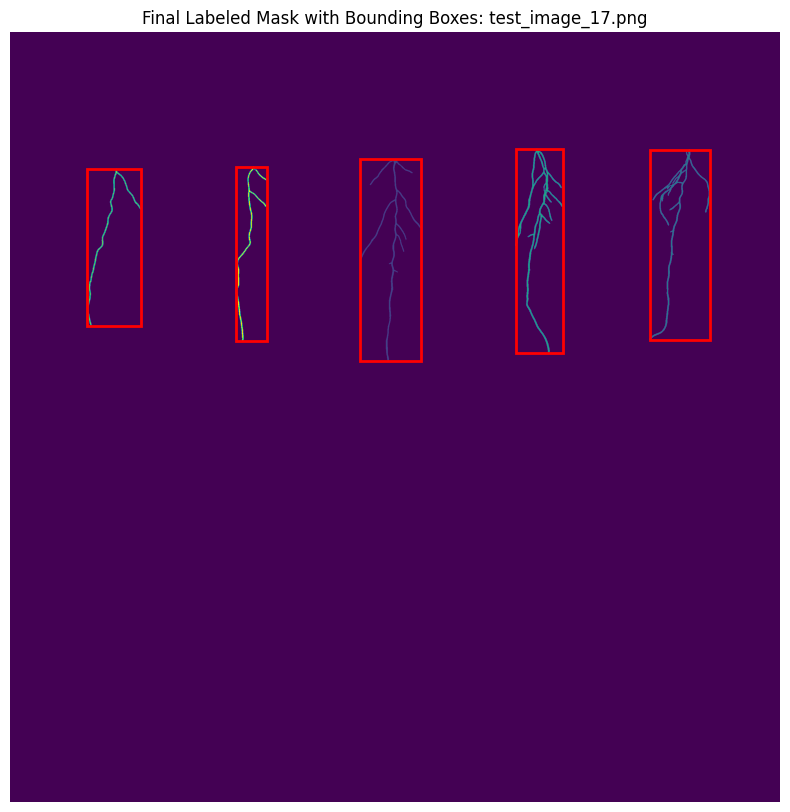

Processing mask for test_image_18.png...
Visualizing bounding boxes applied to original mask for test_image_18.png...


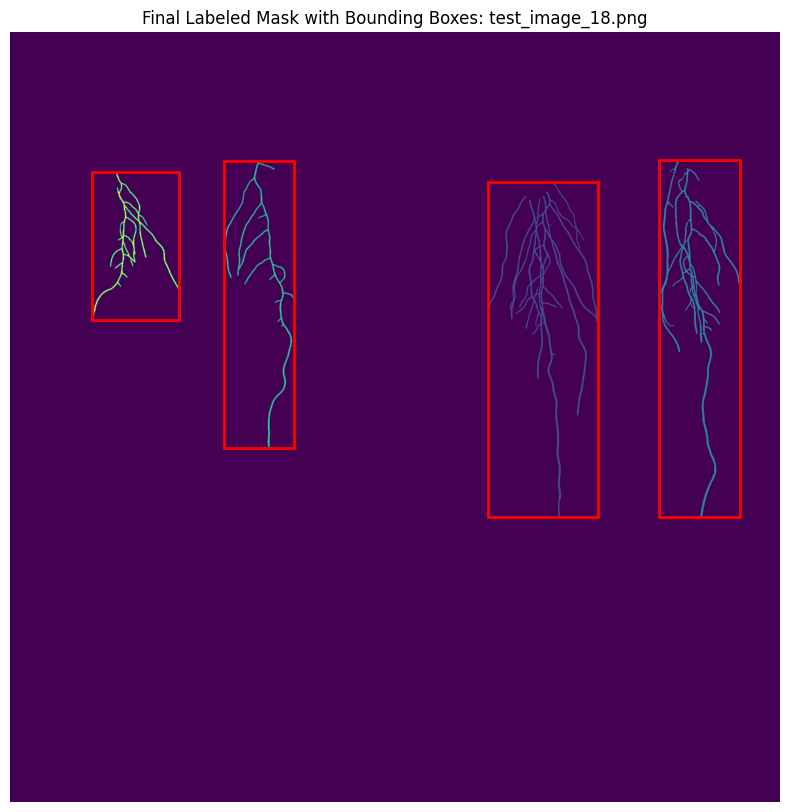

Processing mask for test_image_2.png...
Visualizing bounding boxes applied to original mask for test_image_2.png...


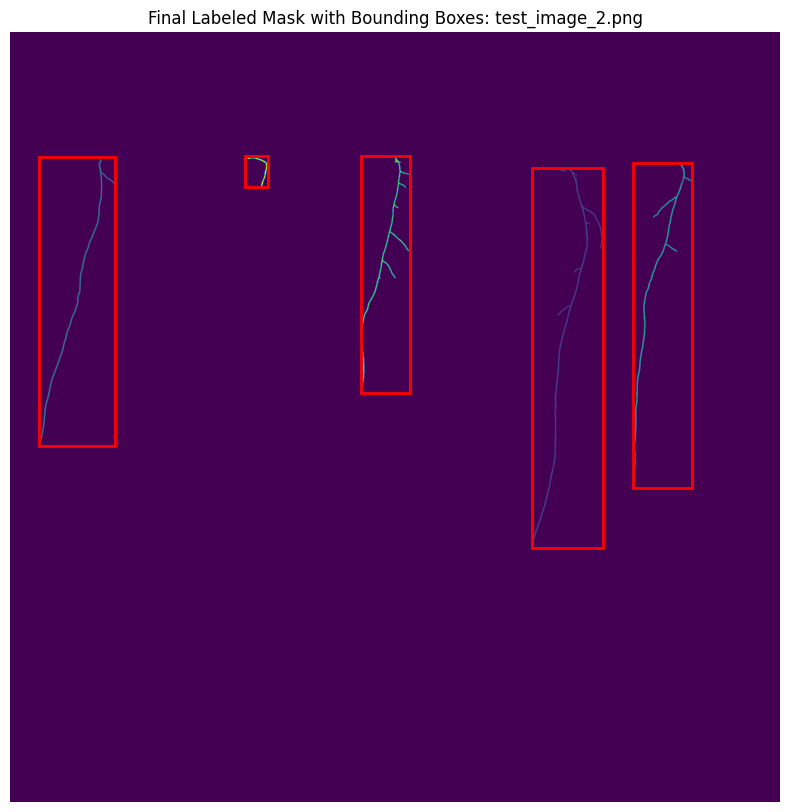

Processing mask for test_image_3.png...
Visualizing bounding boxes applied to original mask for test_image_3.png...


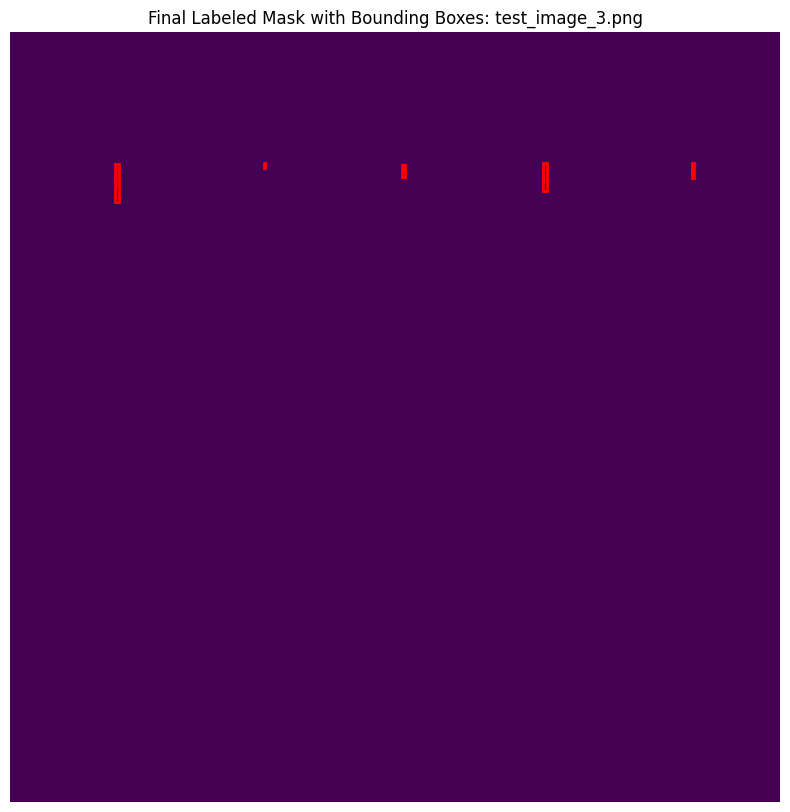

Processing mask for test_image_4.png...
Visualizing bounding boxes applied to original mask for test_image_4.png...


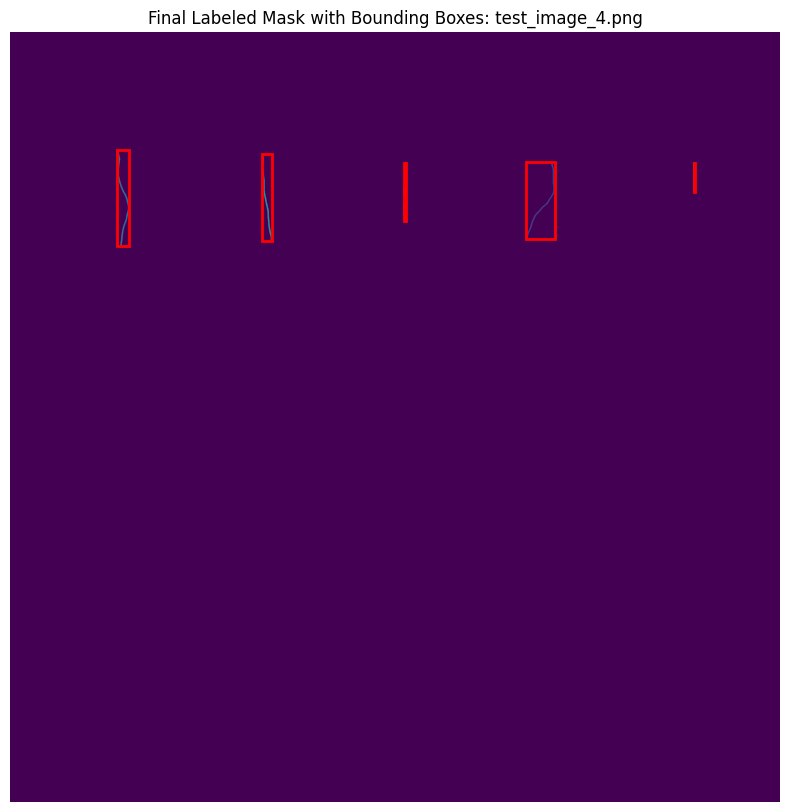

Processing mask for test_image_5.png...
Visualizing bounding boxes applied to original mask for test_image_5.png...


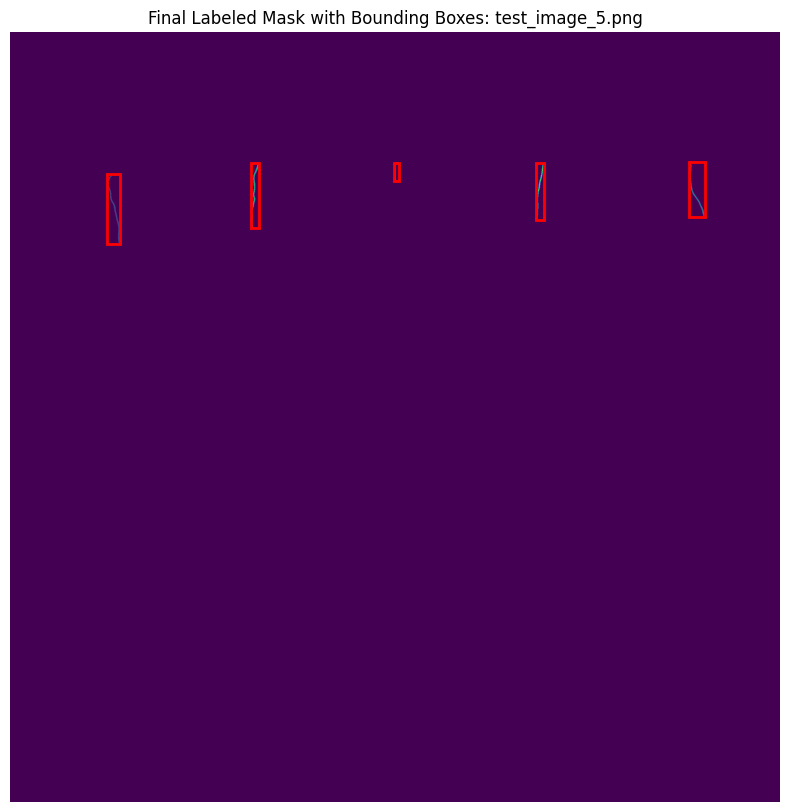

Processing mask for test_image_6.png...
Visualizing bounding boxes applied to original mask for test_image_6.png...


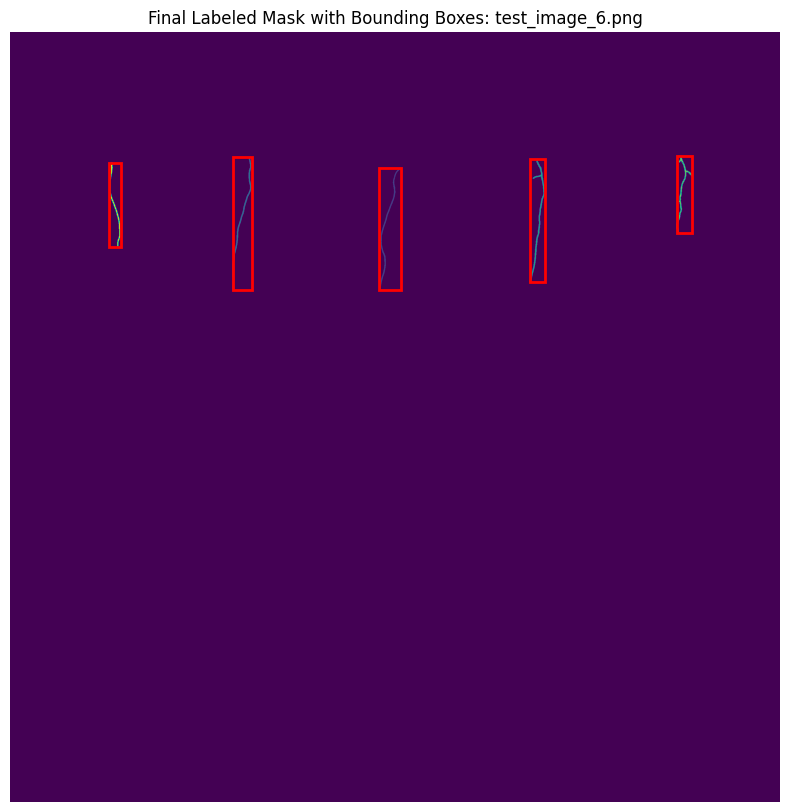

Processing mask for test_image_7.png...
Visualizing bounding boxes applied to original mask for test_image_7.png...


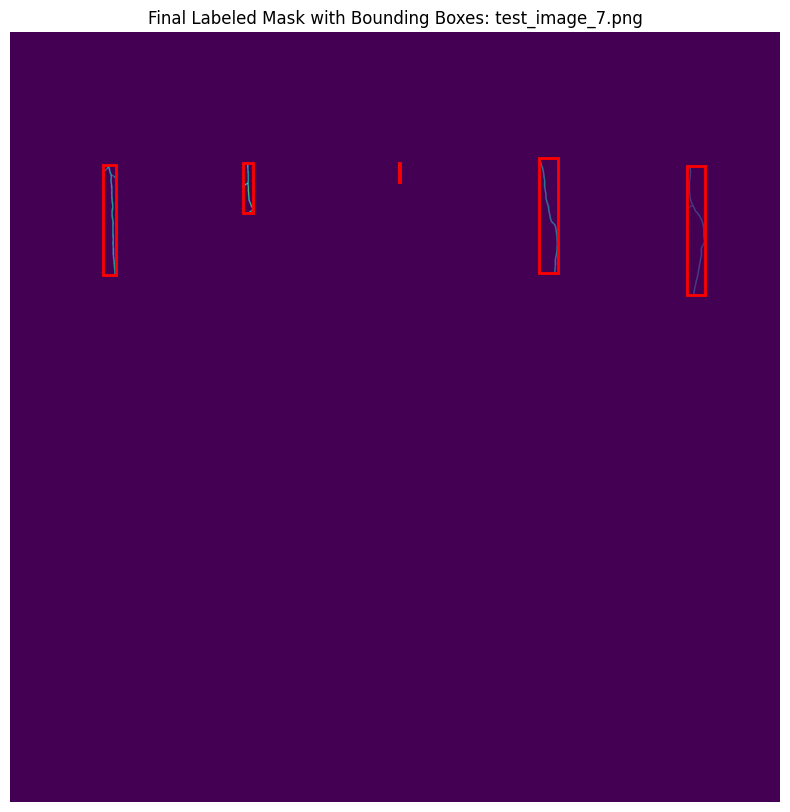

Processing mask for test_image_8.png...
Visualizing bounding boxes applied to original mask for test_image_8.png...


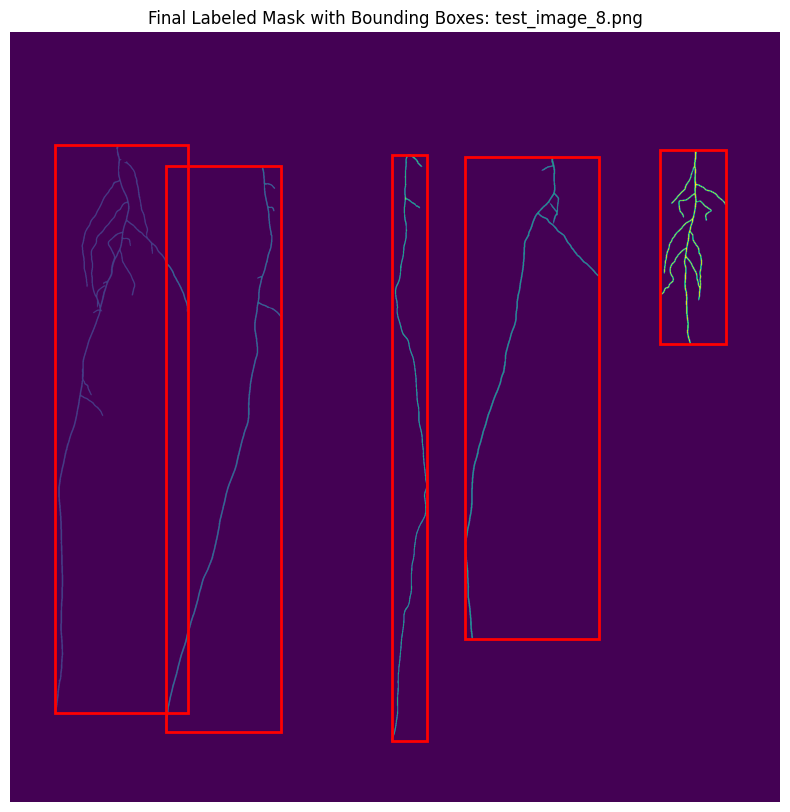

Processing mask for test_image_9.png...
Visualizing bounding boxes applied to original mask for test_image_9.png...


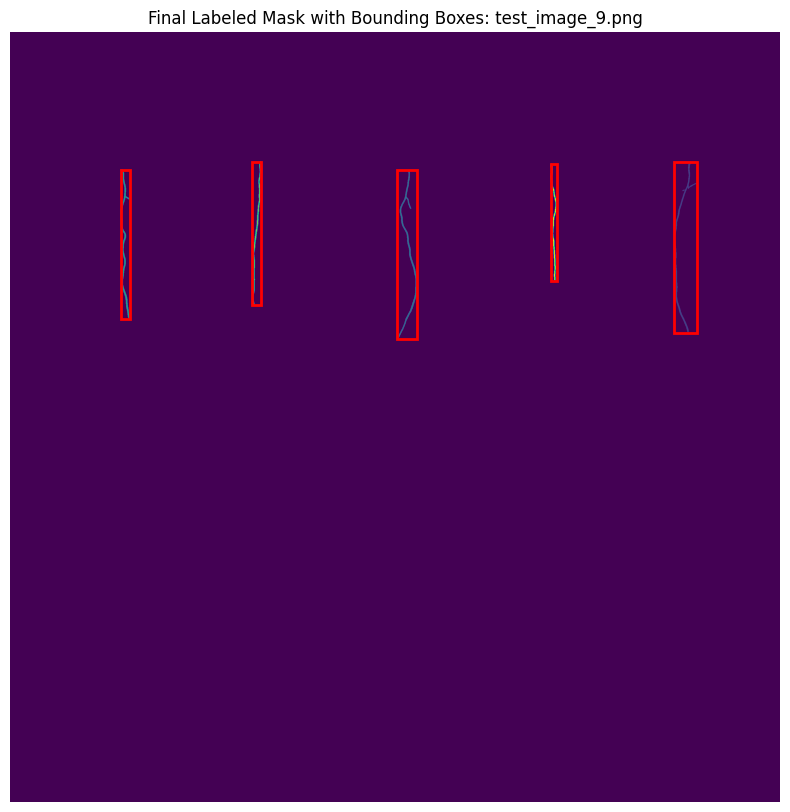

In [102]:
from scipy.ndimage import label
import matplotlib.pyplot as plt
import numpy as np
import cv2

def apply_bounding_boxes_to_original_masks(preprocessed_masks, filtered_masks, iou_threshold=0.001, size_threshold=1000):
    """
    Use bounding boxes detected on preprocessed masks (closed masks) and apply them to original filtered masks (unclosed masks).
    Retain all valid components within each bounding box.

    Parameters:
        preprocessed_masks (dict): Dictionary of binary masks after morphological closing.
        filtered_masks (dict): Original binary masks before closing.
        iou_threshold (float): Threshold for IoU to consider boxes as overlapping.
        size_threshold (int): Minimum area for a box to remain even if overlapping.

    Returns:
        dict: Dictionary of labeled masks with all valid components retained per bounding box.
        dict: Dictionary of bounding boxes for debugging.
    """
    final_labeled_masks = {}
    filtered_bboxes_dict = {}  # Store bounding boxes for debugging

    for file_name, preprocessed_mask in preprocessed_masks.items():
        print(f"Processing mask for {file_name}...")

        # Label connected components in preprocessed mask
        labeled_preprocessed, num_labels = label(preprocessed_mask > 0)

        # Extract bounding boxes for each labeled component
        bboxes = []
        for component_id in range(1, num_labels + 1):  # Skip background (label 0)
            component = (labeled_preprocessed == component_id)
            y_coords, x_coords = np.where(component)

            if len(x_coords) > 0 and len(y_coords) > 0:  # Valid component
                x_min, x_max = x_coords.min(), x_coords.max()
                y_min, y_max = y_coords.min(), y_coords.max()
                area = (x_max - x_min) * (y_max - y_min)
                box = (x_min, y_min, x_max, y_max, component_id, area)
                bboxes.append(box)

        # Sort bounding boxes by area (largest first)
        bboxes = sorted(bboxes, key=lambda box: box[5], reverse=True)  # Sort by area (last element in tuple)

        # Filter overlapping bounding boxes
        filtered_bboxes = []
        for box in bboxes:
            x_min, y_min, x_max, y_max, component_id, area = box
            keep = True
            for kept_box in filtered_bboxes:
                iou = calculate_iou(box[:4], kept_box[:4])
                if iou > iou_threshold:  # Overlap detected
                    if area > size_threshold and kept_box[5] > size_threshold:
                        continue  # Retain both boxes if both are above the threshold
                    if area <= kept_box[5]:  # Retain the larger box
                        keep = False
                        break
            if keep:
                filtered_bboxes.append(box)

        filtered_bboxes_dict[file_name] = filtered_bboxes  # Save for debugging

        # Apply filtered bounding boxes to the original mask
        original_mask = filtered_masks[file_name]
        new_labeled_mask = np.zeros_like(original_mask, dtype=np.uint16)

        for box_idx, box in enumerate(filtered_bboxes, start=1):
            x_min, y_min, x_max, y_max, _, _ = box

            # Extract region from the original mask
            region = original_mask[y_min:y_max + 1, x_min:x_max + 1]

            # Label connected components in the region
            labeled_region, num_components = label(region > 0)

            if num_components > 0:
                # Retain all components within the bounding box, assigning new IDs
                for component_id in range(1, num_components + 1):
                    component = (labeled_region == component_id)
                    new_labeled_mask[y_min:y_max + 1, x_min:x_max + 1][component] = box_idx

        final_labeled_masks[file_name] = new_labeled_mask

        # Visualization: labeled mask with bounding boxes
        print(f"Visualizing bounding boxes applied to original mask for {file_name}...")
        plt.figure(figsize=(10, 10))
        plt.imshow(new_labeled_mask, cmap="viridis")
        plt.title(f"Final Labeled Mask with Bounding Boxes: {file_name}")
        plt.axis("off")

        for box in filtered_bboxes:
            x_min, y_min, x_max, y_max, _, _ = box
            plt.gca().add_patch(plt.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                edgecolor="red", fill=False, linewidth=2
            ))

        plt.show()

    return final_labeled_masks, filtered_bboxes_dict

# Apply bounding boxes to original masks
iou_threshold = 0.001
size_threshold = 1000
final_labeled_masks, filtered_bboxes_dict = apply_bounding_boxes_to_original_masks(
    preprocessed_masks, filtered_masks, iou_threshold, size_threshold
)

### Visualizing the root before saving to a CSV:

## debug

Debugging mask for test_image_1.png...
Number of components in test_image_1.png: 2


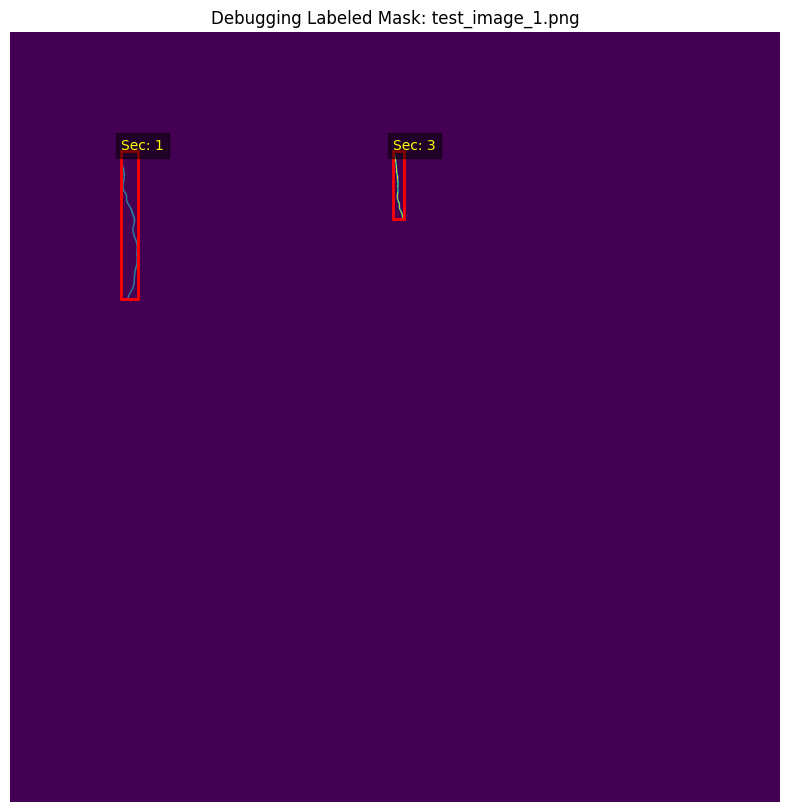

Debugging mask for test_image_10.png...
Number of components in test_image_10.png: 5


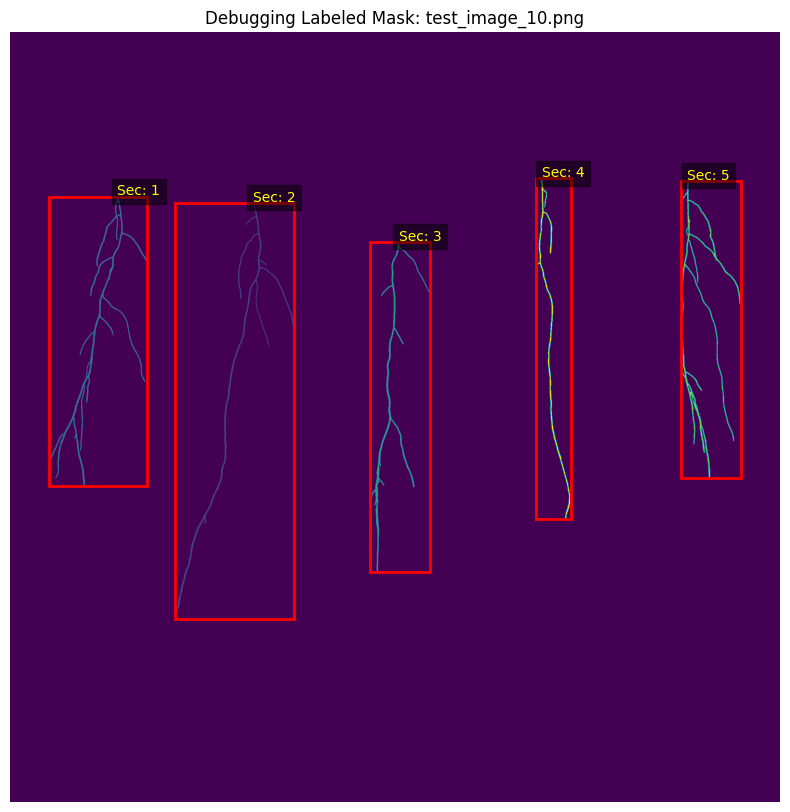

Debugging mask for test_image_11.png...
Number of components in test_image_11.png: 5


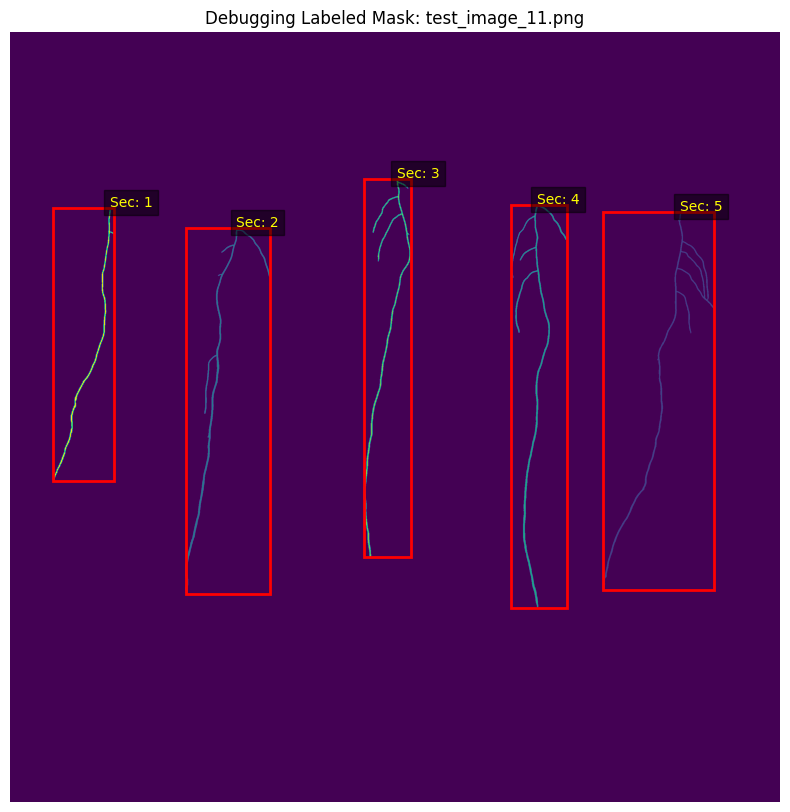

Debugging mask for test_image_12.png...
Number of components in test_image_12.png: 5


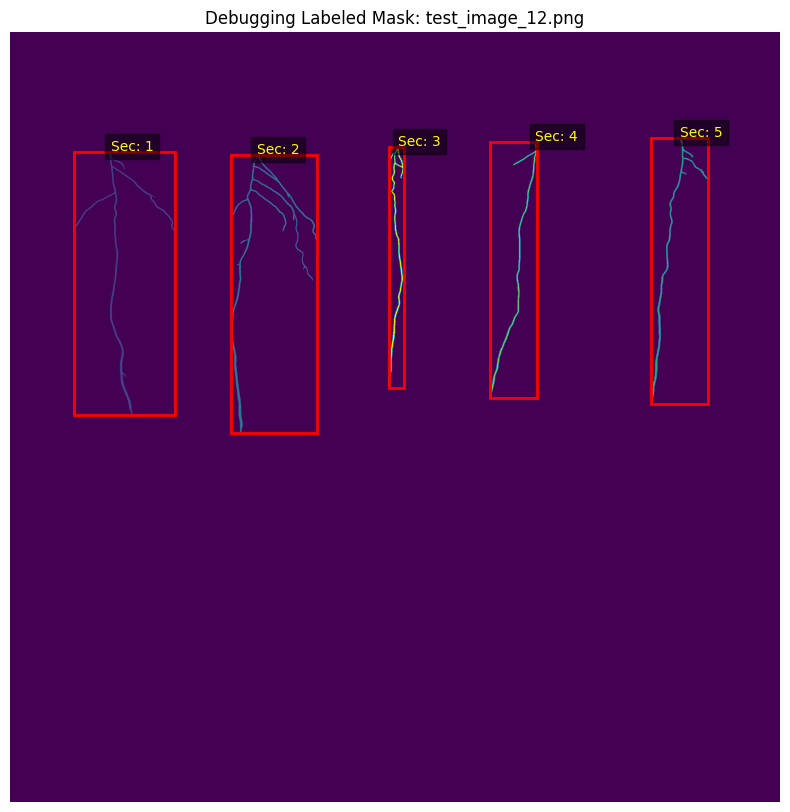

Debugging mask for test_image_13.png...
Number of components in test_image_13.png: 5


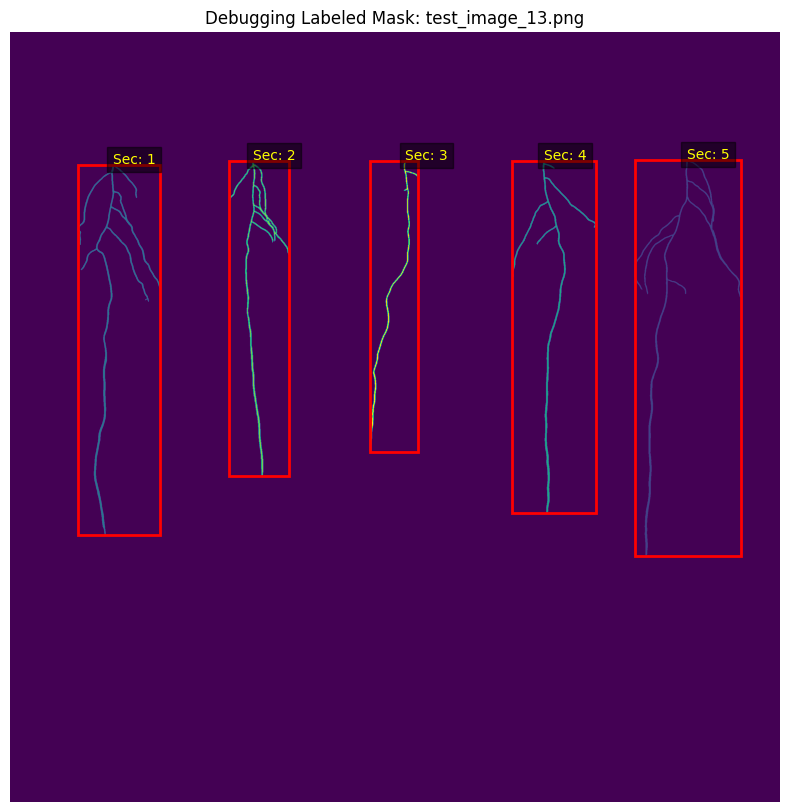

Debugging mask for test_image_14.png...
Number of components in test_image_14.png: 2


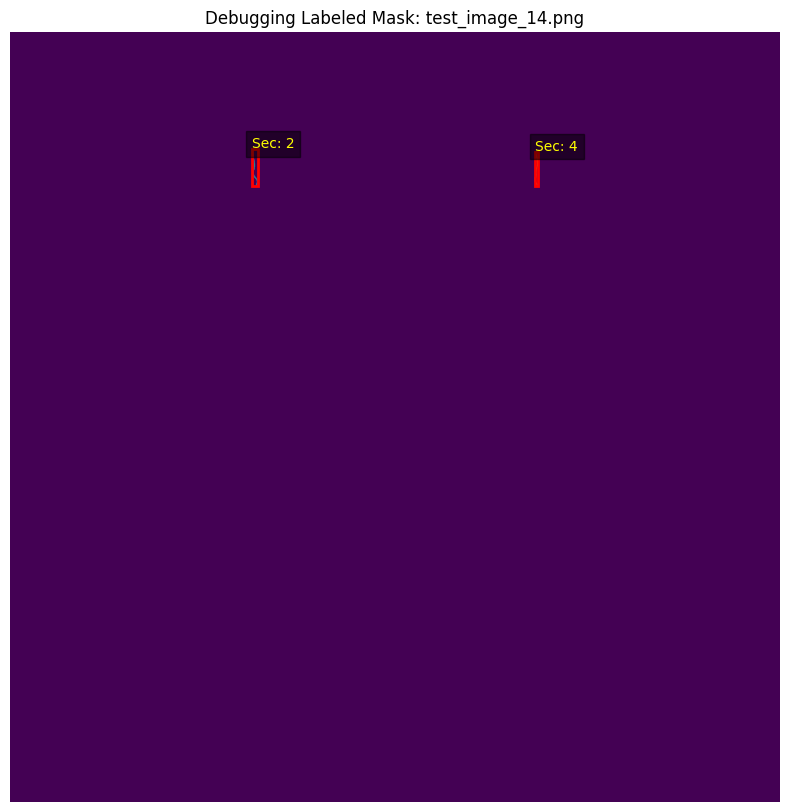

Debugging mask for test_image_15.png...
Number of components in test_image_15.png: 5


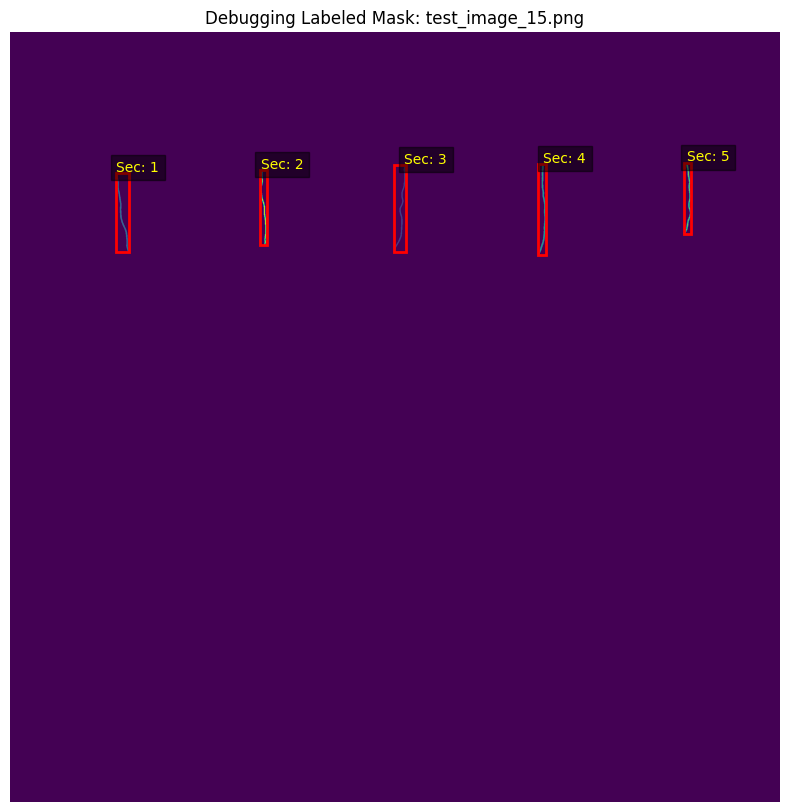

Debugging mask for test_image_16.png...
Number of components in test_image_16.png: 4


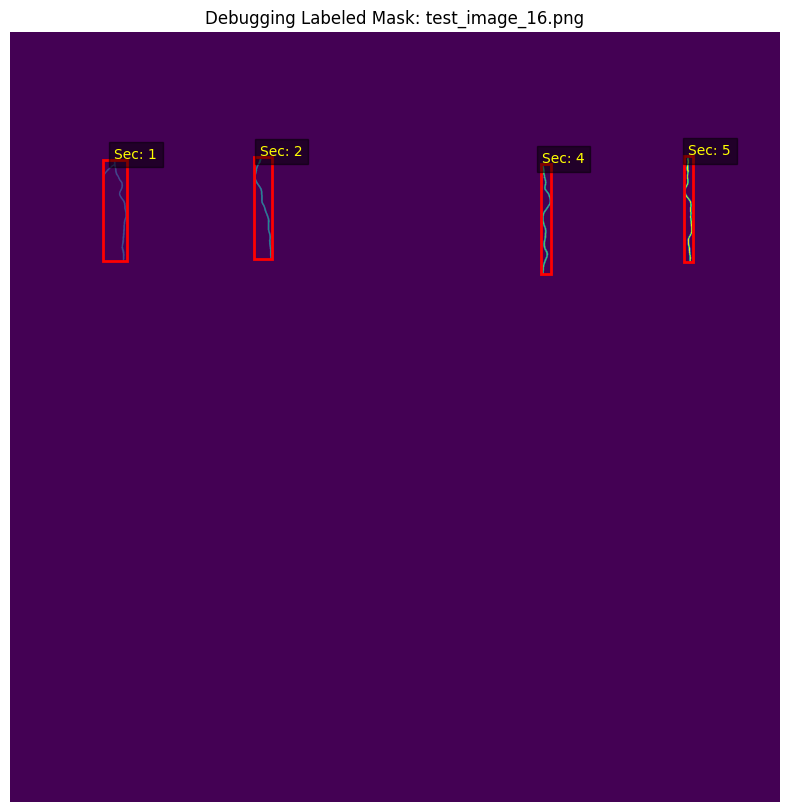

Debugging mask for test_image_17.png...
Number of components in test_image_17.png: 5


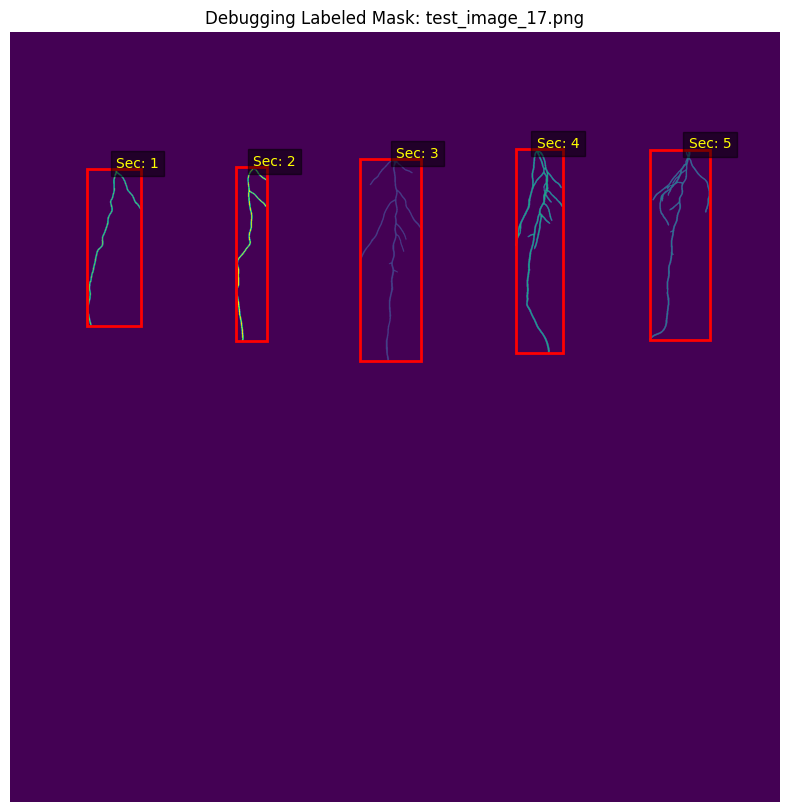

Debugging mask for test_image_18.png...
Number of components in test_image_18.png: 4


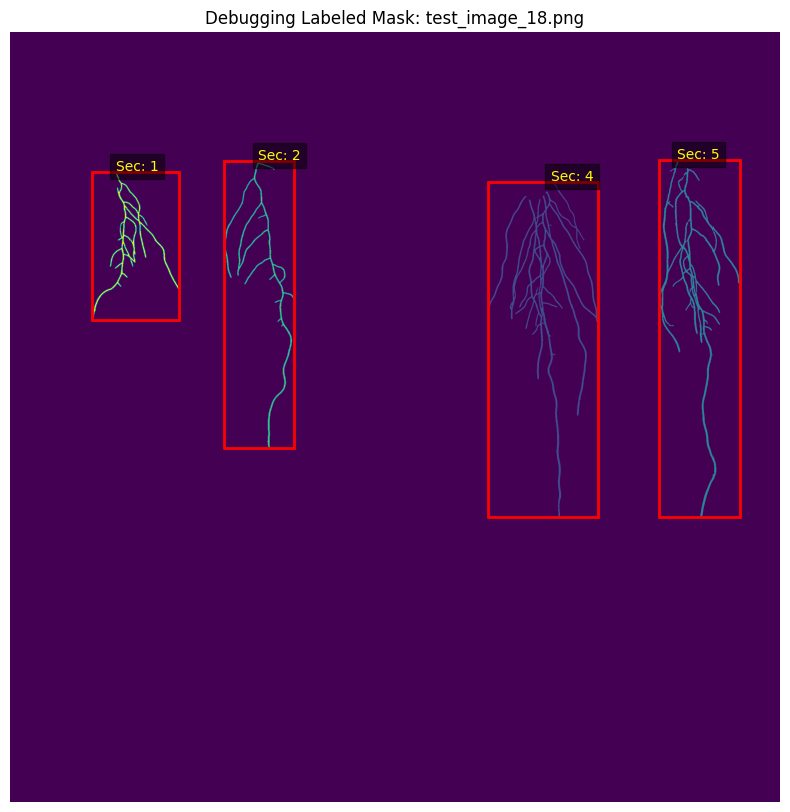

Debugging mask for test_image_2.png...
Number of components in test_image_2.png: 5


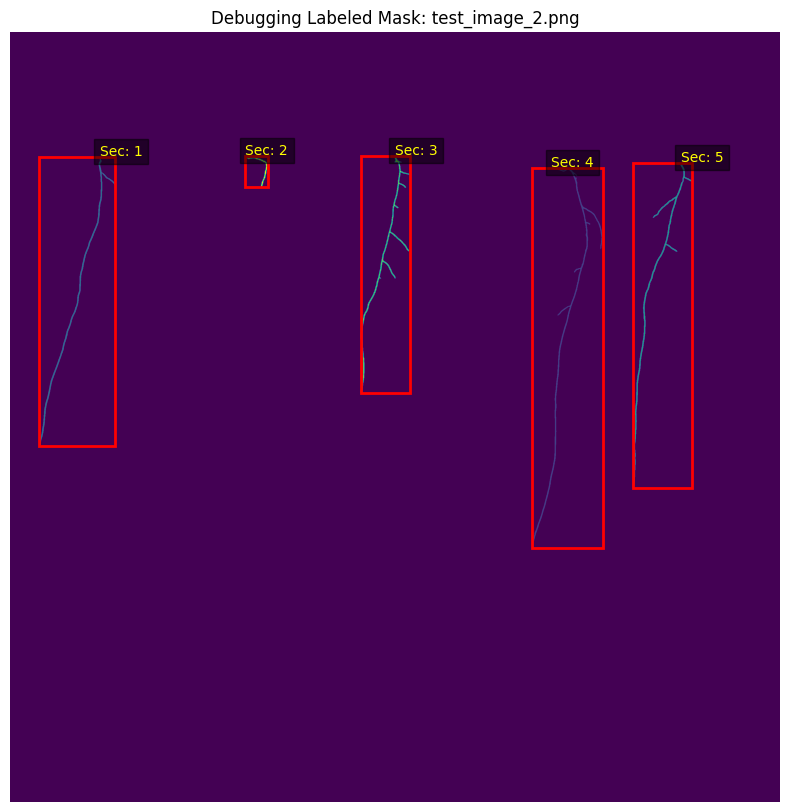

Debugging mask for test_image_3.png...
Number of components in test_image_3.png: 5


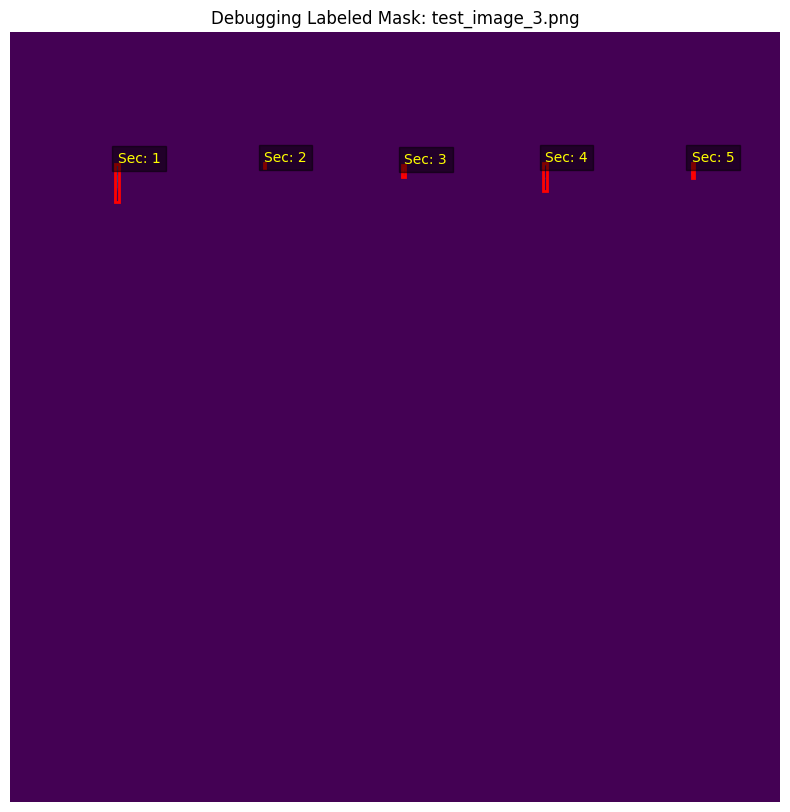

Debugging mask for test_image_4.png...
Number of components in test_image_4.png: 5


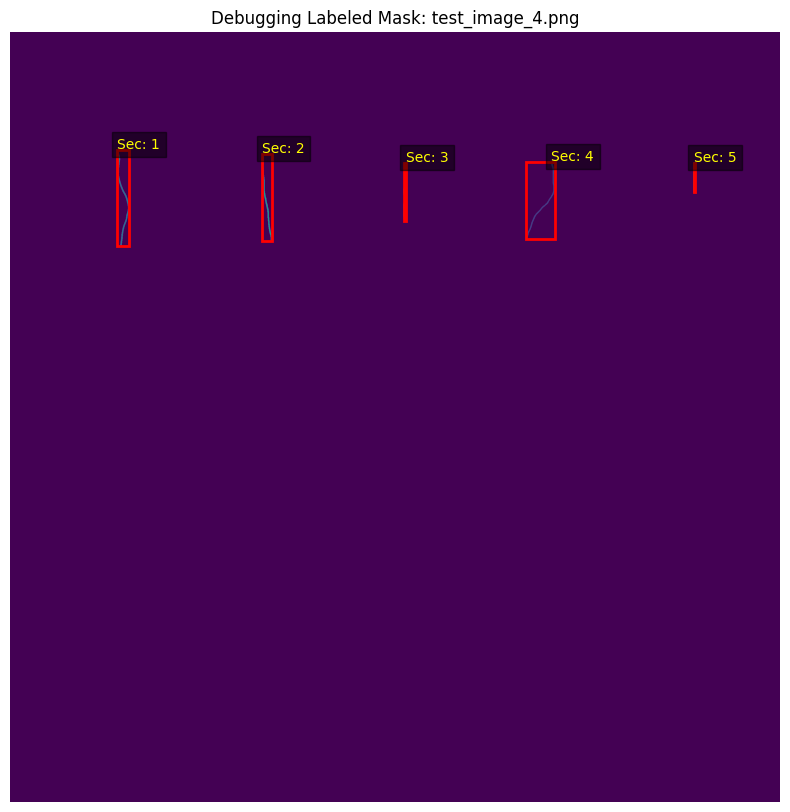

Debugging mask for test_image_5.png...
Number of components in test_image_5.png: 5


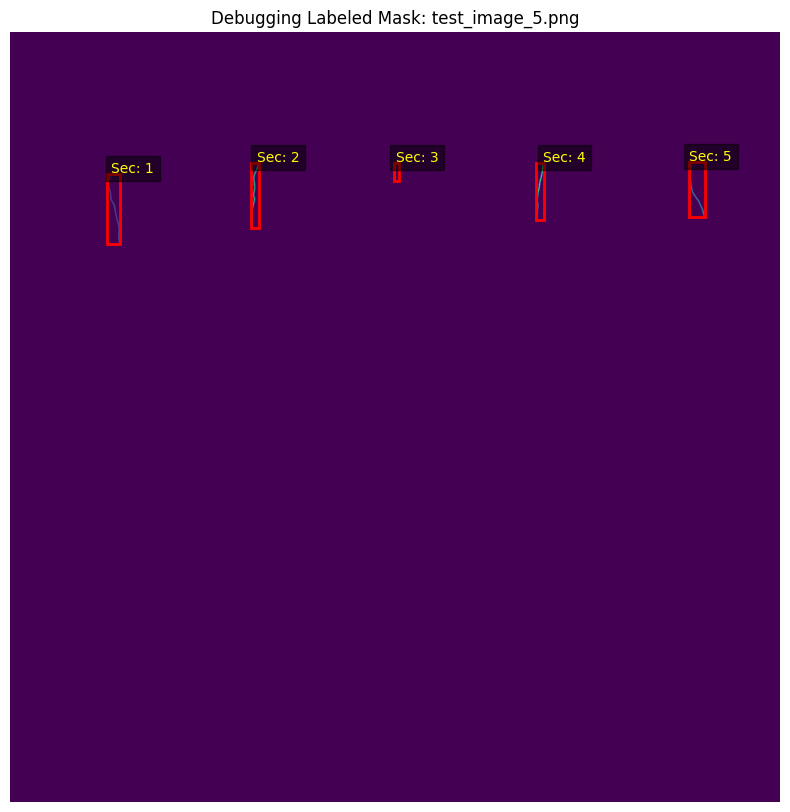

Debugging mask for test_image_6.png...
Number of components in test_image_6.png: 5


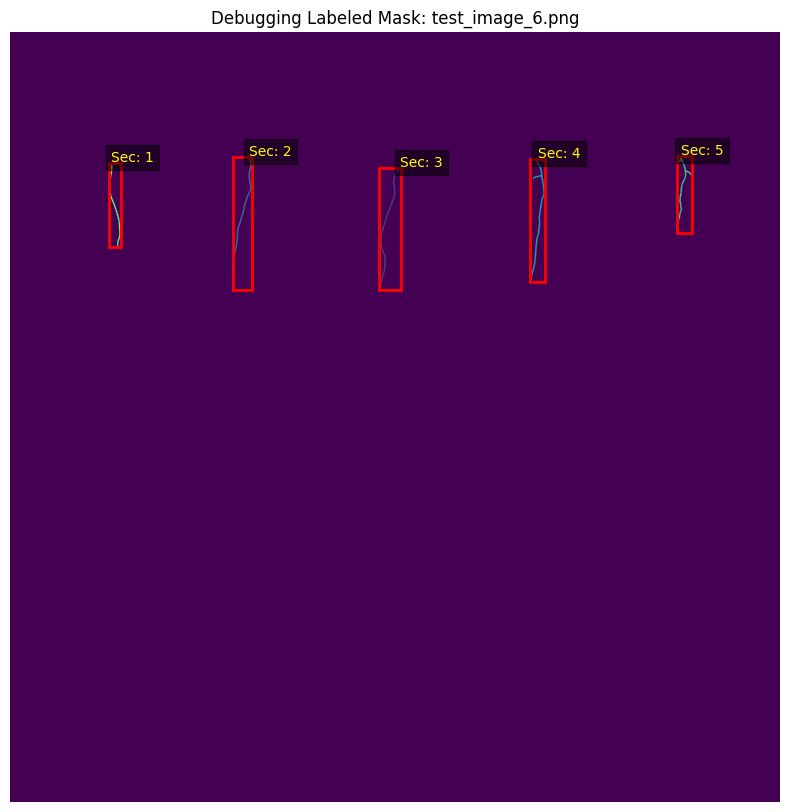

Debugging mask for test_image_7.png...
Number of components in test_image_7.png: 5


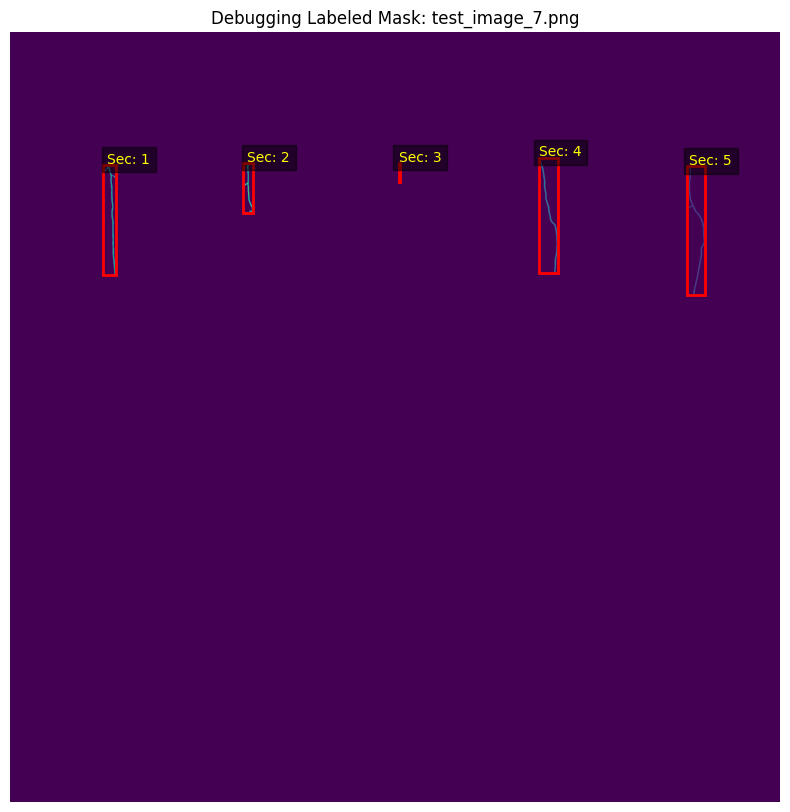

Debugging mask for test_image_8.png...
Number of components in test_image_8.png: 5


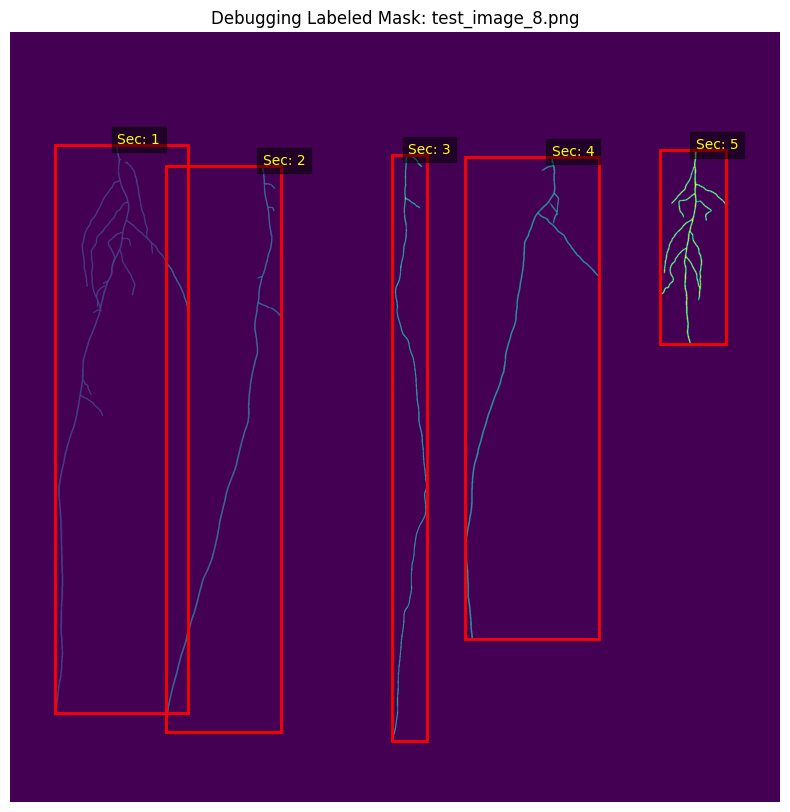

Debugging mask for test_image_9.png...
Number of components in test_image_9.png: 5


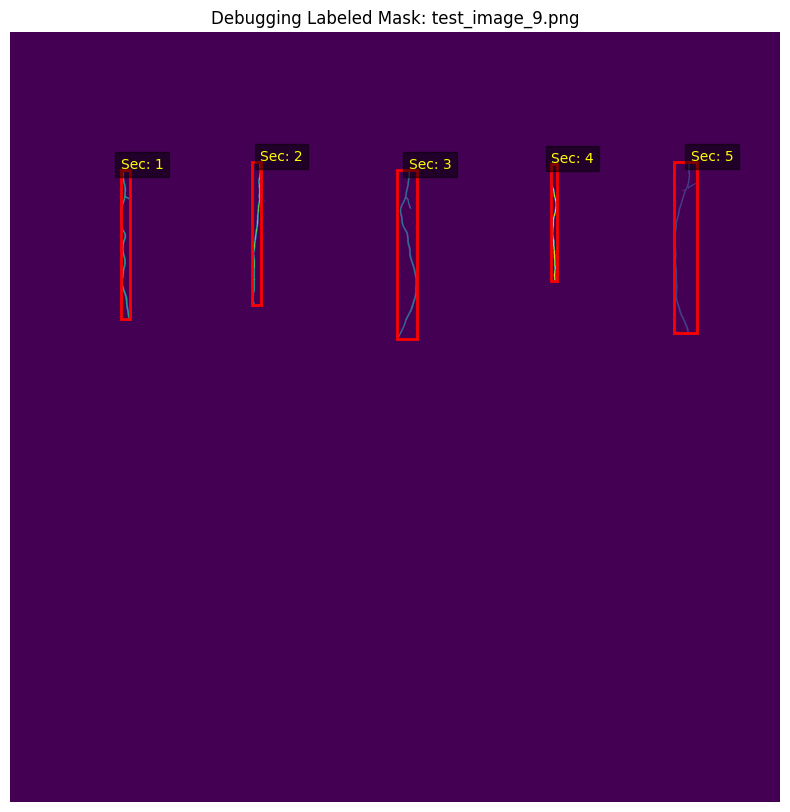

In [106]:
def debug_final_labeled_masks_by_sections(final_labeled_masks, filtered_bboxes_dict, num_sections=5):
    """
    Debug function to visualize labeled masks and their bounding boxes. Assign IDs based on the
    top node within each of the 5 equal vertical sections.

    Parameters:
        final_labeled_masks (dict): Dictionary of final labeled masks.
        filtered_bboxes_dict (dict): Dictionary of bounding boxes for each file.
        num_sections (int): Number of equal vertical sections.

    Returns:
        None
    """
    for file_name, labeled_mask in final_labeled_masks.items():
        print(f"Debugging mask for {file_name}...")

        # Dimensions of the mask
        h, w = labeled_mask.shape
        section_width = w // num_sections

        # Visualize the labeled mask
        plt.figure(figsize=(10, 10))
        plt.imshow(labeled_mask, cmap="viridis")
        plt.title(f"Debugging Labeled Mask: {file_name}")
        plt.axis("off")

        # Get bounding boxes for this file and sort by x_min (left-to-right)
        filtered_bboxes = filtered_bboxes_dict.get(file_name, [])
        filtered_bboxes = sorted(filtered_bboxes, key=lambda box: box[0])  # Sort by x_min

        for box in filtered_bboxes:
            if len(box) == 6:  # Ensure the bounding box has the correct structure
                x_min, y_min, x_max, y_max, _, _ = box

                # Draw bounding box
                plt.gca().add_patch(plt.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    edgecolor="red", fill=False, linewidth=2
                ))

                # Assign section ID based on the top node in the box
                region = labeled_mask[y_min:y_max + 1, x_min:x_max + 1]
                top_node_coords = np.where(region > 0)
                if top_node_coords[0].size > 0:  # If any nodes are present
                    top_y = top_node_coords[0].min() + y_min
                    top_x = top_node_coords[1][np.argmin(top_node_coords[0])] + x_min

                    # Determine section based on top_x
                    section_idx = int(top_x // section_width) + 1

                    # Display section ID for the top node
                    plt.text(
                        top_x, top_y - 5, f"Sec: {section_idx}",
                        color="yellow", fontsize=10, bbox=dict(facecolor="black", alpha=0.5)
                    )
                else:
                    # If no top node exists
                    plt.text(
                        x_min + 5, y_min + 15, f"No top node",
                        color="yellow", fontsize=10, bbox=dict(facecolor="black", alpha=0.5)
                    )

        # Display the number of components in the mask
        print(f"Number of components in {file_name}: {labeled_mask.max()}")
        plt.show()




# Debugging the final labeled masks
debug_final_labeled_masks_by_sections(final_labeled_masks, filtered_bboxes_dict)



Visualizing root lengths for test_image_1.png...
Root 1: Section 1, Length = 563.39 px, Start = (418, 391), End = (935, 415)
Root 2: Section 3, Length = 255.98 px, Start = (417, 1347), End = (656, 1382)


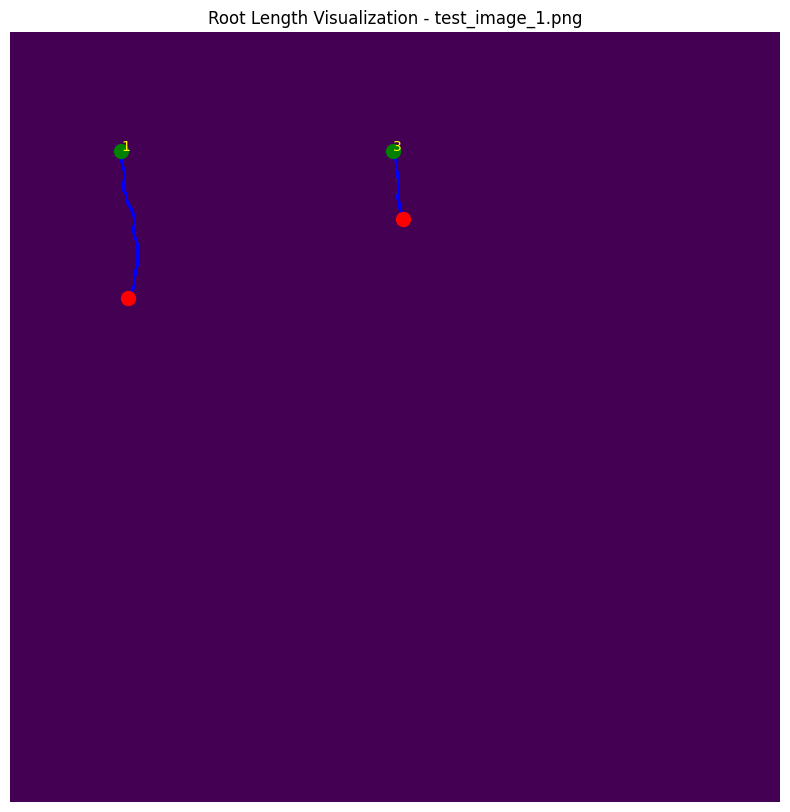

Visualizing root lengths for test_image_10.png...
Root 1: Section 2, Length = 1643.90 px, Start = (618, 877), End = (2115, 594)
Root 2: Section 1, Length = 1144.37 px, Start = (594, 388), End = (1635, 268)
Root 3: Section 3, Length = 1258.55 px, Start = (757, 1403), End = (1946, 1327)
Root 4: Section 5, Length = 1141.48 px, Start = (536, 2444), End = (1606, 2523)
Root 5: Section 4, Length = 1302.97 px, Start = (528, 1919), End = (1756, 2004)


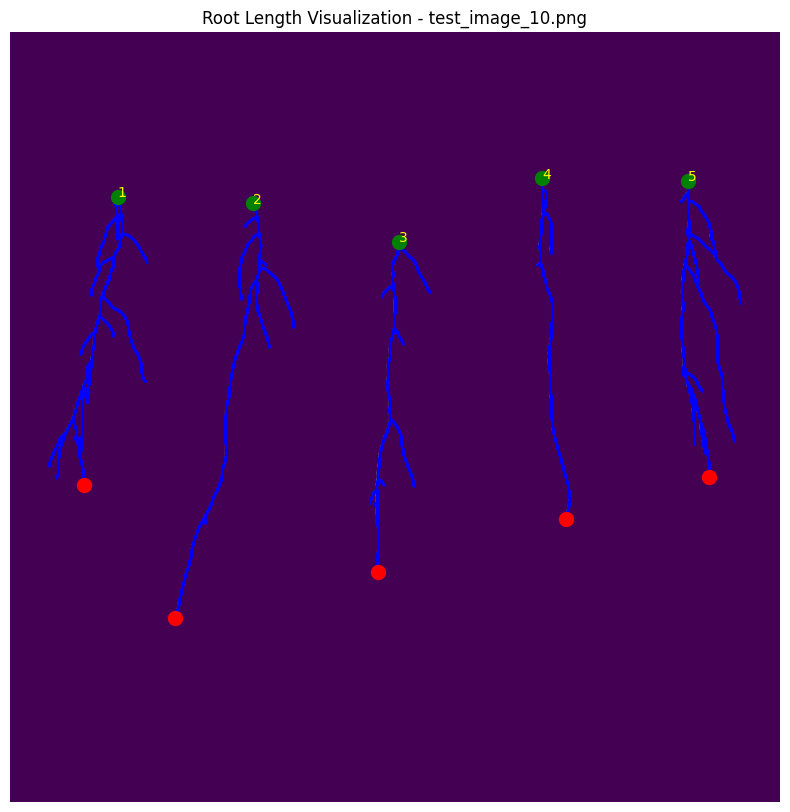

Visualizing root lengths for test_image_11.png...
Root 1: Section 5, Length = 1503.18 px, Start = (648, 2416), End = (2010, 2138)
Root 2: Section 2, Length = 1417.51 px, Start = (707, 817), End = (2027, 639)
Root 3: Section 4, Length = 1540.54 px, Start = (625, 1901), End = (2074, 1902)
Root 4: Section 3, Length = 1456.75 px, Start = (532, 1396), End = (1891, 1298)
Root 5: Section 1, Length = 1079.34 px, Start = (635, 360), End = (1616, 156)


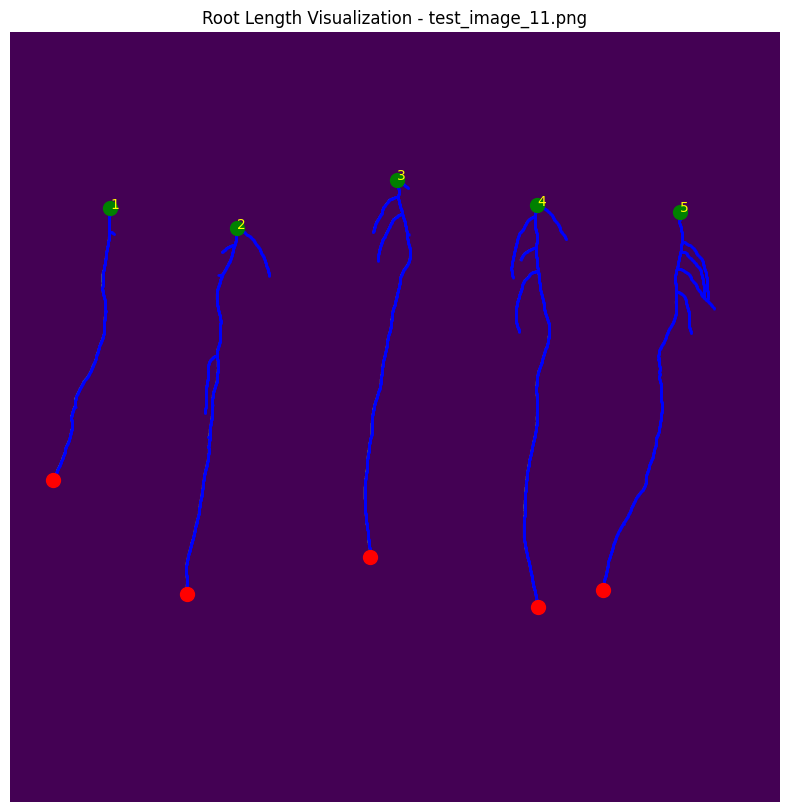

Visualizing root lengths for test_image_12.png...
Root 1: Section 1, Length = 1018.76 px, Start = (436, 364), End = (1385, 439)
Root 2: Section 2, Length = 1239.52 px, Start = (445, 894), End = (1452, 834)
Root 3: Section 5, Length = 1024.86 px, Start = (385, 2429), End = (1344, 2322)
Root 4: Section 4, Length = 1005.46 px, Start = (397, 1902), End = (1325, 1739)
Root 5: Section 3, Length = 931.58 px, Start = (416, 1406), End = (1288, 1375)


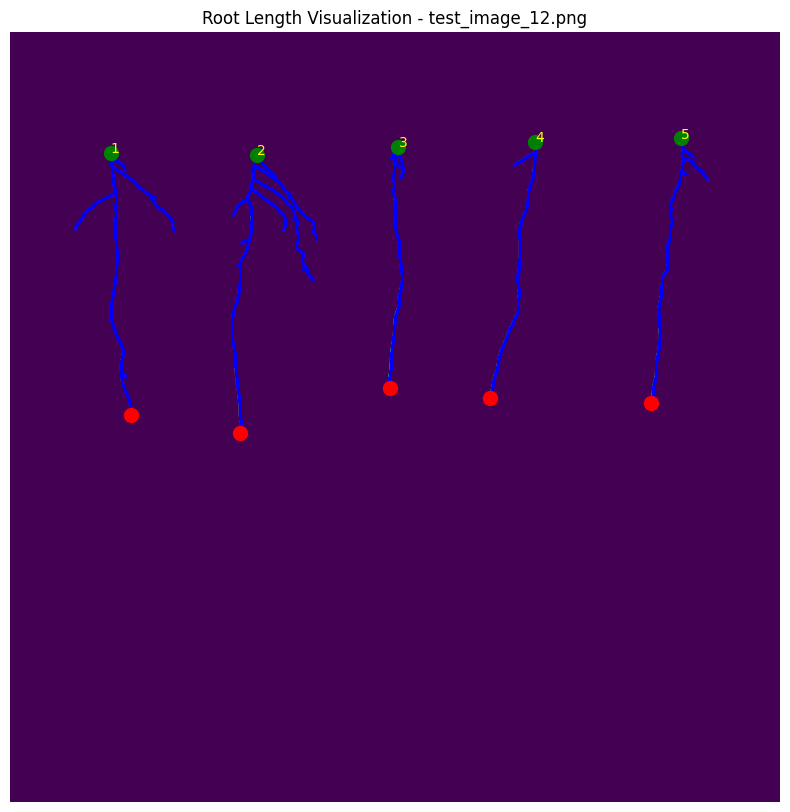

Visualizing root lengths for test_image_13.png...
Root 1: Section 5, Length = 1519.64 px, Start = (464, 2452), End = (1893, 2304)
Root 2: Section 1, Length = 1443.58 px, Start = (482, 376), End = (1819, 344)
Root 3: Section 4, Length = 1349.14 px, Start = (466, 1934), End = (1739, 1945)
Root 4: Section 2, Length = 1191.85 px, Start = (467, 878), End = (1605, 912)
Root 5: Section 3, Length = 1135.74 px, Start = (467, 1432), End = (1517, 1305)


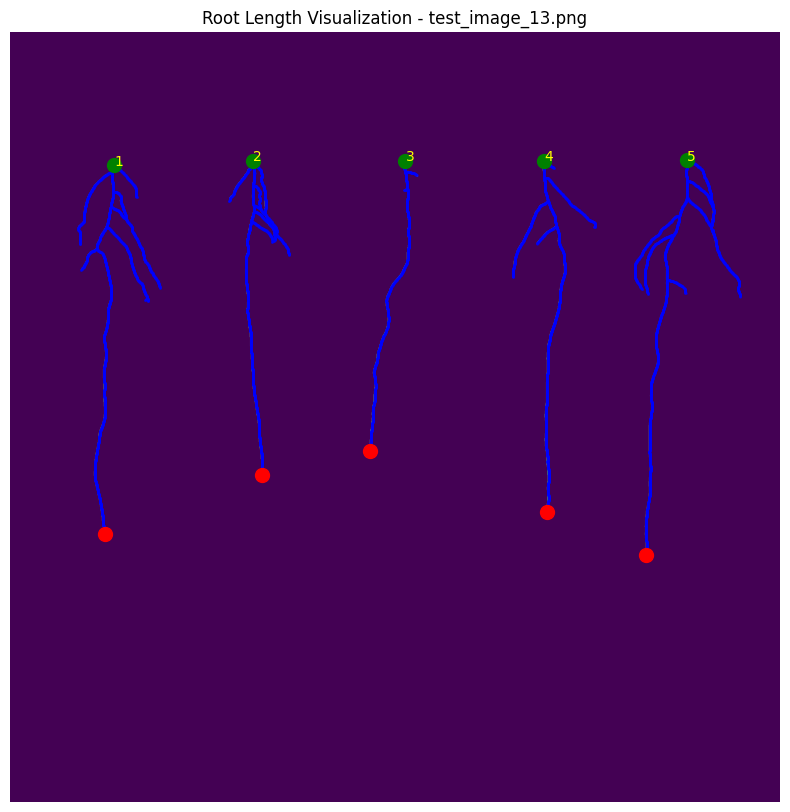

Visualizing root lengths for test_image_14.png...
Root 1: Section 2, Length = 147.50 px, Start = (424, 873), End = (557, 890)
Root 2: Section 4, Length = 128.94 px, Start = (434, 1902), End = (553, 1906)


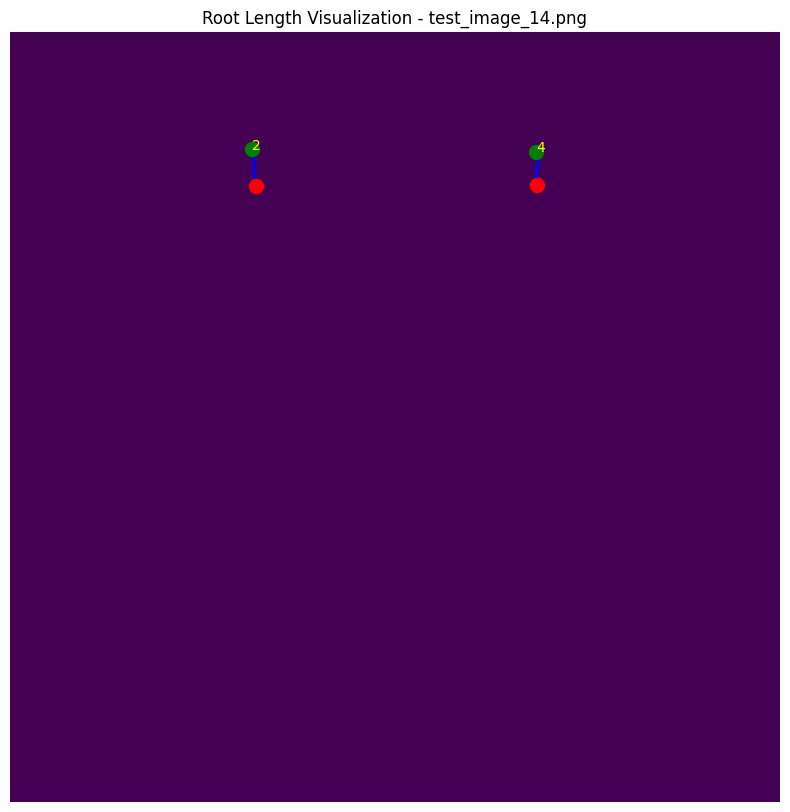

Visualizing root lengths for test_image_15.png...
Root 1: Section 3, Length = 340.92 px, Start = (480, 1429), End = (794, 1388)
Root 2: Section 1, Length = 302.64 px, Start = (510, 385), End = (794, 428)
Root 3: Section 4, Length = 344.23 px, Start = (478, 1931), End = (804, 1913)
Root 4: Section 5, Length = 276.05 px, Start = (472, 2451), End = (729, 2439)
Root 5: Section 2, Length = 284.50 px, Start = (499, 908), End = (769, 921)


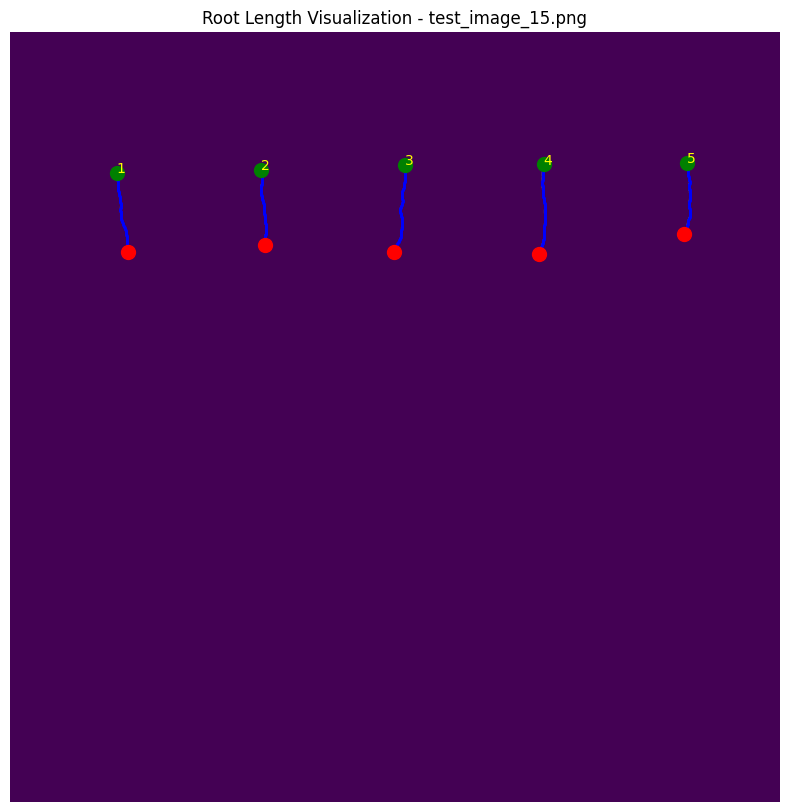

Visualizing root lengths for test_image_16.png...
Root 1: Section 1, Length = 400.79 px, Start = (462, 379), End = (828, 409)
Root 2: Section 2, Length = 401.55 px, Start = (451, 906), End = (819, 945)
Root 3: Section 4, Length = 440.49 px, Start = (480, 1928), End = (875, 1929)
Root 4: Section 5, Length = 408.99 px, Start = (450, 2457), End = (830, 2463)


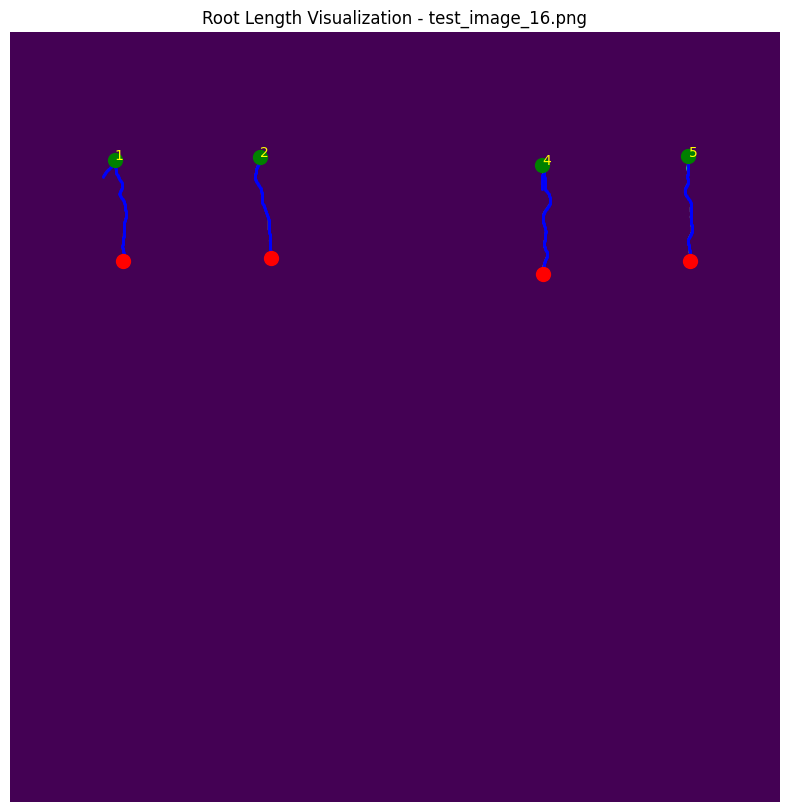

Visualizing root lengths for test_image_17.png...
Root 1: Section 3, Length = 776.84 px, Start = (460, 1399), End = (1191, 1368)
Root 2: Section 5, Length = 767.30 px, Start = (426, 2459), End = (1112, 2315)
Root 3: Section 4, Length = 822.19 px, Start = (424, 1907), End = (1157, 1951)
Root 4: Section 1, Length = 622.33 px, Start = (496, 385), End = (1062, 293)
Root 5: Section 2, Length = 688.75 px, Start = (488, 882), End = (1119, 842)


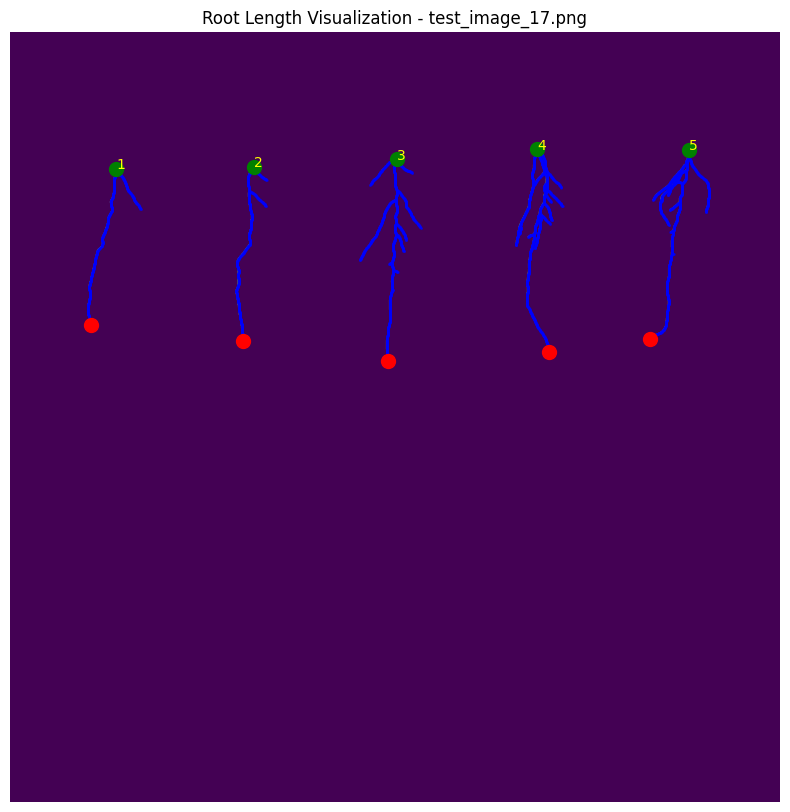

Visualizing root lengths for test_image_18.png...
Root 1: Section 4, Length = 1592.39 px, Start = (542, 1958), End = (1756, 1988)
Root 2: Section 5, Length = 1620.59 px, Start = (464, 2417), End = (1755, 2502)
Root 3: Section 2, Length = 1152.52 px, Start = (467, 898), End = (1505, 938)
Root 4: Section 1, Length = 619.59 px, Start = (508, 384), End = (1039, 297)


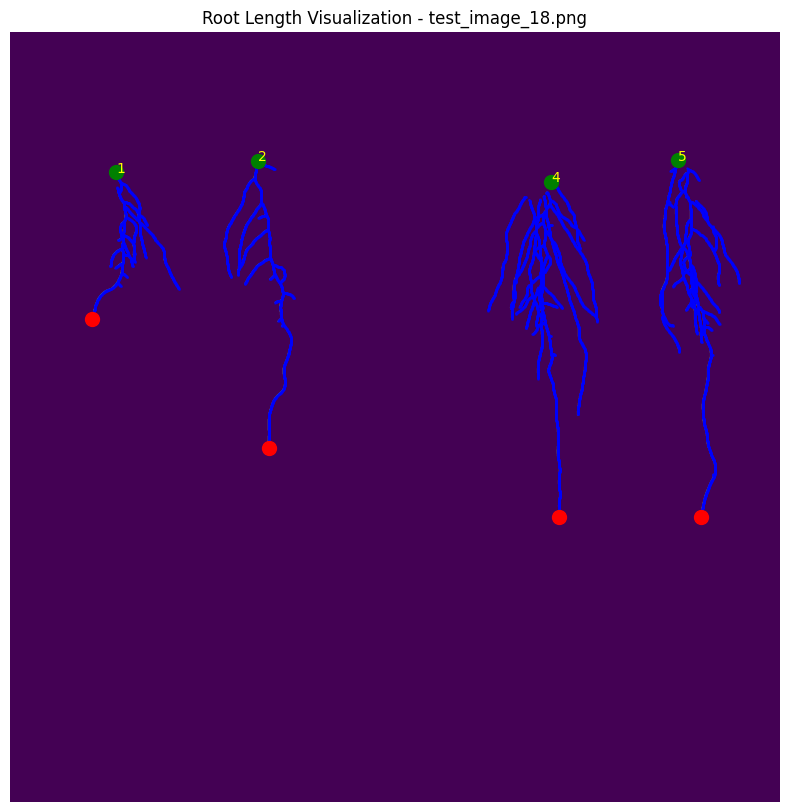

Visualizing root lengths for test_image_2.png...
Root 1: Section 4, Length = 1508.15 px, Start = (477, 1903), End = (1811, 1836)
Root 2: Section 1, Length = 1108.85 px, Start = (439, 317), End = (1453, 104)
Root 3: Section 5, Length = 1225.67 px, Start = (461, 2358), End = (1601, 2190)
Root 4: Section 3, Length = 910.52 px, Start = (435, 1354), End = (1268, 1233)
Root 5: Section 2, Length = 176.05 px, Start = (437, 828), End = (544, 884)


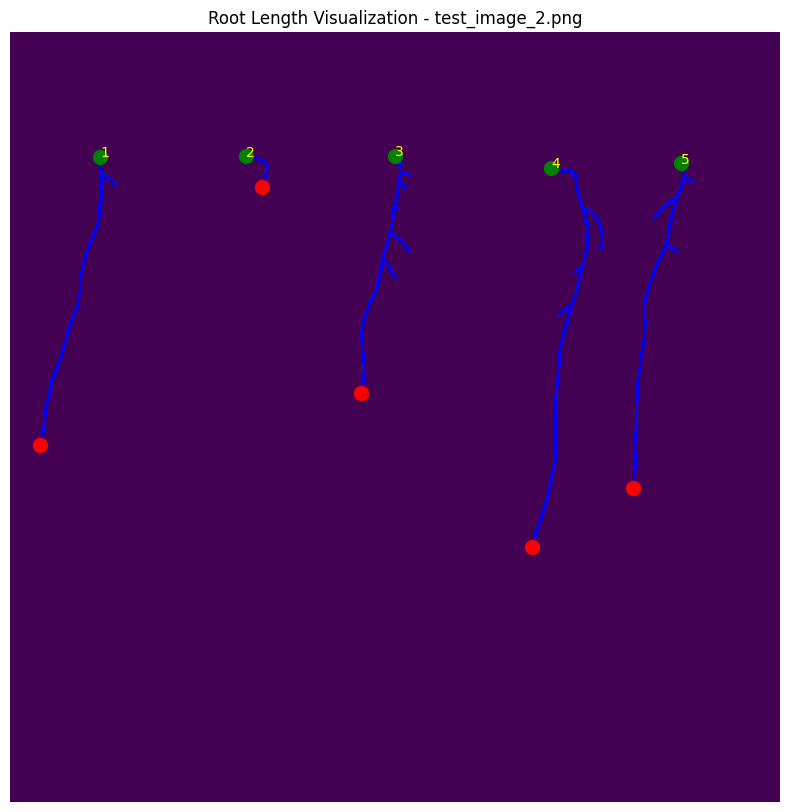

Visualizing root lengths for test_image_3.png...
Root 1: Section 1, Length = 138.80 px, Start = (463, 378), End = (596, 368)
Root 2: Section 4, Length = 104.21 px, Start = (459, 1885), End = (556, 1877)
Root 3: Section 5, Length = 56.31 px, Start = (459, 2397), End = (512, 2403)
Root 4: Section 3, Length = 44.73 px, Start = (468, 1387), End = (509, 1378)
Root 5: Section 2, Length = 18.24 px, Start = (459, 896), End = (476, 893)


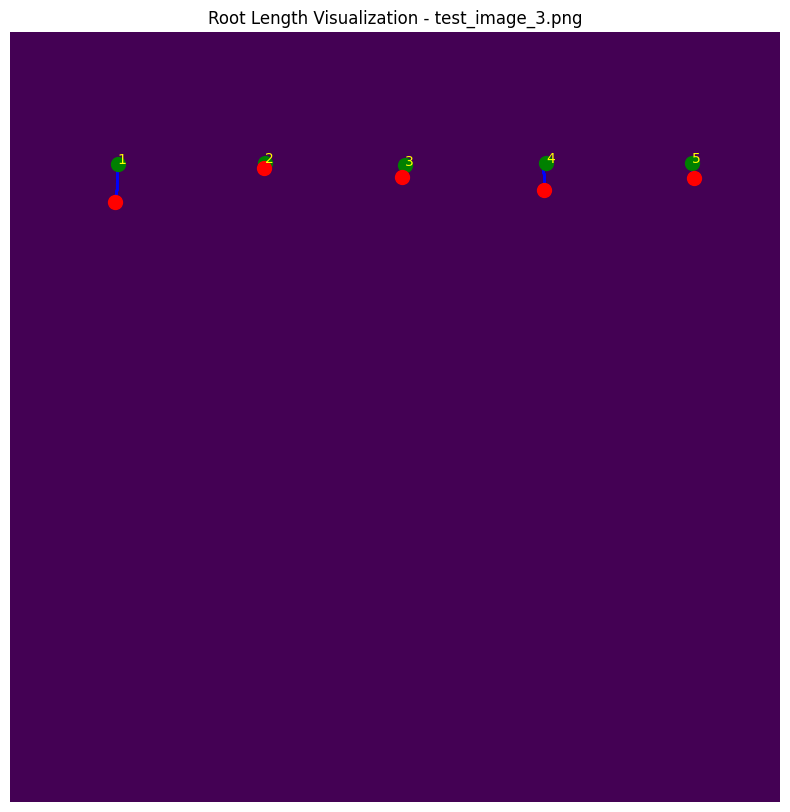

Visualizing root lengths for test_image_4.png...
Root 1: Section 4, Length = 315.08 px, Start = (456, 1905), End = (726, 1815)
Root 2: Section 1, Length = 364.07 px, Start = (416, 377), End = (749, 390)
Root 3: Section 2, Length = 321.33 px, Start = (427, 886), End = (733, 919)
Root 4: Section 3, Length = 215.11 px, Start = (459, 1391), End = (665, 1387)
Root 5: Section 5, Length = 104.49 px, Start = (460, 2407), End = (562, 2403)


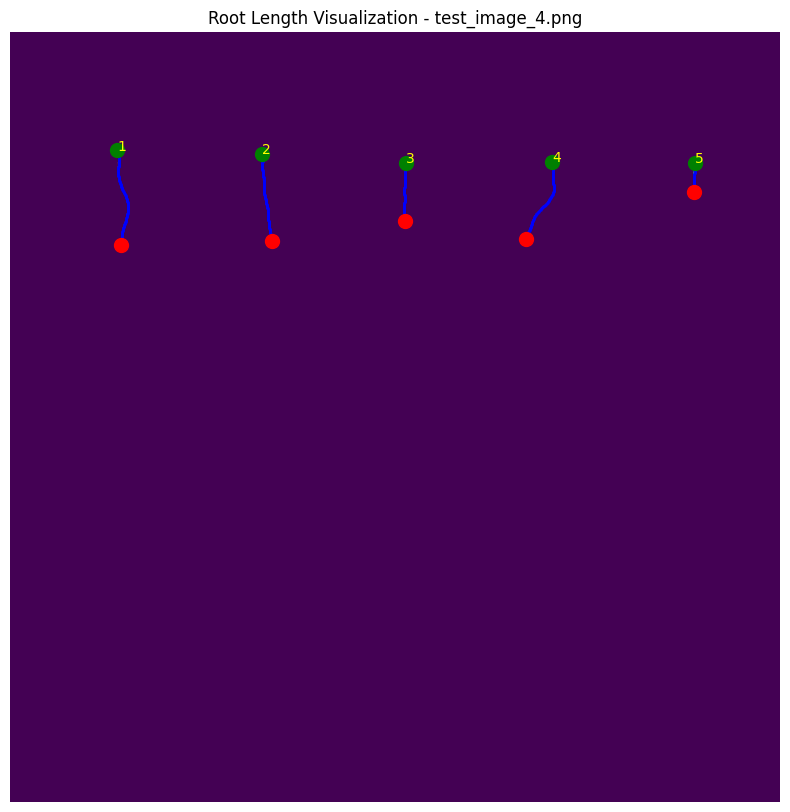

Visualizing root lengths for test_image_5.png...
Root 1: Section 1, Length = 268.44 px, Start = (500, 357), End = (744, 384)
Root 2: Section 5, Length = 215.95 px, Start = (456, 2388), End = (648, 2439)
Root 3: Section 2, Length = 247.05 px, Start = (459, 868), End = (686, 851)
Root 4: Section 4, Length = 212.01 px, Start = (460, 1874), End = (660, 1849)
Root 5: Section 3, Length = 70.31 px, Start = (459, 1363), End = (521, 1354)


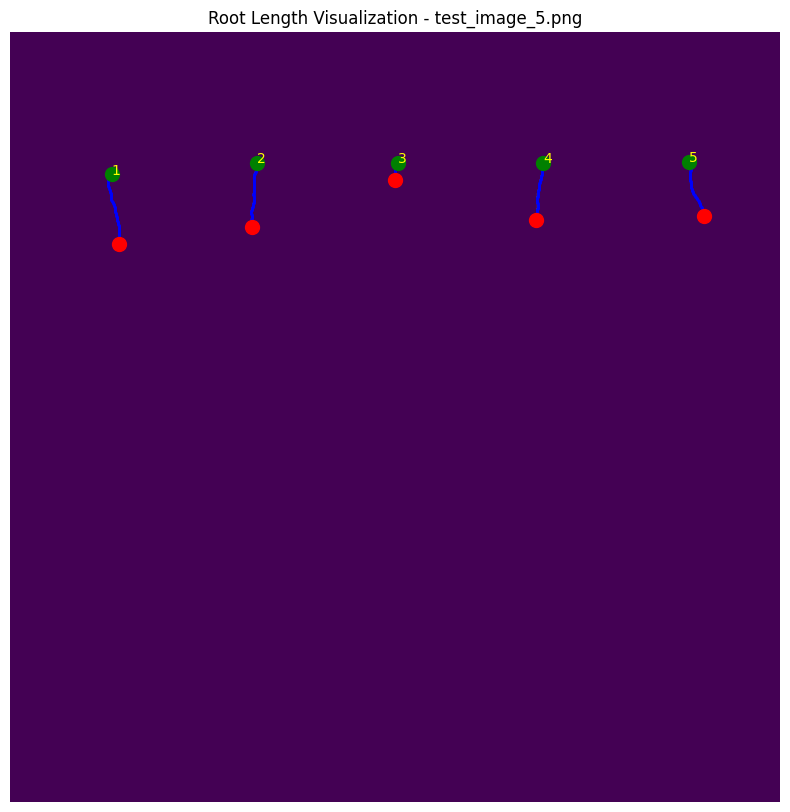

Visualizing root lengths for test_image_6.png...
Root 1: Section 3, Length = 474.98 px, Start = (477, 1373), End = (905, 1299)
Root 2: Section 2, Length = 498.72 px, Start = (440, 841), End = (906, 784)
Root 3: Section 4, Length = 463.89 px, Start = (446, 1855), End = (878, 1828)
Root 4: Section 5, Length = 295.85 px, Start = (436, 2358), End = (706, 2349)
Root 5: Section 1, Length = 314.12 px, Start = (460, 358), End = (753, 379)


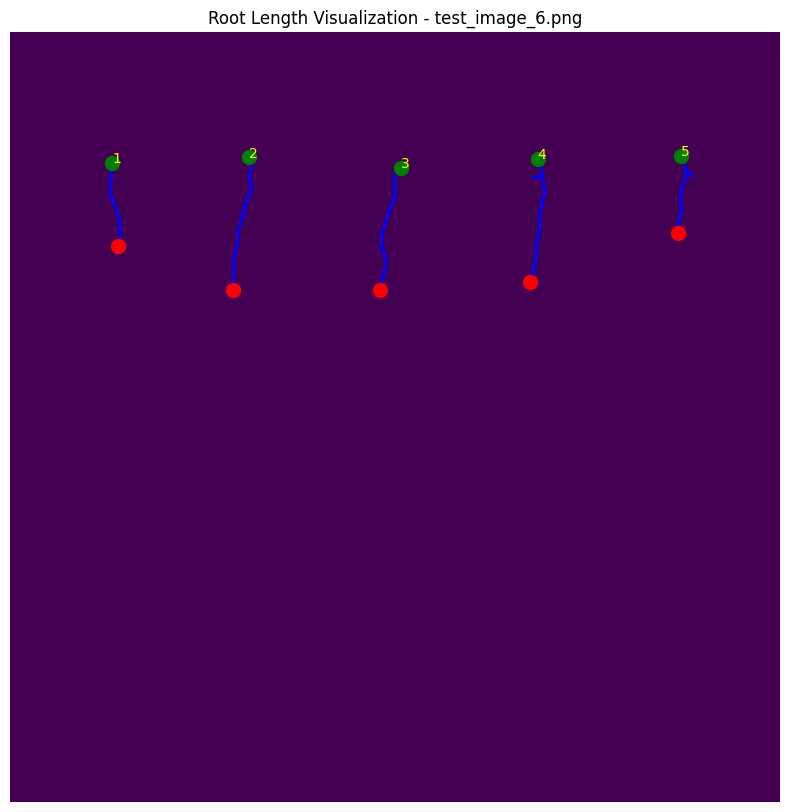

Visualizing root lengths for test_image_7.png...
Root 1: Section 5, Length = 491.59 px, Start = (472, 2390), End = (922, 2403)
Root 2: Section 4, Length = 432.65 px, Start = (442, 1860), End = (844, 1914)
Root 3: Section 1, Length = 400.25 px, Start = (468, 343), End = (853, 369)
Root 4: Section 2, Length = 189.60 px, Start = (459, 836), End = (634, 841)
Root 5: Section 3, Length = 65.24 px, Start = (460, 1366), End = (524, 1369)


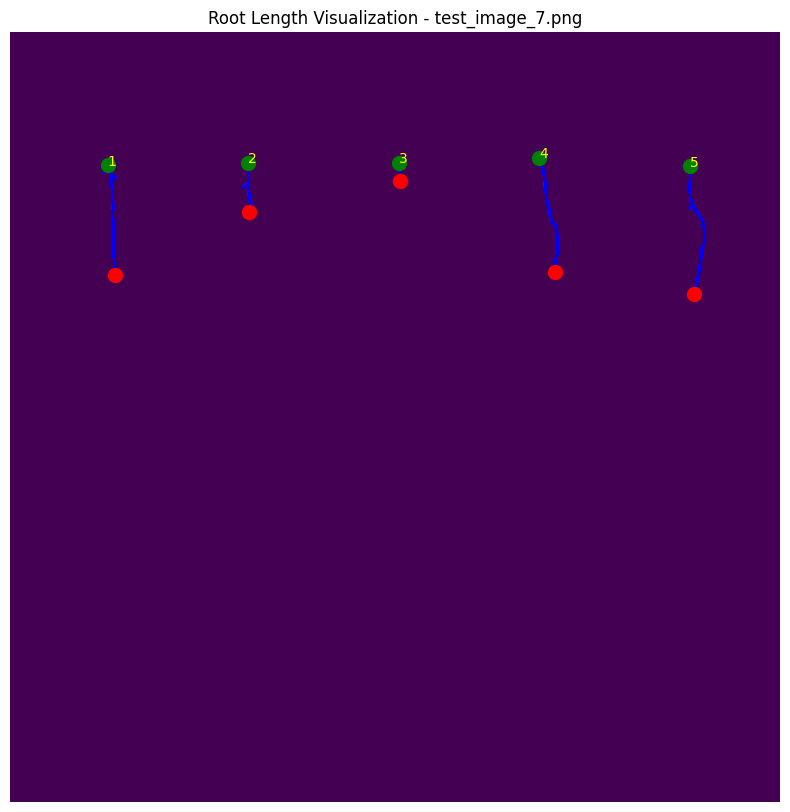

Visualizing root lengths for test_image_8.png...
Root 1: Section 1, Length = 2145.42 px, Start = (396, 379), End = (2392, 159)
Root 2: Section 2, Length = 2161.63 px, Start = (472, 888), End = (2457, 549)
Root 3: Section 4, Length = 1838.08 px, Start = (439, 1907), End = (2131, 1624)
Root 4: Section 3, Length = 2189.41 px, Start = (432, 1399), End = (2493, 1341)
Root 5: Section 5, Length = 712.97 px, Start = (418, 2411), End = (1095, 2391)


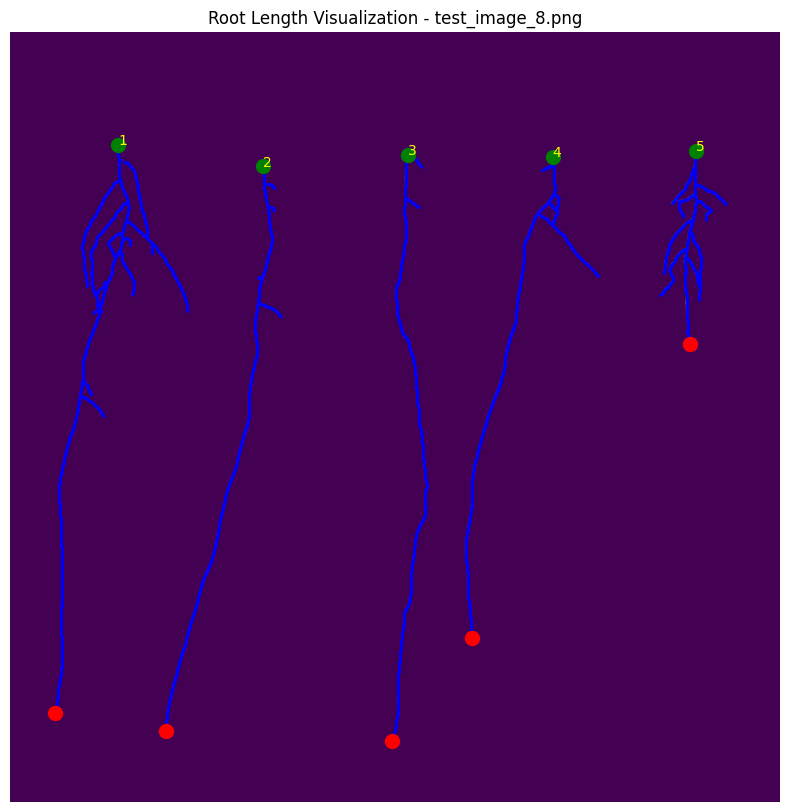

Visualizing root lengths for test_image_9.png...
Root 1: Section 5, Length = 666.46 px, Start = (470, 2466), End = (1087, 2456)
Root 2: Section 3, Length = 675.62 px, Start = (501, 1444), End = (1111, 1403)
Root 3: Section 1, Length = 585.18 px, Start = (499, 400), End = (1039, 432)
Root 4: Section 2, Length = 538.37 px, Start = (469, 907), End = (985, 883)
Root 5: Section 4, Length = 444.95 px, Start = (479, 1961), End = (902, 1974)


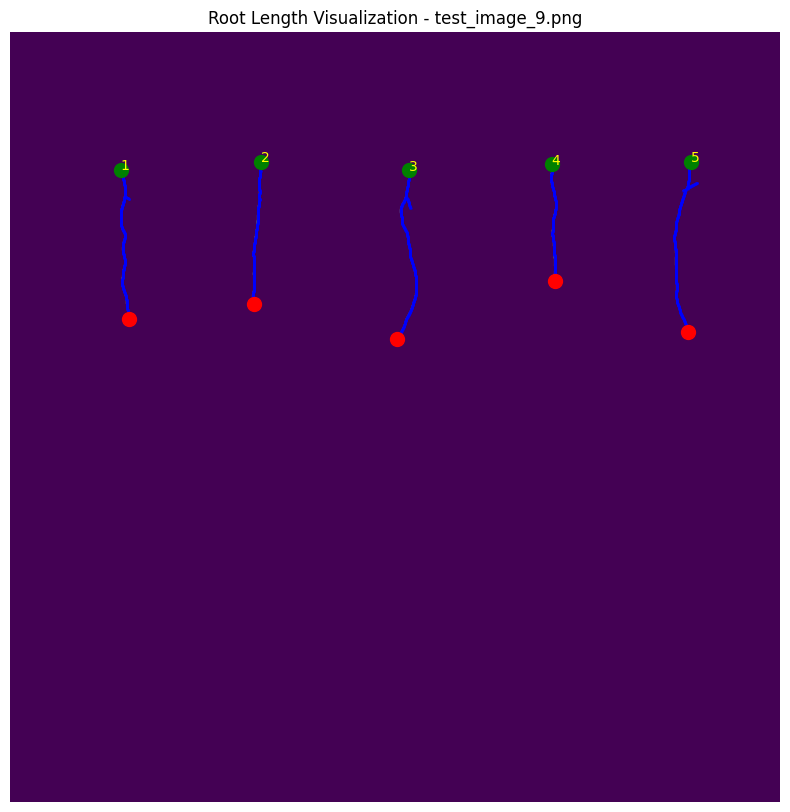

In [110]:
from skimage.morphology import skeletonize
from skan.csr import skeleton_to_csgraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def visualize_root_lengths_with_nodes(final_labeled_masks, num_sections=5):
    """
    Visualize the root lengths with skeletons overlaid, showing the top and bottom nodes
    and their respective section IDs.

    Parameters:
        final_labeled_masks (dict): Dictionary of labeled masks with components per bounding box.
        num_sections (int): Number of equal vertical sections.

    Returns:
        None
    """
    for file_name, labeled_mask in final_labeled_masks.items():
        print(f"Visualizing root lengths for {file_name}...")

        # Get dimensions of the mask
        h, w = labeled_mask.shape
        section_width = w // num_sections

        # Skeletonize the labeled mask
        skeleton = skeletonize(labeled_mask > 0)

        # Get unique root IDs, excluding the background (0)
        root_ids = np.unique(labeled_mask)
        root_ids = root_ids[root_ids > 0]

        # Visualization setup
        plt.figure(figsize=(10, 10))
        plt.imshow(labeled_mask, cmap="viridis")
        plt.title(f"Root Length Visualization - {file_name}")
        plt.axis("off")

        for root_id in root_ids:
            # Isolate the skeleton for the current root
            root_skeleton = (labeled_mask == root_id) & skeleton

            # Convert skeleton to graph and coordinates
            graph, coordinates = skeleton_to_csgraph(root_skeleton)

            # Convert sparse graph to NetworkX graph
            G = nx.Graph()
            for i, j in zip(*graph.nonzero()):
                G.add_edge(i, j, weight=graph[i, j])

            try:
                # Identify topmost and bottommost nodes
                topmost_node = min(G.nodes, key=lambda n: coordinates[0][n])  # Smallest y (row)
                bottommost_node = max(G.nodes, key=lambda n: coordinates[0][n])  # Largest y (row)

                # Calculate root length using Dijkstra's algorithm
                length = nx.dijkstra_path_length(G, source=topmost_node, target=bottommost_node, weight='weight')

                # Determine the section based on the x-coordinate of the topmost node
                top_x = coordinates[1][topmost_node]
                section_idx = int(top_x // section_width)

                # Get coordinates of start and end points
                start_coords = (coordinates[0][topmost_node], coordinates[1][topmost_node])  # (row, col)
                end_coords = (coordinates[0][bottommost_node], coordinates[1][bottommost_node])  # (row, col)

                # Overlay skeleton points and start/end nodes
                y_coords, x_coords = np.where(root_skeleton)
                plt.scatter(x_coords, y_coords, c="blue", s=1, alpha=0.5)  # Skeleton points
                plt.scatter(start_coords[1], start_coords[0], c="green", s=100)  # Top node
                plt.text(
                    start_coords[1], start_coords[0], f"{section_idx + 1}", color="yellow", fontsize=10
                )  # Section number
                plt.scatter(end_coords[1], end_coords[0], c="red", s=100)  # Bottom node

                print(
                    f"Root {root_id}: Section {section_idx + 1}, Length = {length:.2f} px, "
                    f"Start = {start_coords}, End = {end_coords}"
                )
            except Exception as e:
                print(f"Root {root_id} in {file_name} caused an error: {e}")
                continue

        plt.show()
visualize_root_lengths_with_nodes(final_labeled_masks, num_sections=5)


### Save to a CSV:

In [109]:
import pandas as pd
from skimage.morphology import skeletonize
from skan.csr import skeleton_to_csgraph
import networkx as nx

def calculate_and_save_root_lengths(final_labeled_masks, output_path, num_sections=5):
    """
    Calculate root lengths for each plant based on the labeled masks, assign them to sections,
    and save the results to a CSV.

    Parameters:
        final_labeled_masks (dict): Dictionary of labeled masks with components per bounding box.
        output_path (str): Path to save the resulting CSV file.
        num_sections (int): Number of equal vertical sections.

    Returns:
        None
    """
    results = []

    for file_name, labeled_mask in final_labeled_masks.items():
        print(f"Processing root lengths for {file_name}...")

        # Get dimensions of the mask
        h, w = labeled_mask.shape
        section_width = w // num_sections

        # Skeletonize the labeled mask
        skeleton = skeletonize(labeled_mask > 0)

        # Get unique root IDs, excluding the background (0)
        root_ids = np.unique(labeled_mask)
        root_ids = root_ids[root_ids > 0]

        # Initialize section lengths as 0
        section_lengths = [0.0] * num_sections

        for root_id in root_ids:
            # Isolate the skeleton for the current root
            root_skeleton = (labeled_mask == root_id) & skeleton

            # Convert skeleton to graph and coordinates
            graph, coordinates = skeleton_to_csgraph(root_skeleton)

            # Convert sparse graph to NetworkX graph
            G = nx.Graph()
            for i, j in zip(*graph.nonzero()):
                G.add_edge(i, j, weight=graph[i, j])

            try:
                # Identify topmost and bottommost nodes
                topmost_node = min(G.nodes, key=lambda n: coordinates[0][n])  # Smallest y (row)
                bottommost_node = max(G.nodes, key=lambda n: coordinates[0][n])  # Largest y (row)

                # Calculate root length using Dijkstra's algorithm
                length = nx.dijkstra_path_length(G, source=topmost_node, target=bottommost_node, weight='weight')

                # Determine the section based on the x-coordinate of the topmost node
                top_x = coordinates[1][topmost_node]
                section_idx = int(top_x // section_width)

                # Update the section length if the current root is the longest in the section
                if length > section_lengths[section_idx]:
                    section_lengths[section_idx] = length
            except Exception as e:
                print(f"Root {root_id} in {file_name} caused an error: {e}")
                continue

        # Save results for the current file
        for section_idx, length in enumerate(section_lengths):
            base_name = file_name.replace(".png", "")  # Remove the .png extension
            plant_id = f"{base_name}_plant_{section_idx + 1}"
            results.append({"Plant ID": plant_id, "Length (px)": length})

    # Save all results to CSV
    df = pd.DataFrame(results, columns=["Plant ID", "Length (px)"])
    df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}.")


calculate_and_save_root_lengths(final_labeled_masks, output_path, num_sections=5)


Processing root lengths for test_image_1.png...
Processing root lengths for test_image_10.png...
Processing root lengths for test_image_11.png...
Processing root lengths for test_image_12.png...
Processing root lengths for test_image_13.png...
Processing root lengths for test_image_14.png...
Processing root lengths for test_image_15.png...
Processing root lengths for test_image_16.png...
Processing root lengths for test_image_17.png...
Processing root lengths for test_image_18.png...
Processing root lengths for test_image_2.png...
Processing root lengths for test_image_3.png...
Processing root lengths for test_image_4.png...
Processing root lengths for test_image_5.png...
Processing root lengths for test_image_6.png...
Processing root lengths for test_image_7.png...
Processing root lengths for test_image_8.png...
Processing root lengths for test_image_9.png...
Results saved to C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\Deliverables\task 8\Outputs\output5